# Machine learning for solid solutions (Li2TiS3)

This notebook is divided into these sections:
- [LTS dataset](#lts)
    - write CRYSTAL input files
    - read CRYSTAL output files
- [Descriptors](#descriptors)
    - [Coulomb Matrix (CM)](#CM)
    - [Smooth Overlap of Atomic Positions (SOAP)](#soap)
    - [Many Body Tensor Representation (MBTR)](#mbtr)
    - [Local Many Body Tensor Representation (LMBTR)](#lmbtr)
    - [Ewald Sum Matrix](#ewald)
    - [Sine Matrix](#sine)
    
- [Machine learning](#ml)
    - [linear regression](#lr)
    - [Gradient Boosting Decision Tree (GBDT)](#gbdt)
    - [KNeighbors Regression (KNR)](#knr)
    - [KMeans Clustering](#kmeans) 
- [Protocol](#protocol)
    - [simmetry analysis](#symmetry)
- [Extra](#extra)
- [Functions](#f)

In [184]:
import os
import copy
import json
import itertools
import shutil as sh
from pathlib import Path
import numpy as np
import pandas as pd
import pickle
from datetime import datetime

from CRYSTALpytools.crystal_io import Crystal_output, Crystal_input, Crystal_density, Crystal_gui
from CRYSTALpytools.convert import cry_gui2pmg, cry_out2pmg
from CRYSTALpytools.utils import view_pmg

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.io.cif import CifWriter
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer, PointGroupAnalyzer

from ase.visualize import view

from dscribe.descriptors import CoulombMatrix


from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, max_error, mean_absolute_error
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,15)

In [2]:
import tensorflow as tf
devices = tf.config.list_physical_devices()
print(devices)

2023-05-03 10:28:43.792782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# <a id='lts'>LTS dataset - pymatgen</a>

In [3]:
# New atom
new_atom = 'Li'

# Read the confcount output
cry_output = Crystal_output().read_cry_output('data/crystal/lts/lts_confcount.out')
cry_output.get_config_analysis()

# Read the initial structure (before substitution)
original_structure_gui =  Crystal_gui().read_cry_gui('data/crystal/lts/lts_confcount.gui')
original_structure = cry_gui2pmg(original_structure_gui)

structures_lts = []
li_atoms = []
ti_atoms = []
for j,substitutions in enumerate(cry_output.atom_type2):
    new_structure = original_structure.copy()
    for i in substitutions:
        new_structure.replace(i-1,new_atom)
    structures_lts.append(new_structure)
    ti_atoms.append((np.array(cry_output.atom_type1[j])-1).tolist())
    li_atoms.append((np.array(cry_output.atom_type2[j])-1).tolist())

structures = copy.deepcopy(structures_lts)

## Read the energy and band gap

#### Single point

In [4]:
energies_sp = []
gap_sp = []
for i in range(len(structures)):
    crystal_output = Crystal_output().read_cry_output('./data/crystal/lts/sp/output/lts_sp_%s.out'%str(i))
    if crystal_output.get_final_energy() != None:
        energies_sp.append(crystal_output.get_final_energy())
        gap_sp.append(crystal_output.get_band_gap())

In [11]:
np.save('./data/crystal/lts/sp/energies_sp.npy',energies_sp,allow_pickle=True)

In [5]:
energies_sp = np.load('./data/crystal/lts/sp/energies_sp.npy',allow_pickle=True)

In [13]:
np.save('./data/crystal/lts/sp/gap_sp.npy',gap_sp,allow_pickle=True)

In [6]:
gap_sp = np.load('./data/crystal/lts/sp/gap_sp.npy',allow_pickle=True)

#### Adding all the energies into one database

In [7]:
Enr_Des = pd.DataFrame()
Enr_Des['Energies'] = energies_sp
Enr_Des['Egap'] = gap_sp

#### Optimised geometry

In [8]:
energies_opt = []
gap_opt = []
for i in range(len(structures)):
    #crystal_output = Crystal_output().read_cry_output('./data/crystal/lts/sp/output/lts_sp_%s.out'%str(i))
    if crystal_output.get_final_energy() != None:
        energies_opt.append(crystal_output.get_final_energy())
        gap_opt.append(crystal_output.get_band_gap())

## Covert the LTS dataset to ASE

In [9]:
ase_structures = []
for i in range(len(structures)):
    ase_struct = AseAtomsAdaptor().get_atoms(structures[i])
    ase_structures.append(ase_struct)

# <a id='descriptors'>Descriptors</a>

## <a id='CM'>Coulomb Matrix</a>

$M_{ij}^{Coulomb}= \Bigl\{^{0.5Z_i^{2.4} \; \; for \; i=j}_{\frac{Z_iZ_j}{R_{ij}}\;\;\;\; for \; i\neq j}$

(taken from the Dscribe website)

The diagonal elements are the interaction of an atom with itself and are a polynomial fit of the atomic energies to the nuclear charge $Z_i$. 

The off-diagonal elements represent the Coulomb repulsion between nuclei $i$ and $j$.

In [10]:
#dscribe descriptors CM
from dscribe.descriptors import CoulombMatrix

cm_dscribe = []
cm_ds = CoulombMatrix(n_atoms_max=54,permutation="eigenspectrum")
start = datetime.now()
for i,ase_struct in enumerate(ase_structures):
    dscribe_matrix = cm_ds.create(ase_struct)
#    dscribe_matrix = np.real(dscribe_matrix)
    cm_dscribe.append(dscribe_matrix)
    now = datetime.now()
    if (i+1)%200 == 0: 
        print("matrices read:", len(cm_dscribe),", time:", (now - start))
   
print('Number of matrices read: ', len(cm_dscribe))
print("--- %s time taken ---" % (datetime.now()- start))

matrices read: 200 , time: 0:00:00.026839
matrices read: 400 , time: 0:00:00.052598
matrices read: 600 , time: 0:00:00.078341
matrices read: 800 , time: 0:00:00.104344
matrices read: 1000 , time: 0:00:00.130712
matrices read: 1200 , time: 0:00:00.157287
matrices read: 1400 , time: 0:00:00.183636
matrices read: 1600 , time: 0:00:00.209732
matrices read: 1800 , time: 0:00:00.234702
matrices read: 2000 , time: 0:00:00.259680
matrices read: 2200 , time: 0:00:00.284505
matrices read: 2400 , time: 0:00:00.309560
matrices read: 2600 , time: 0:00:00.334651
matrices read: 2800 , time: 0:00:00.359558
matrices read: 3000 , time: 0:00:00.384456
matrices read: 3200 , time: 0:00:00.409492
matrices read: 3400 , time: 0:00:00.435131
matrices read: 3600 , time: 0:00:00.461063
matrices read: 3800 , time: 0:00:00.486839
matrices read: 4000 , time: 0:00:00.512372
Number of matrices read:  4023
--- 0:00:00.515398 time taken ---


In [11]:
#saving the files into the same dataframe
Enr_Des['CME'] = cm_dscribe

### Inspect the descriptor

#### Full matrix

In [21]:
cm_ds = CoulombMatrix(n_atoms_max=54,permutation='none',flatten=False)
print(cm_ds.create(ase_structures[0]))
print(cm_ds.create(ase_structures[0]).shape)

[[  6.98330508   2.50278676   2.50278676 ...  18.87719988   6.29239996
   10.89875643]
 [  2.50278676   6.98330508   1.25139338 ...  10.89875643   4.33072666
    6.29239996]
 [  2.50278676   1.25139338   6.98330508 ...  10.89875643  10.89875643
   18.87719988]
 ...
 [ 18.87719988  10.89875643  10.89875643 ... 388.02344103  35.59518946
   71.19037891]
 [  6.29239996   4.33072666  10.89875643 ...  35.59518946 388.02344103
   71.19037891]
 [ 10.89875643   6.29239996  18.87719988 ...  71.19037891  71.19037891
  388.02344103]]
(54, 54)


#### Eigenvalues only

In [22]:
cm_ds = CoulombMatrix(n_atoms_max=54,permutation='eigenspectrum')
print(cm_ds.create(ase_structures[0]))
print(cm_ds.create(ase_structures[0]).shape)

[2679.77619447 1133.67577892  913.07374493  841.08011951  712.6289803
  708.830714    692.25295309  656.98047438  655.93789699  611.12050477
  467.43255314  434.36093126  405.95650918  373.37691024  360.90885612
  360.73370676  330.59963438  323.17143181  321.91922861  319.70671666
  317.12026943  310.00661992  304.11487923  301.61723033  299.21583906
  298.12478161  296.60093965  292.83209275  292.52858515  292.14396424
  291.40954568  283.9316412   283.8511157   283.12161825  282.57751345
  280.79923438   12.8666636     7.39275912    7.03464999    5.57408163
    5.28041001    4.54978872    4.52989384    4.34655433    4.22686951
    4.14798147    3.80471049    3.74741204    3.72709043    3.52626779
    3.47022584    3.37089434    3.33626234    3.28758742]
(54,)


In [10]:
# Save cme to file
np.save('./data/descriptors/cm_dscribe.npy',cm_dscribe,allow_pickle=True)

In [21]:
# Read cme from file
cm_dscribe = np.load('./data/descriptors/cm_dscribe.npy',allow_pickle=True)
cm_dscribe.shape

(4023, 54)

### Test the parameters

#there's not really any parameters that needed to be set for CME as there is only the maximum atoms

## <a id='soap'>Smooth Overlap of Atomic Positions (SOAP)</a>

$P_{nn'l}^{Z_1Z_2} = \pi \sqrt{\frac{8}{2l+1}}\sum c_{nlm}^{Z_1}*c_{n'lm}^{Z_2}$

where the $n$ indices for the different radial basis functions for up to $n_{max}$, $l$ is the angular degree of the spherical harmonics up to $l_{max}$. 
<br>
The defult for Dscribe descriptors are the spherical gaussian type orbitals as riadial baiss functions.

In [12]:
#setting up the SOAP descriptor

from dscribe.descriptors import SOAP


rcut = 6.0
nmax = 8
lmax = 6

soap = SOAP(
    species = ["Li", "Ti", "S"],
    periodic= True,
    r_cut=rcut,
    n_max=nmax,
    l_max=lmax
)

In [13]:
soap_dscribe = []
start = datetime.now()
for i,ase_struct in enumerate(ase_structures):
    soap_matrix = soap.create(ase_struct)
    #soap_matrix = np.real(soap_matrix)
    soap_dscribe.append(soap_matrix)
    now = datetime.now()
    if int(len(soap_dscribe)) == 20:
        print("matrices read:", len(soap_dscribe),", time:", (now - start))
    if int(len(soap_dscribe))%200 == 0: 
        print("matrices read:", len(soap_dscribe),", time:", (now - start))
    
print('Number of matrices read: ', len(soap_dscribe))
print("--- %s time taken ---" % ((datetime.now() - start)))

matrices read: 20 , time: 0:00:00.311727
matrices read: 200 , time: 0:00:02.733234
matrices read: 400 , time: 0:00:05.701502
matrices read: 600 , time: 0:00:08.641887
matrices read: 800 , time: 0:00:11.562965
matrices read: 1000 , time: 0:00:14.596664
matrices read: 1200 , time: 0:00:17.738010
matrices read: 1400 , time: 0:00:20.532409
matrices read: 1600 , time: 0:00:23.343204
matrices read: 1800 , time: 0:00:26.114742
matrices read: 2000 , time: 0:00:28.873611
matrices read: 2200 , time: 0:00:31.682620
matrices read: 2400 , time: 0:00:34.814844
matrices read: 2600 , time: 0:00:37.855155
matrices read: 2800 , time: 0:00:40.836144
matrices read: 3000 , time: 0:00:43.886578
matrices read: 3200 , time: 0:00:46.748508
matrices read: 3400 , time: 0:00:49.551580
matrices read: 3600 , time: 0:00:52.430231
matrices read: 3800 , time: 0:00:55.347593
matrices read: 4000 , time: 0:00:58.262429
Number of matrices read:  4023
--- 0:00:58.584581 time taken ---


In [18]:
# Save SOAP to file
np.save('./data/descriptors/soap_dscribe.npy',soap_dscribe,allow_pickle=True)

In [22]:
# Read SOAP from file
soap_dscribe = np.load('./data/descriptors/soap_dscribe.npy',allow_pickle=True)
soap_dscribe.shape

(4023, 54, 2100)

In [25]:
print(soap_dscribe[0])

[[ 1.31353093e-02  7.73465020e-02  1.38221146e-01 ...  1.96508259e-01
  -3.96163258e-01  9.21863184e-01]
 [ 1.31353093e-02  7.73465020e-02  1.38221146e-01 ...  1.96508259e-01
  -3.96163258e-01  9.21863184e-01]
 [ 1.31353093e-02  7.73465020e-02  1.38221146e-01 ...  1.96508259e-01
  -3.96163258e-01  9.21863184e-01]
 ...
 [ 1.11314369e-03  4.06866813e-04  1.98625315e-02 ...  4.60933402e-01
  -6.75916720e-01  9.92822626e-01]
 [ 1.11314369e-03  4.06866813e-04  1.98625315e-02 ...  4.60933402e-01
  -6.75916720e-01  9.92822626e-01]
 [ 1.11314369e-03  4.06866813e-04  1.98625315e-02 ...  4.60933402e-01
  -6.75916720e-01  9.92822626e-01]]


In [26]:
print(soap_dscribe[0].shape)

(54, 2100)


###  Inspection of the descriptor

In [45]:
#reference

rcut = 20
nmax = 8
lmax = 6
soap = SOAP(
            species = ["Li", "Ti", "S"],
            periodic= True,
            r_cut=rcut,
            n_max=nmax,
            l_max=lmax,

        )
        

soap_max = soap.create(ase_structures[0])

In [49]:
print(soap_max)
flat = soap_max.flatten()
print(flat.shape)


[[ 2.45363608e-01  1.45172131e+00 -3.82618049e-01 ...  1.20095615e+01
  -1.96018038e+01  3.19962695e+01]
 [ 2.45363608e-01  1.45172131e+00 -3.82618049e-01 ...  1.20095615e+01
  -1.96018038e+01  3.19962695e+01]
 [ 2.45363608e-01  1.45172131e+00 -3.82618049e-01 ...  1.20095615e+01
  -1.96018038e+01  3.19962695e+01]
 ...
 [ 2.03856634e-02  3.98716685e-02  2.20314643e-01 ...  2.23668637e+01
  -2.69527879e+01  3.24809737e+01]
 [ 2.03856634e-02  3.98716685e-02  2.20314643e-01 ...  2.23668637e+01
  -2.69527879e+01  3.24809737e+01]
 [ 2.03856634e-02  3.98716685e-02  2.20314643e-01 ...  2.23668637e+01
  -2.69527879e+01  3.24809737e+01]]
(113400,)


In [34]:
#changing the parameters to see how the value change:
rcut = np.arange(6,21,1)
#rcut = np.arange(6,13,1)
nmax = list(range(1,13))
lmax = np.arange(1,13,1)
dct = {}

start = datetime.now()
for r in rcut:
    for n in nmax:
        for l in lmax:
            soap = SOAP(
                species = ["Li", "Ti", "S"],
                periodic= True,
                    r_cut=r,
                    n_max=n,
                    l_max=l
                )
      
            dct['r_%s_n_%s_l_%s' % (r, n, l) ] = []
            for a in range(10):
                soap_matrix = soap.create(ase_structures[a])
#            soap_matrix = soap.create(ase_structures[1:10])
                dct['r_%s_n_%s_l_%s' % (r, n, l)].append(soap_matrix)
                now = datetime.now()
        
    print('rcut =',r , 'nmax =',n , 'lmax =',l, 'done')
    print('time taken to finish cycle with r=%s :%s' % (r, datetime.now() - start))        

rcut = 6 nmax = 12 lmax = 12 done
time taken to finish cycle with r=6 :0:00:35.787226
rcut = 7 nmax = 12 lmax = 12 done
time taken to finish cycle with r=7 :0:01:18.438452
rcut = 8 nmax = 12 lmax = 12 done
time taken to finish cycle with r=8 :0:02:21.214211
rcut = 9 nmax = 12 lmax = 12 done
time taken to finish cycle with r=9 :0:03:34.268824
rcut = 10 nmax = 12 lmax = 12 done
time taken to finish cycle with r=10 :0:05:12.565188
rcut = 11 nmax = 12 lmax = 12 done
time taken to finish cycle with r=11 :0:07:03.181612
rcut = 12 nmax = 12 lmax = 12 done
time taken to finish cycle with r=12 :0:09:24.924673


In [76]:
#lets assume ideal lmax and nmax = 12
#let's use linear regression and plot the MAE

#Testing Rcut values 
    #need to find the ideal n and l values as well
testE = np.arange(400,500,10)
para_test_soap = pd.DataFrame(testE)

#need to split all of the descriptors to training set and test set

for i in rcut:
    para_test_soap['r_%s_n_12_l_12' %str(i)] = dct['r_%s_n_12_l_12' %str(i)]
    X_train, X_test, y_train, y_test = train_test_split(para_test_soap['r_%s_n_12_l_12' %str(i)], para_test_soap[0], random_state=1, test_size = 0.5)
    scaler = MinMaxScaler()  
    #scaler.fit(X_train)  
    #X_train = scaler.transform(X_train)  
    #X_test = scaler.transform(X_test) 

#and then need to run to fit for each r values
#predictions for the energies for each r values
#calculations for the errors
#plotting of the errors against the increasing rcut value

## <a id='mbtr'>Many Body Tensor Representation (MBTR)</a>

In [16]:
from dscribe.descriptors import MBTR

#setting up the MBTR descriptor
mbtr = MBTR(
    species=["Li", "Ti", "S"],
    k1={
        "geometry": {"function": "atomic_number"},
        "grid": {"min": 0, "max": 8, "n": 200, "sigma": 0.1},
    },
    k2={
        "geometry": {"function": "inverse_distance"},
        "grid": {"min": 0, "max": 1, "n": 100, "sigma": 0.1},
        "weighting": {"function": "exp", "scale": 0.5, "threshold": 1e-3},
    },
    k3={
        "geometry": {"function": "cosine"},
        "grid": {"min": -1, "max": 1, "n": 100, "sigma": 0.1},
        "weighting": {"function": "exp", "scale": 0.5, "threshold": 1e-3},
    },
    periodic=True,
    normalization="l2_each",
    flatten=True,
    #sparse=False (only changes the return type)
)

In [17]:
#MBTR descriptor
mbtr_dscribe = []
start = datetime.now()
for i,ase_struct in enumerate(ase_structures):
    mbtr_matrix = mbtr.create(ase_struct)
    #mbtr_matrix = np.real(mbtr_matrix)
    mbtr_dscribe.append(mbtr_matrix)
    now = datetime.now()
    if int(len(mbtr_dscribe)) == 20:
        print("matrices read:", len(mbtr_dscribe),", time:", (now - start))
    if int(len(mbtr_dscribe))%200 == 0: 
        print("matrices read:", len(mbtr_dscribe),", time:", (now - start))
print('Number of matrices read: ', len(mbtr_dscribe))
print("--- %s time taken ---" % ((datetime.now() - start)))

matrices read: 20 , time: 0:00:18.050139
matrices read: 200 , time: 0:03:01.936286
matrices read: 400 , time: 0:06:04.028603
matrices read: 600 , time: 0:09:07.100235
matrices read: 800 , time: 0:12:13.007208
matrices read: 1000 , time: 0:15:18.925729
matrices read: 1200 , time: 0:18:27.113532
matrices read: 1400 , time: 0:21:33.960578
matrices read: 1600 , time: 0:24:46.909046
matrices read: 1800 , time: 0:28:00.224285
matrices read: 2000 , time: 0:31:13.665095
matrices read: 2200 , time: 0:34:24.399120
matrices read: 2400 , time: 0:37:33.123760
matrices read: 2600 , time: 0:40:42.392552
matrices read: 2800 , time: 0:43:52.819412
matrices read: 3000 , time: 0:47:02.895311
matrices read: 3200 , time: 0:50:14.833736
matrices read: 3400 , time: 0:53:29.694978
matrices read: 3600 , time: 0:56:38.818548
matrices read: 3800 , time: 0:59:58.315849
matrices read: 4000 , time: 1:03:11.822452
Number of matrices read:  4023
--- 1:03:33.755541 time taken ---


In [20]:
# Save data frame to .pkl file.
    #.pkl only works for panda DataFrame
mbtr_dscribe = pd.DataFrame(mbtr_dscribe)
import pickle
mbtr_dscribe.to_pickle('./data/descriptors/mbtr_dscribe.pkl')

In [25]:
#reading MBTR from a .pkl file
MBTR_dscribe = np.load('./data/descriptors/MBTR_dscribe.pkl',allow_pickle=True)
MBTR_dscribe.shape


(4023, 3000)

In [64]:
test = MBTR_dscribe.to_numpy()

In [ ]:
# Save MBTR to file
#np.save('./data/descriptors/MBTR_dscribe.npy',mbtr_dscribe,allow_pickle=True)

In [21]:
# Read MBTR from file
MBTR_dscribe = np.load('./data/descriptors/MBTR_dscribe.pkl',allow_pickle=True)
MBTR_dscribe.shape

(4023, 3000)

In [61]:
mbtr_1 = mbtr.create(ase_structures[0])

In [65]:
print(mbtr_1)
print(np.shape(mbtr_1))

[0.         0.         0.         ... 0.00166096 0.00134801 0.00105044]
(3000,)


### Inspection of the descriptor

## <a id='lmbtr'>Local Many Body Tensor Representation (LMBTR)</a>

In [109]:
from dscribe.descriptors import LMBTR
lmbtr = LMBTR(
    species=["Li", "Ti", "S"],
    k2={
        "geometry": {"function": "inverse_distance"},
        "grid": {"min": 0, "max": 1, "n": 100, "sigma": 0.1},
        "weighting": {"function": "exp", "scale": 0.5, "threshold": 1e-3},
    },
    k3={
        "geometry": {"function": "cosine"},
        "grid": {"min": -1, "max": 1, "n": 100, "sigma": 0.1},
        "weighting": {"function": "exp", "scale": 0.5, "threshold": 1e-3},
    },
    periodic=True,
    normalization="l2_each",
    flatten =True
)


In [110]:
lmbtr_dscribe = []
start = datetime.now()
for i,ase_struct in enumerate(ase_structures):
    lmbtr_matrix = lmbtr.create(ase_struct)
    lmbtr_dscribe.append(lmbtr_matrix)
    now = datetime.now()
    if int(len(lmbtr_dscribe)) == 20:
        print("matrices read:", len(lmbtr_dscribe),", time:", (now - start))
    if int(len(lmbtr_dscribe))%200 == 0: 
        print("matrices read:", len(lmbtr_dscribe),", time:", (now - start))
print('Number of matrices read: ', len(lmbtr_dscribe))
print("--- %s time taken ---" % ((datetime.now() - start)))

matrices read: 20 , time: 0:00:29.723770


KeyboardInterrupt: 

In [111]:
print(lmbtr_dscribe[0])
print(lmbtr_dscribe[0].shape)


[[0.         0.         0.         ... 0.00024525 0.00019345 0.00014758]
 [0.         0.         0.         ... 0.00024525 0.00019345 0.00014758]
 [0.         0.         0.         ... 0.00024525 0.00019345 0.00014758]
 ...
 [0.         0.         0.         ... 0.00168127 0.00142138 0.00118152]
 [0.         0.         0.         ... 0.00168127 0.00142138 0.00118152]
 [0.         0.         0.         ... 0.00168127 0.00142138 0.00118152]]
(54, 2600)


## <a id='ewald'>Ewald Sum</a>

In [26]:
from dscribe.descriptors import EwaldSumMatrix

In [27]:
ewald = EwaldSumMatrix(
    n_atoms_max=54,
)

In [28]:
ewald_dscribe = []
start = datetime.now()
for i,ase_struct in enumerate(ase_structures):
    ewald_matrix = ewald.create(ase_struct)
    ewald_dscribe.append(ewald_matrix)
    now = datetime.now()
    if int(len(ewald_dscribe)) == 20:
        print("matrices read:", len(ewald_dscribe),", time:", (now - start))
    if int(len(ewald_dscribe))%200 == 0: 
        print("matrices read:", len(ewald_dscribe),", time:", (now - start))
print('Number of matrices read: ', len(ewald_dscribe))
print("--- %s time taken ---" % ((datetime.now() - start)))

matrices read: 20 , time: 0:00:00.750860
matrices read: 200 , time: 0:00:07.032157
matrices read: 400 , time: 0:00:14.301513
matrices read: 600 , time: 0:00:21.264640
matrices read: 800 , time: 0:00:28.029507
matrices read: 1000 , time: 0:00:34.801159
matrices read: 1200 , time: 0:00:41.545927
matrices read: 1400 , time: 0:00:48.534648
matrices read: 1600 , time: 0:00:56.116663
matrices read: 1800 , time: 0:01:03.272155
matrices read: 2000 , time: 0:01:10.291726
matrices read: 2200 , time: 0:01:17.881512
matrices read: 2400 , time: 0:01:25.899952
matrices read: 2600 , time: 0:01:33.888390
matrices read: 2800 , time: 0:01:41.690051
matrices read: 3000 , time: 0:01:50.131624
matrices read: 3200 , time: 0:01:58.399837
matrices read: 3400 , time: 0:02:06.576678
matrices read: 3600 , time: 0:02:15.210771
matrices read: 3800 , time: 0:02:23.214272
matrices read: 4000 , time: 0:02:31.090394
Number of matrices read:  4023
--- 0:02:32.024294 time taken ---


In [29]:
#one of the ewald sum matrix descriptor
print(ewald_dscribe[0])
print(ewald_dscribe[0].shape)

[-72.72593755   4.34200165   4.34200165 ...  -0.4560209    0.0807397
  -1.35234181]
(2916,)


## <a id='sine'>Sine Matrix</a>

In [30]:
from dscribe.descriptors import SineMatrix

# Setting up the sine matrix descriptor
sine = SineMatrix(
    n_atoms_max=54,
    permutation="eigenspectrum",
    sparse=False,
    #flatten=True
)

In [31]:
sine_dscribe = []
start = datetime.now()
for i,ase_struct in enumerate(ase_structures):
    sine_matrix = sine.create(ase_struct)
    sine_dscribe.append(sine_matrix)
    now = datetime.now()
    if int(len(sine_dscribe)) == 20:
        print("matrices read:", len(sine_dscribe),", time:", (now - start))
    if int(len(sine_dscribe))%200 == 0: 
        print("matrices read:", len(sine_dscribe),", time:", (now - start))
print('Number of matrices read: ', len(sine_dscribe))
print("--- %s time taken ---" % ((datetime.now() - start)))

matrices read: 20 , time: 0:00:00.097363
matrices read: 200 , time: 0:00:00.767678
matrices read: 400 , time: 0:00:01.582208
matrices read: 600 , time: 0:00:02.378252
matrices read: 800 , time: 0:00:03.217902
matrices read: 1000 , time: 0:00:04.076974
matrices read: 1200 , time: 0:00:04.926533
matrices read: 1400 , time: 0:00:05.921800
matrices read: 1600 , time: 0:00:06.888669
matrices read: 1800 , time: 0:00:07.807656
matrices read: 2000 , time: 0:00:08.788251
matrices read: 2200 , time: 0:00:09.740156
matrices read: 2400 , time: 0:00:10.622002
matrices read: 2600 , time: 0:00:11.471747
matrices read: 2800 , time: 0:00:12.268979
matrices read: 3000 , time: 0:00:13.020277
matrices read: 3200 , time: 0:00:13.900211
matrices read: 3400 , time: 0:00:14.696720
matrices read: 3600 , time: 0:00:15.577448
matrices read: 3800 , time: 0:00:16.332047
matrices read: 4000 , time: 0:00:17.109770
Number of matrices read:  4023
--- 0:00:17.233024 time taken ---


In [41]:
sine_dscribe = np.array(sine_dscribe)
sine_dscribe = np.real(sine_dscribe)

In [42]:
#1 example descriptor, only eigenvalue
print(sine_dscribe[0])
print(sine_dscribe[0].shape)

[1582.07639598  844.56081641  844.56081641  844.56081641  844.56081641
  750.30393113  750.30393113  750.30393113  750.30393113  580.5272067
  432.2363368   414.97922122  414.97922122  414.97922122  414.97922122
  390.1105857   359.1595625   359.1595625   359.1595625   359.1595625
  357.46335109  357.46335109  357.46335109  357.46335109  355.52120908
  355.52120908  355.52120908  355.52120908  335.00356185  335.00356185
  335.00356185  335.00356185  334.52507445  334.52507445  334.52507445
  334.52507445    9.1650691     7.54332549    6.94058292    6.94058292
    6.94058292    6.94058292    5.86047725    5.86047725    5.86047725
    5.86047725    5.59893937    5.59893937    5.59893937    5.59893937
    5.1034959     5.1034959     5.1034959     5.1034959 ]
(54,)


In [43]:
#descriptor of a full matrix in order defined by the atoms
sine = SineMatrix(
    n_atoms_max=54,
    #permutation="eigenspectrum",
    sparse=False,
    flatten=False
)
full = sine.create(ase_structures[0])
print(full)
print(full.shape)

[[8.33267490e+02 5.98196934e+01 3.45369161e+01 ... 3.33017558e+00
  4.70957947e+00 3.33017558e+00]
 [5.98196934e+01 8.33267490e+02 3.45369161e+01 ... 3.33017558e+00
  4.70957947e+00 4.70957947e+00]
 [3.45369161e+01 3.45369161e+01 8.33267490e+02 ... 4.70957947e+00
  4.70957947e+00 3.33017558e+00]
 ...
 [3.33017558e+00 3.33017558e+00 4.70957947e+00 ... 6.98330508e+00
  1.11234967e+00 1.11234967e+00]
 [4.70957947e+00 4.70957947e+00 4.70957947e+00 ... 1.11234967e+00
  6.98330508e+00 6.42215382e-01]
 [3.33017558e+00 4.70957947e+00 3.33017558e+00 ... 1.11234967e+00
  6.42215382e-01 6.98330508e+00]]
(54, 54)


# <a id='ml'>Machine learning</a>

## Data normalisation

### MinMaxScaler

In [34]:
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.model_selection import train_test_split


#X_train, X_test, y_train, y_test = train_test_split(descriptor, energies, random_state=1, test_size = 0.5)
scaler = MinMaxScaler()  
#scaler.fit(X_train)  
#X_train = scaler.transform(X_train)  
#X_test = scaler.transform(X_test) 

### StandardScaler

In [198]:
descriptor = cm_dscribe
energies = energies_sp

In [36]:
from sklearn.preprocessing import StandardScaler , MinMaxScaler 
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(descriptor, energies, random_state=1, test_size = 0.3)
scaler = StandardScaler()  
#scaler.fit(X_train)  
#X_train = scaler.transform(X_train)  
#X_test = scaler.transform(X_test)  

## <a id='lr'>Linear Regression</a>

In [104]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

### CME

In [217]:
#optimal test set for: CME (Linear regression)
descriptor = cm_dscribe
energies = energies_sp
cme_lr = trainsize(descriptor, energies, model)
    #test size: 0.3 is best

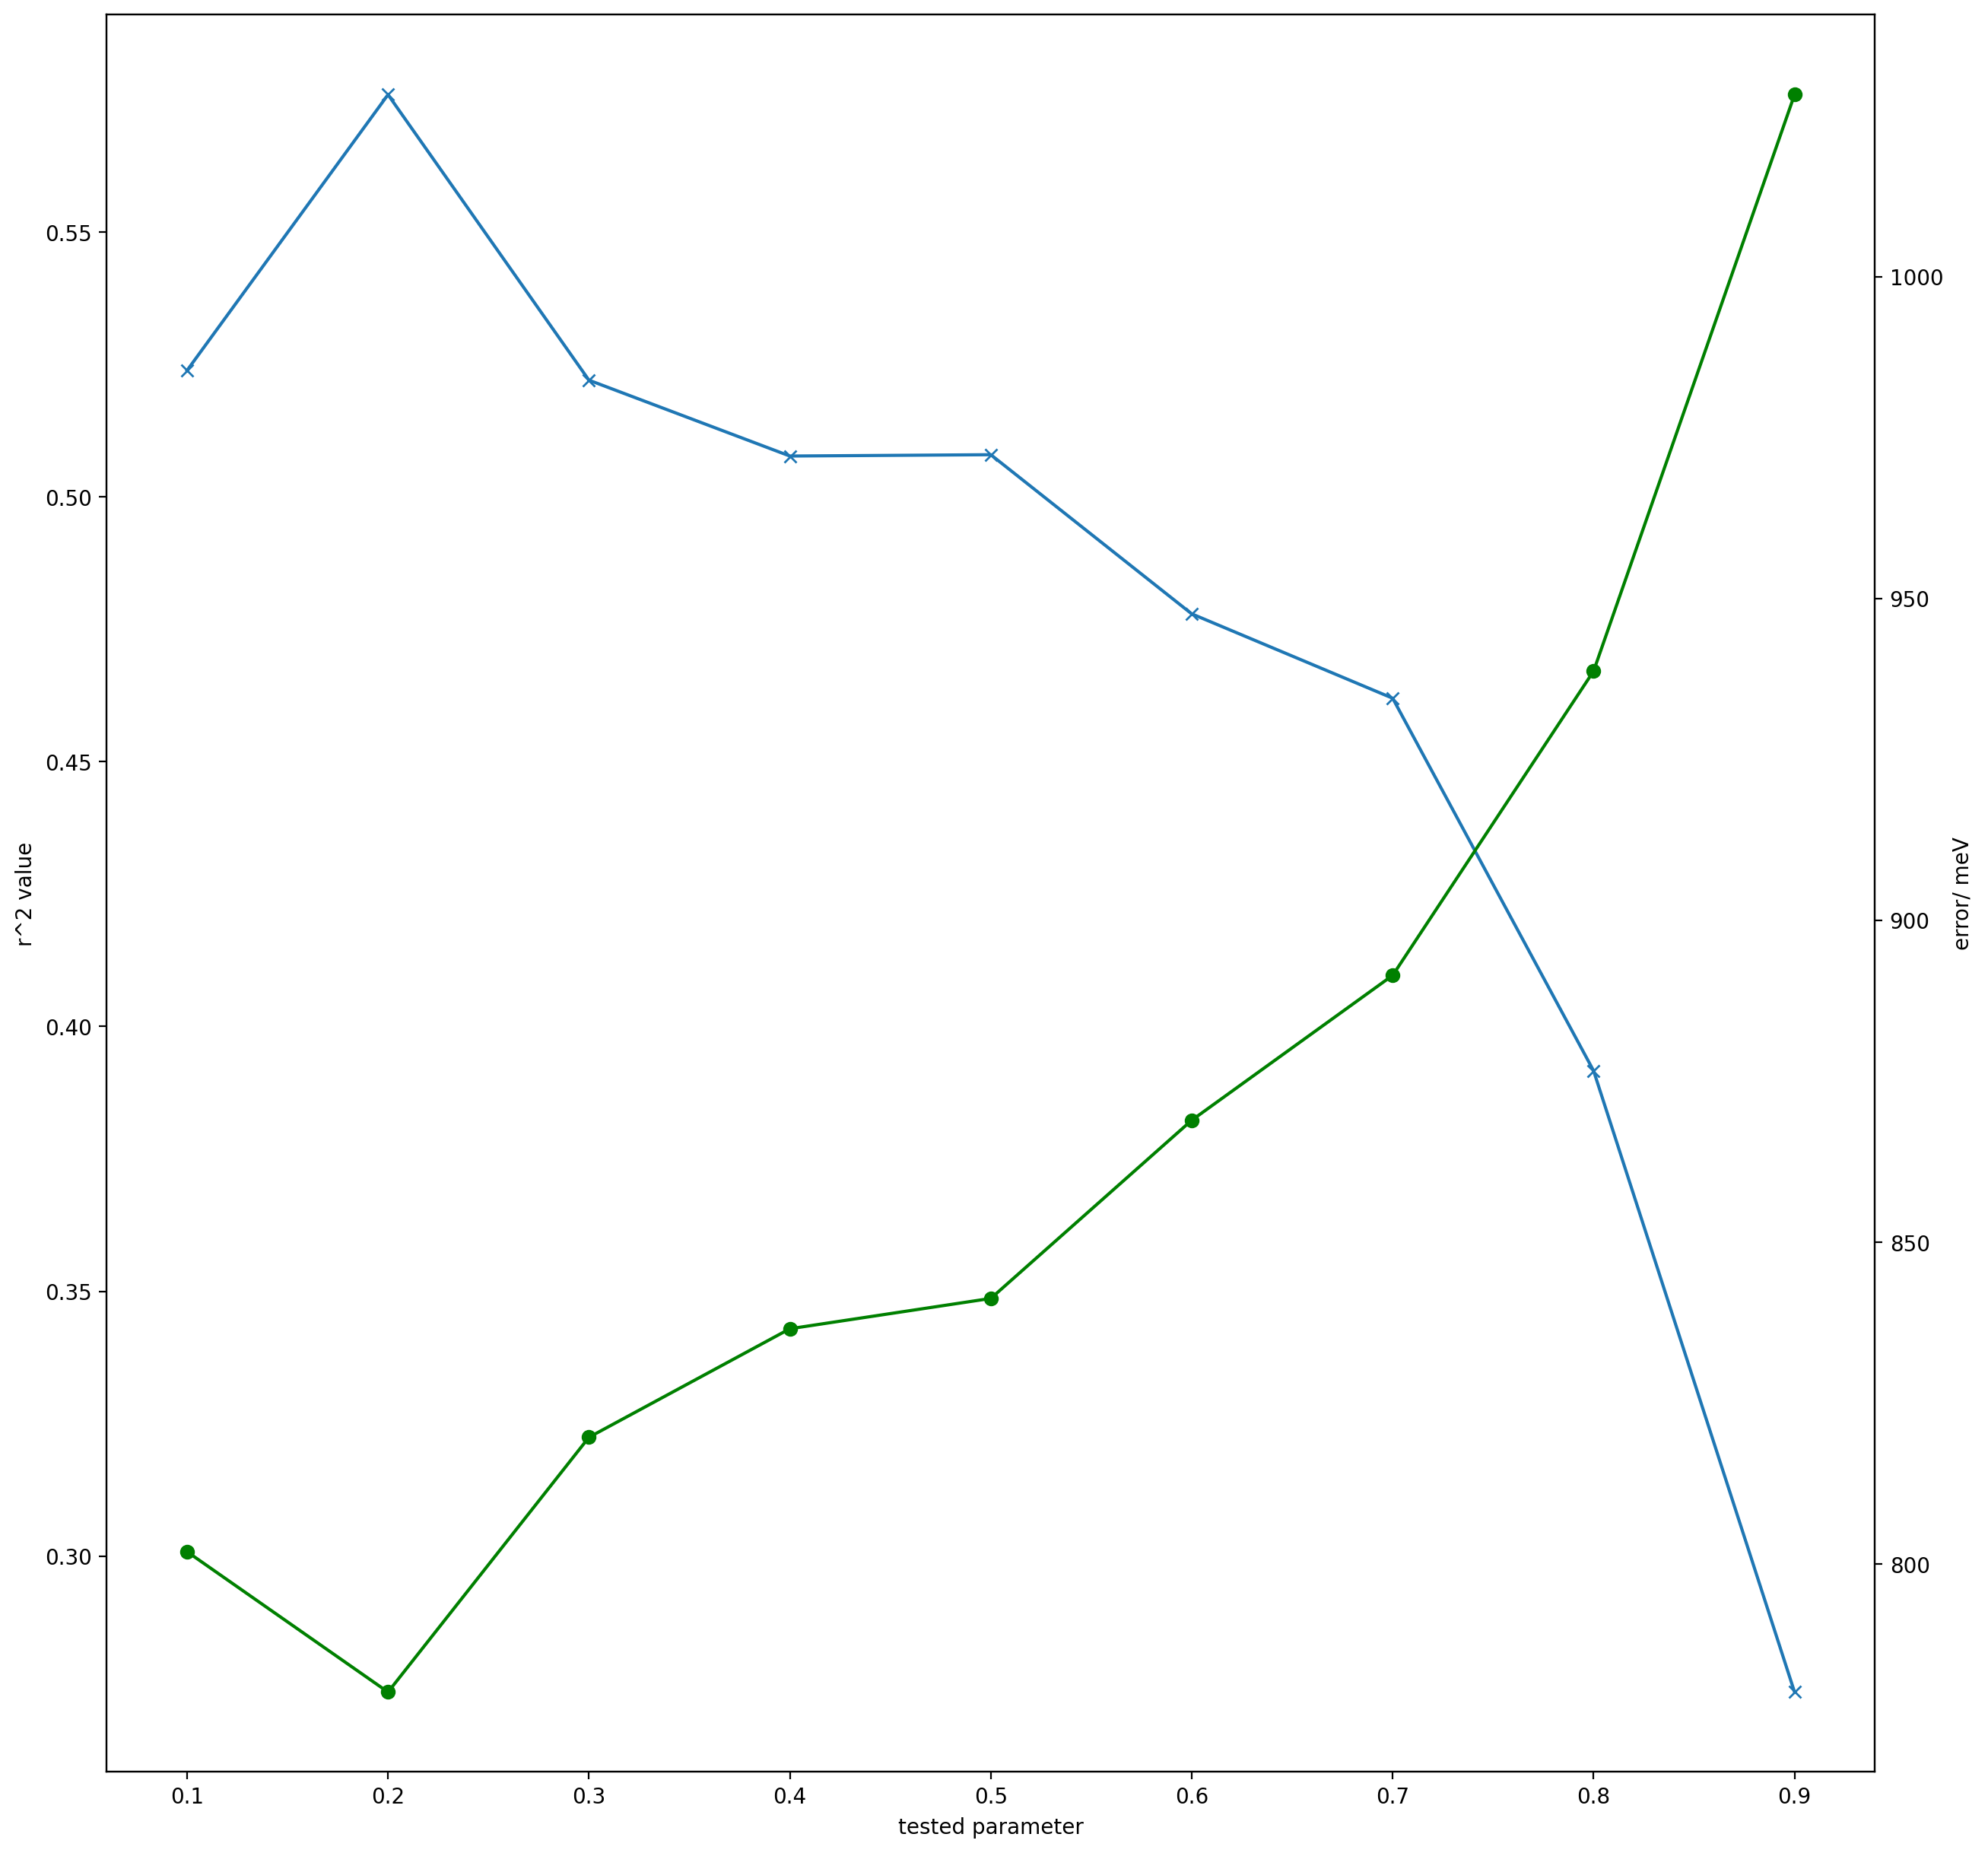

In [225]:
sizeplot(cme_lr, cme_lr['test size'])

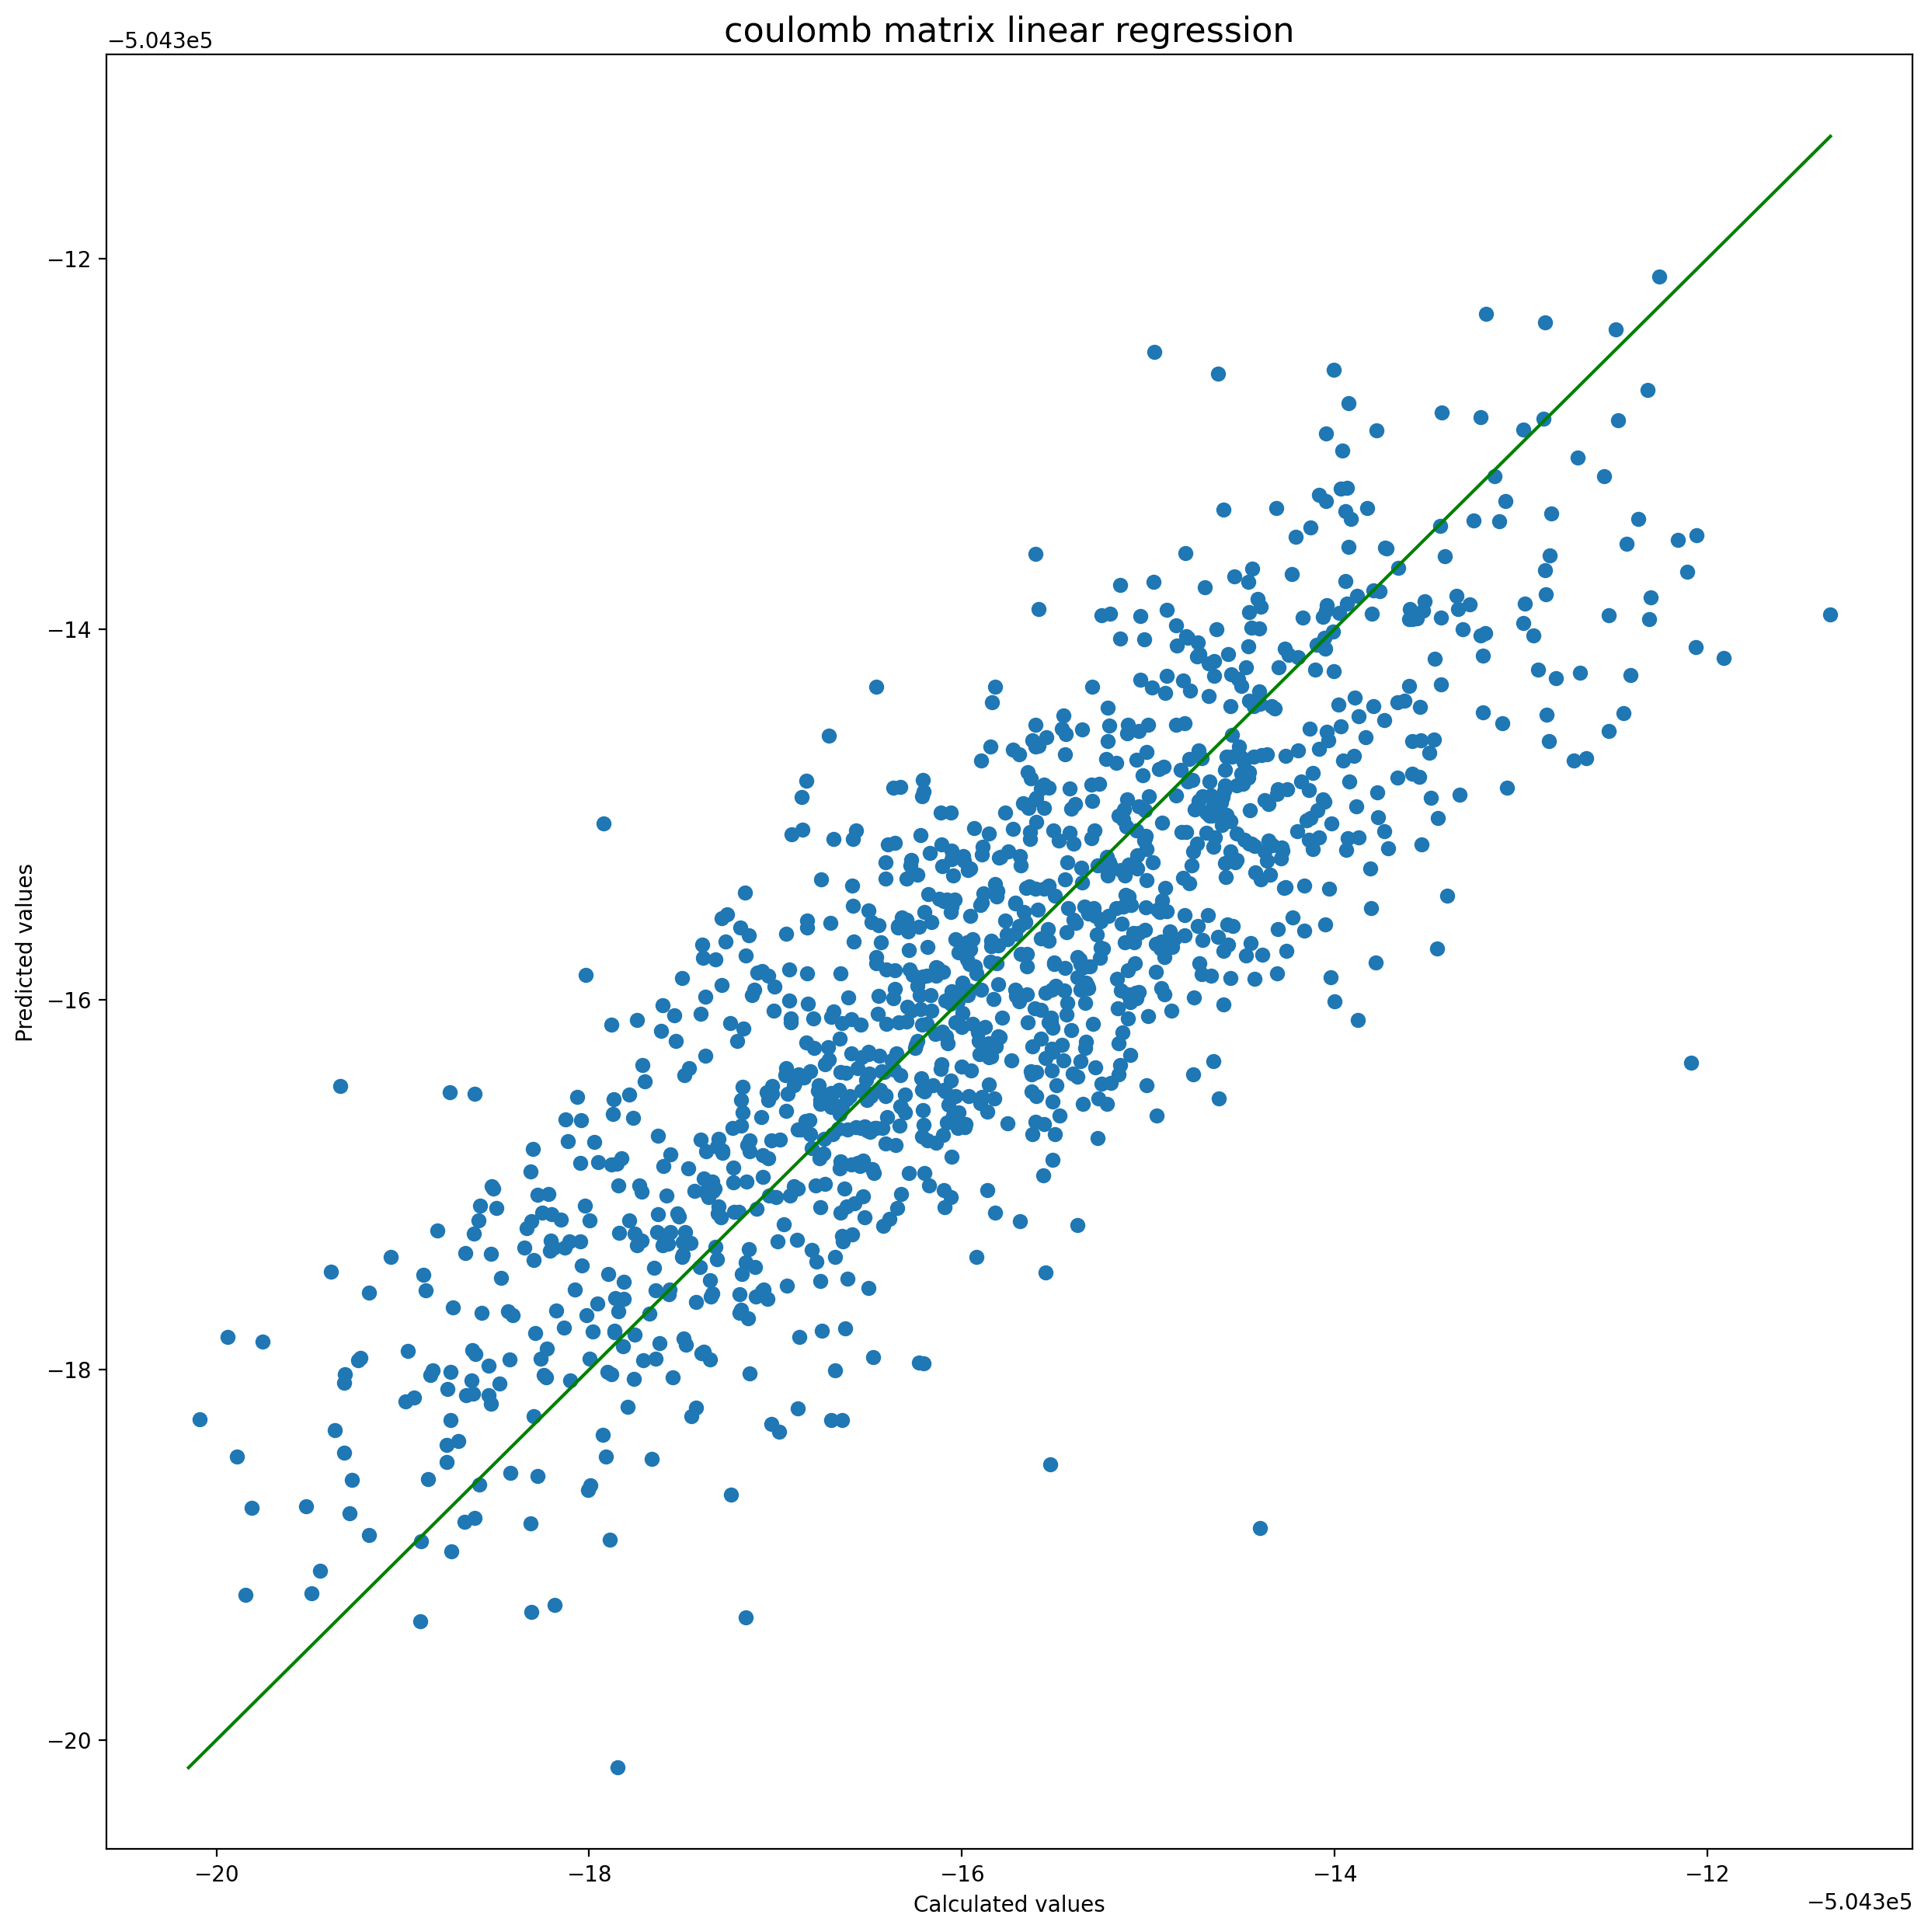

r squared value is 0.6904142098388735
mean absolute error 666.7238583637524
maximum error 4455.540882656351


In [113]:
descriptor = cm_dscribe
energies = energies_sp

X_train, X_test, y_train, y_test = train_test_split(descriptor, energies, random_state=1, test_size = 0.3)

scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

model.fit(X_train, y_train)
ypred_LR = model.predict(X_test)

errorgraph(y_test, ypred_LR, 'coulomb matrix', 'linear regression')

## Sine Matrix

In [227]:
#optimal test size for Sine Matrix (Linear regression)

descriptor = sine_dscribe
energies = energies_sp
sine_lr = trainsize(descriptor, energies, model)
    #test size: 0.1 is best

In [228]:
sine_lr

test size  r^2 value  mean absolute error  maximum error
0        0.1  -0.232102          1298.746768    6247.122652
1        0.2  -0.283556          1324.322550    8507.255984
2        0.3  -0.336781          1345.793153    7684.962287
3        0.4  -0.249137          1297.325163    7684.962287
4        0.5  -0.247636          1300.440672    8431.418858
5        0.6  -0.278739          1324.677338    8431.418858
6        0.7  -0.258134          1313.479783   11388.104439
7        0.8  -0.274728          1317.013966   11388.104439
8        0.9  -0.359297          1353.307674   11388.104439

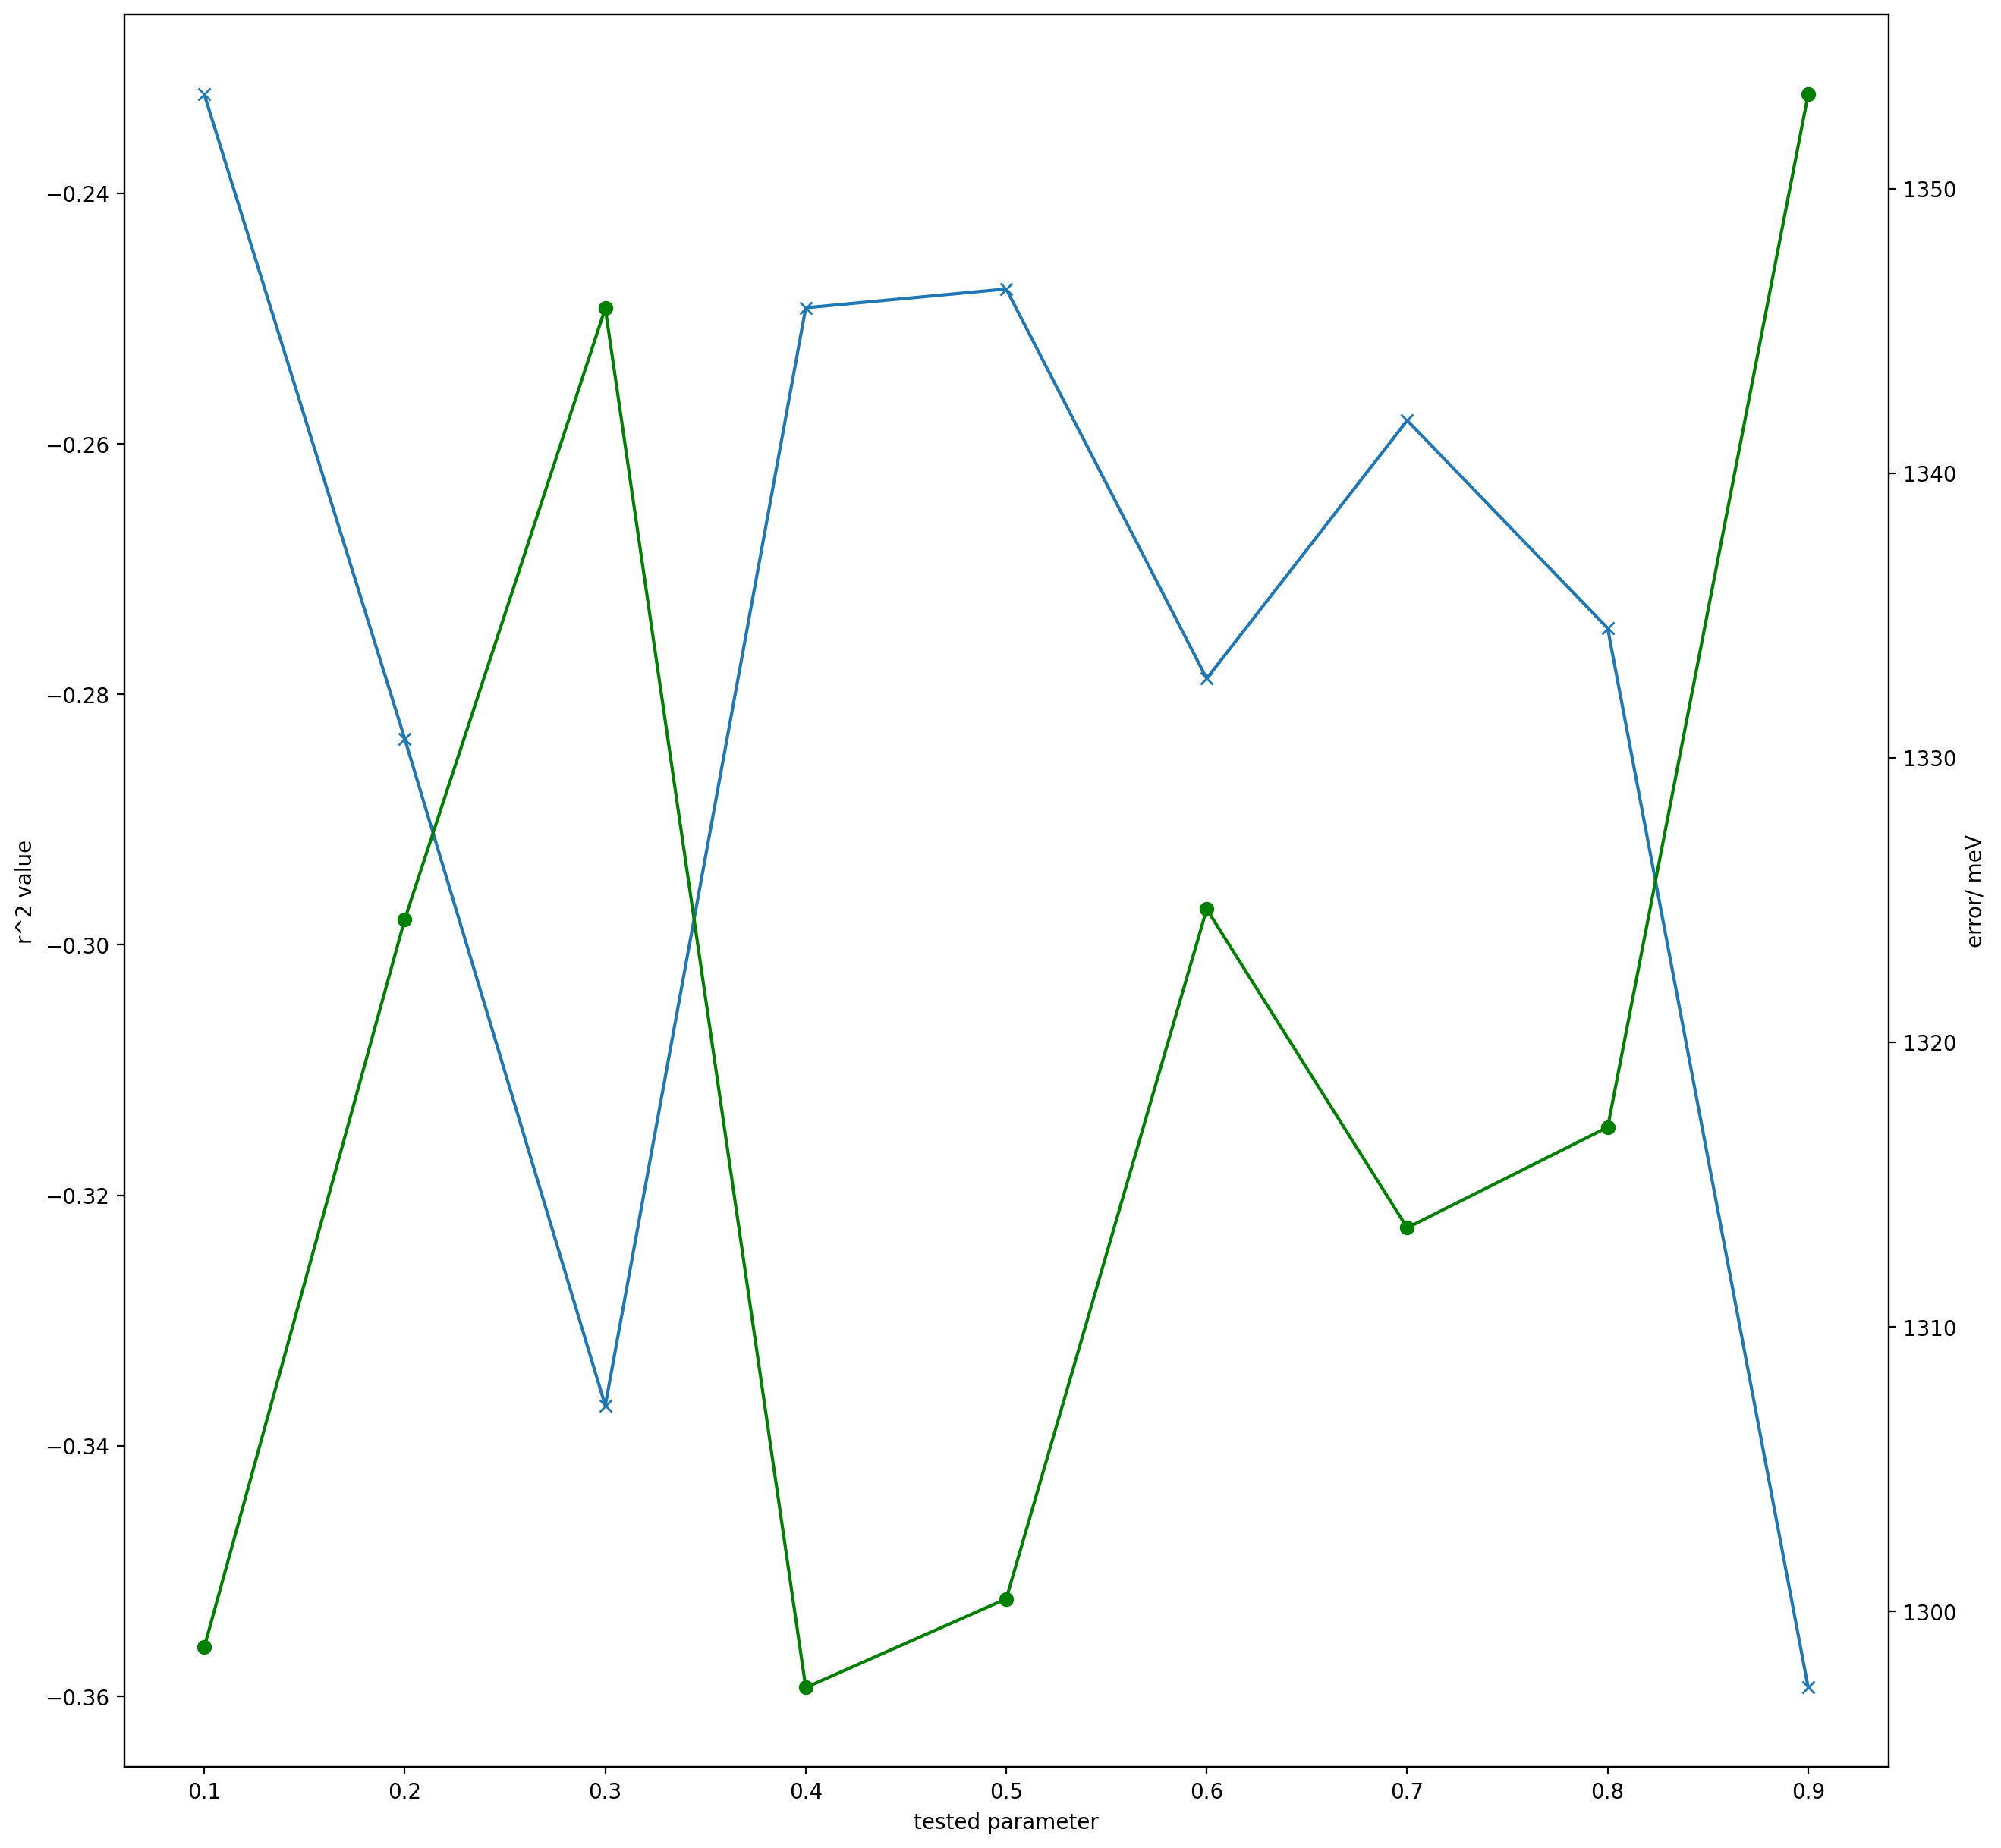

In [231]:
sizeplot(sine_lr, sine_lr['test size'])

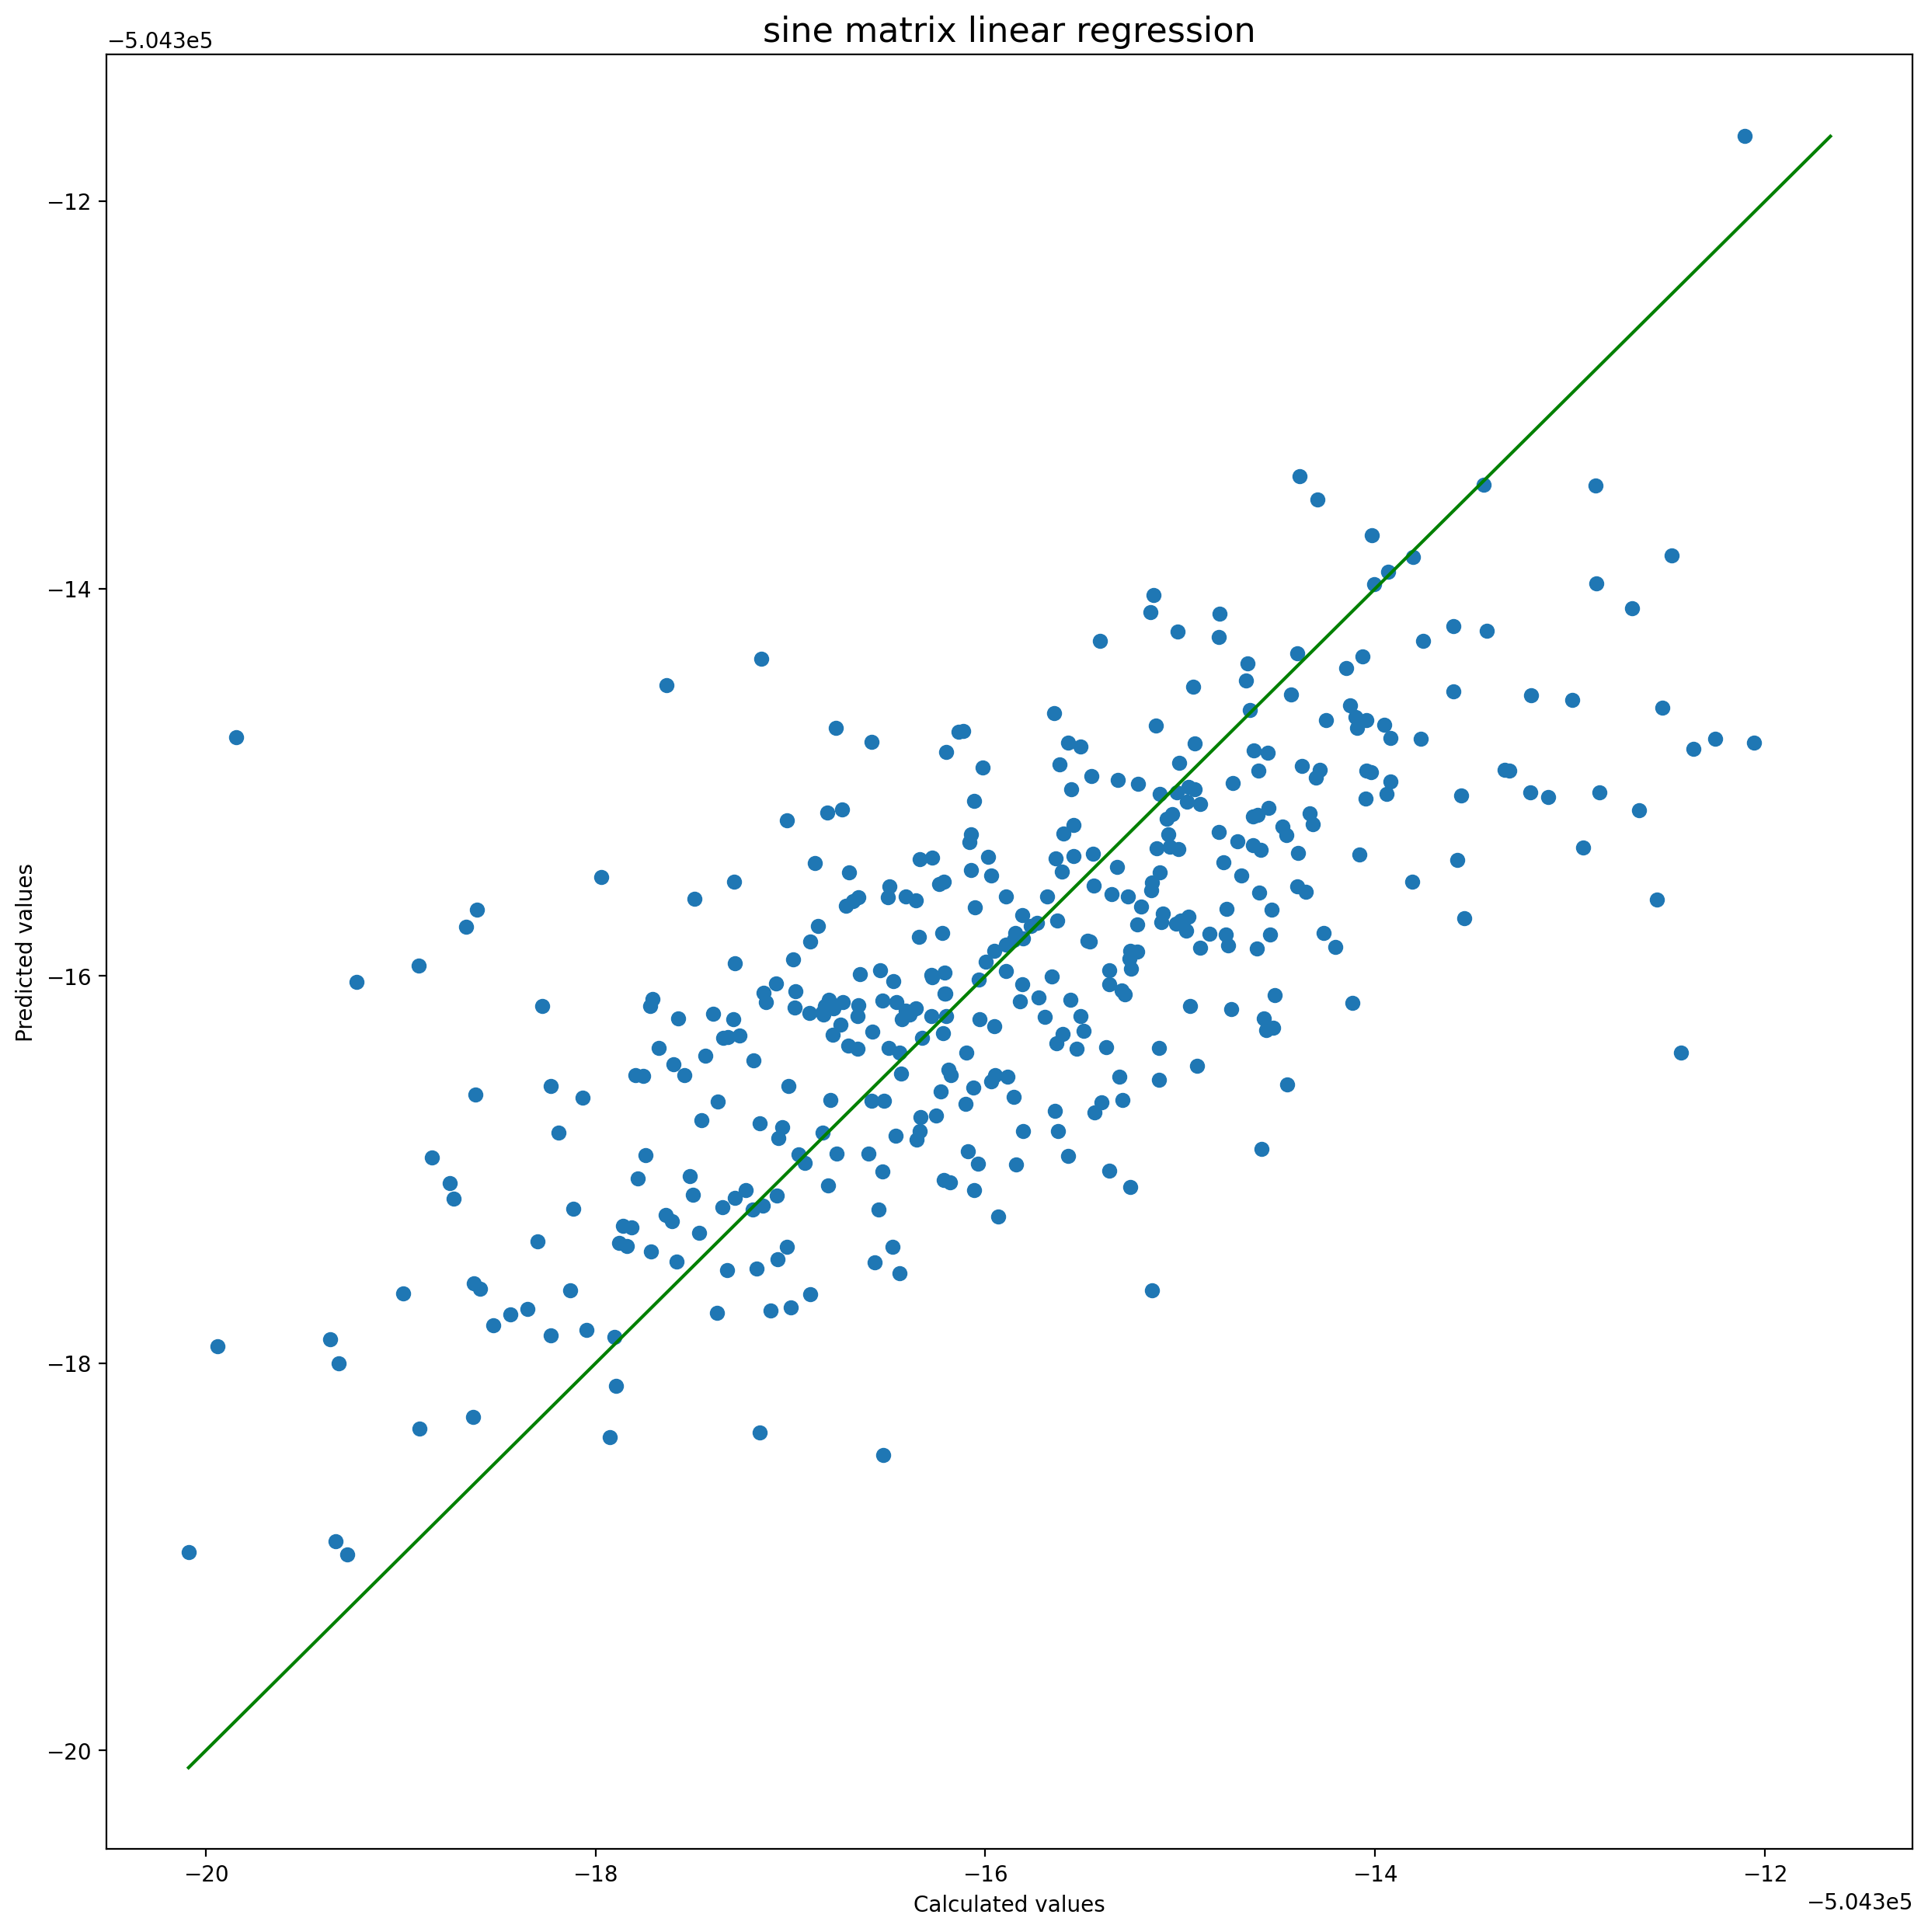

r squared value is 0.49387736057390563
mean absolute error 817.6446152487296
maximum error 5078.019468754064


In [114]:
descriptor = sine_dscribe
energies = energies_sp

X_train, X_test, y_train, y_test = train_test_split(descriptor, energies, random_state=1, test_size = 0.1)

scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

model.fit(X_train, y_train)
ypred_LR = model.predict(X_test)

errorgraph(y_test, ypred_LR, 'sine matrix', 'linear regression')

## Ewald Sum

In [232]:
#optimal test size for Ewald Sum Matrix (Linear Regression)

descriptor = ewald_dscribe
energies = energies_sp
ewald_lr = trainsize(descriptor, energies, model)
    #test size: 0.1 is best

In [233]:
ewald_lr

test size  r^2 value  mean absolute error  maximum error
0        0.1   0.770008           437.008939    3189.829990
1        0.2   0.712877           498.512700    3908.736202
2        0.3   0.683921           527.831663    3983.569202
3        0.4   0.632440           579.807369    5663.302741
4        0.5   0.572962           633.110102    6873.574642
5        0.6   0.521926           688.807347    6873.574642
6        0.7   0.470169           747.132226    7225.012470
7        0.8   0.346705           845.834412    7225.012470
8        0.9   0.194915           984.830671    6873.574642

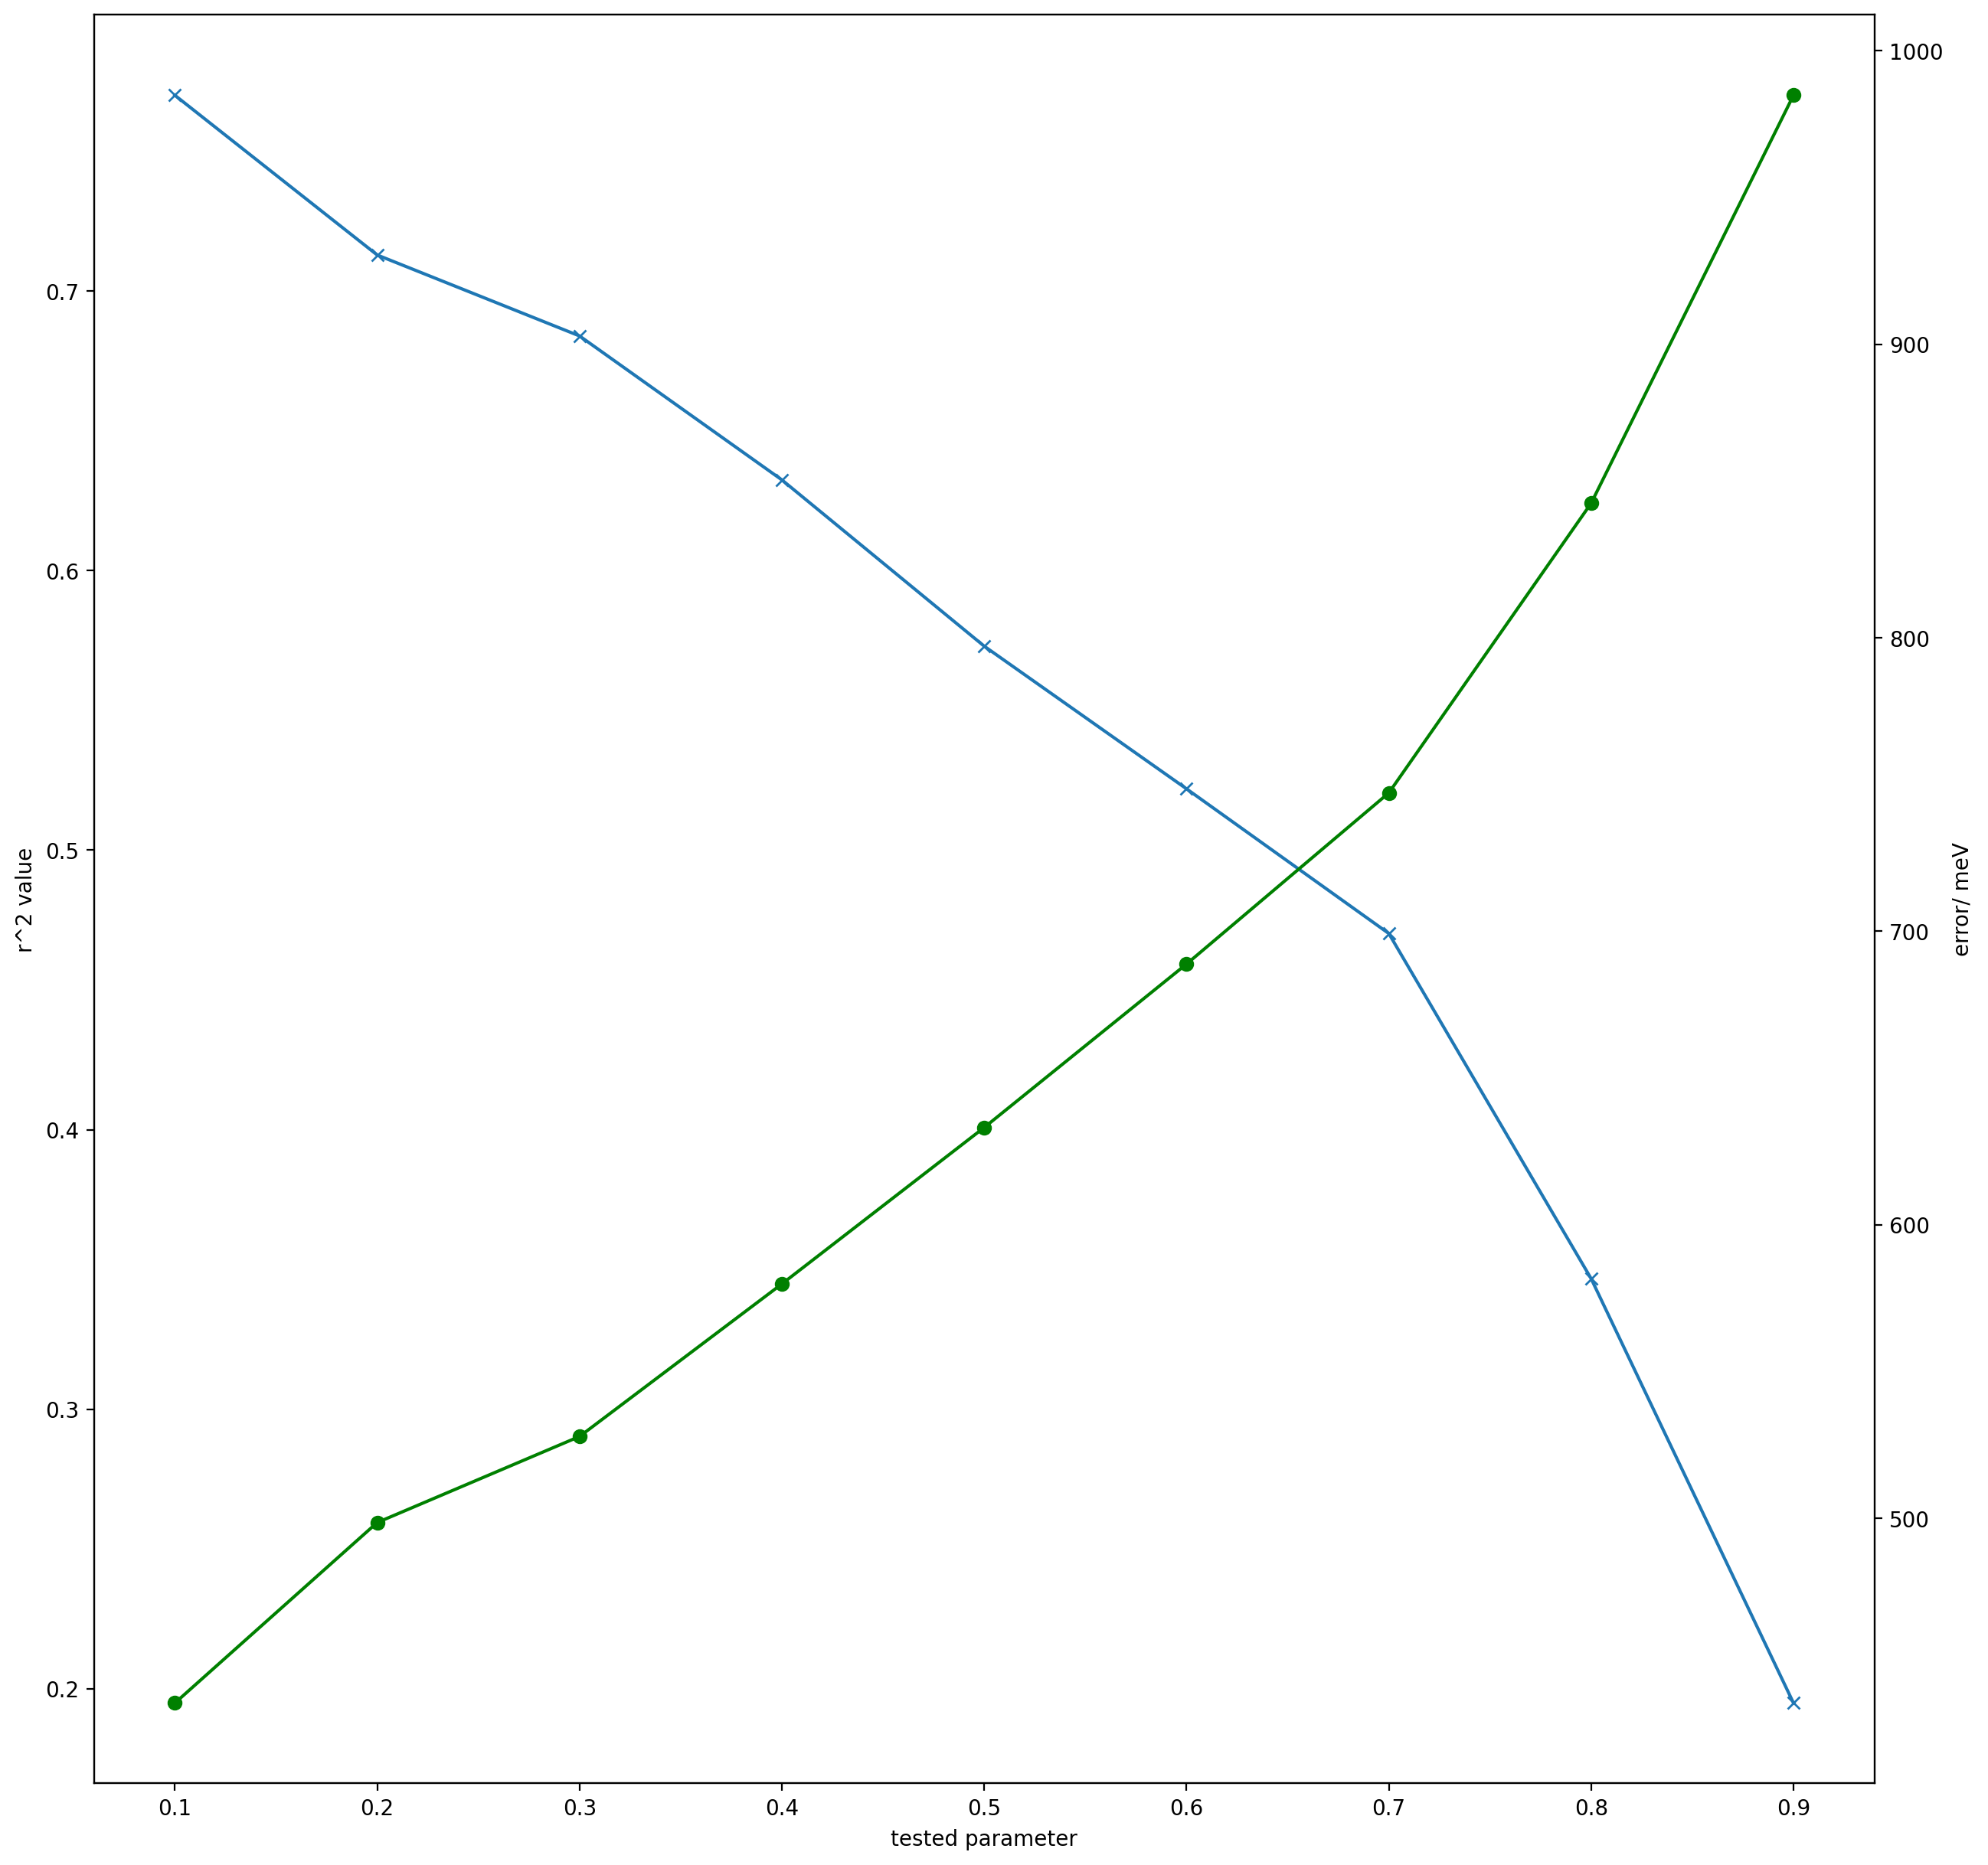

In [234]:
sizeplot(ewald_lr, ewald_lr['test size'])

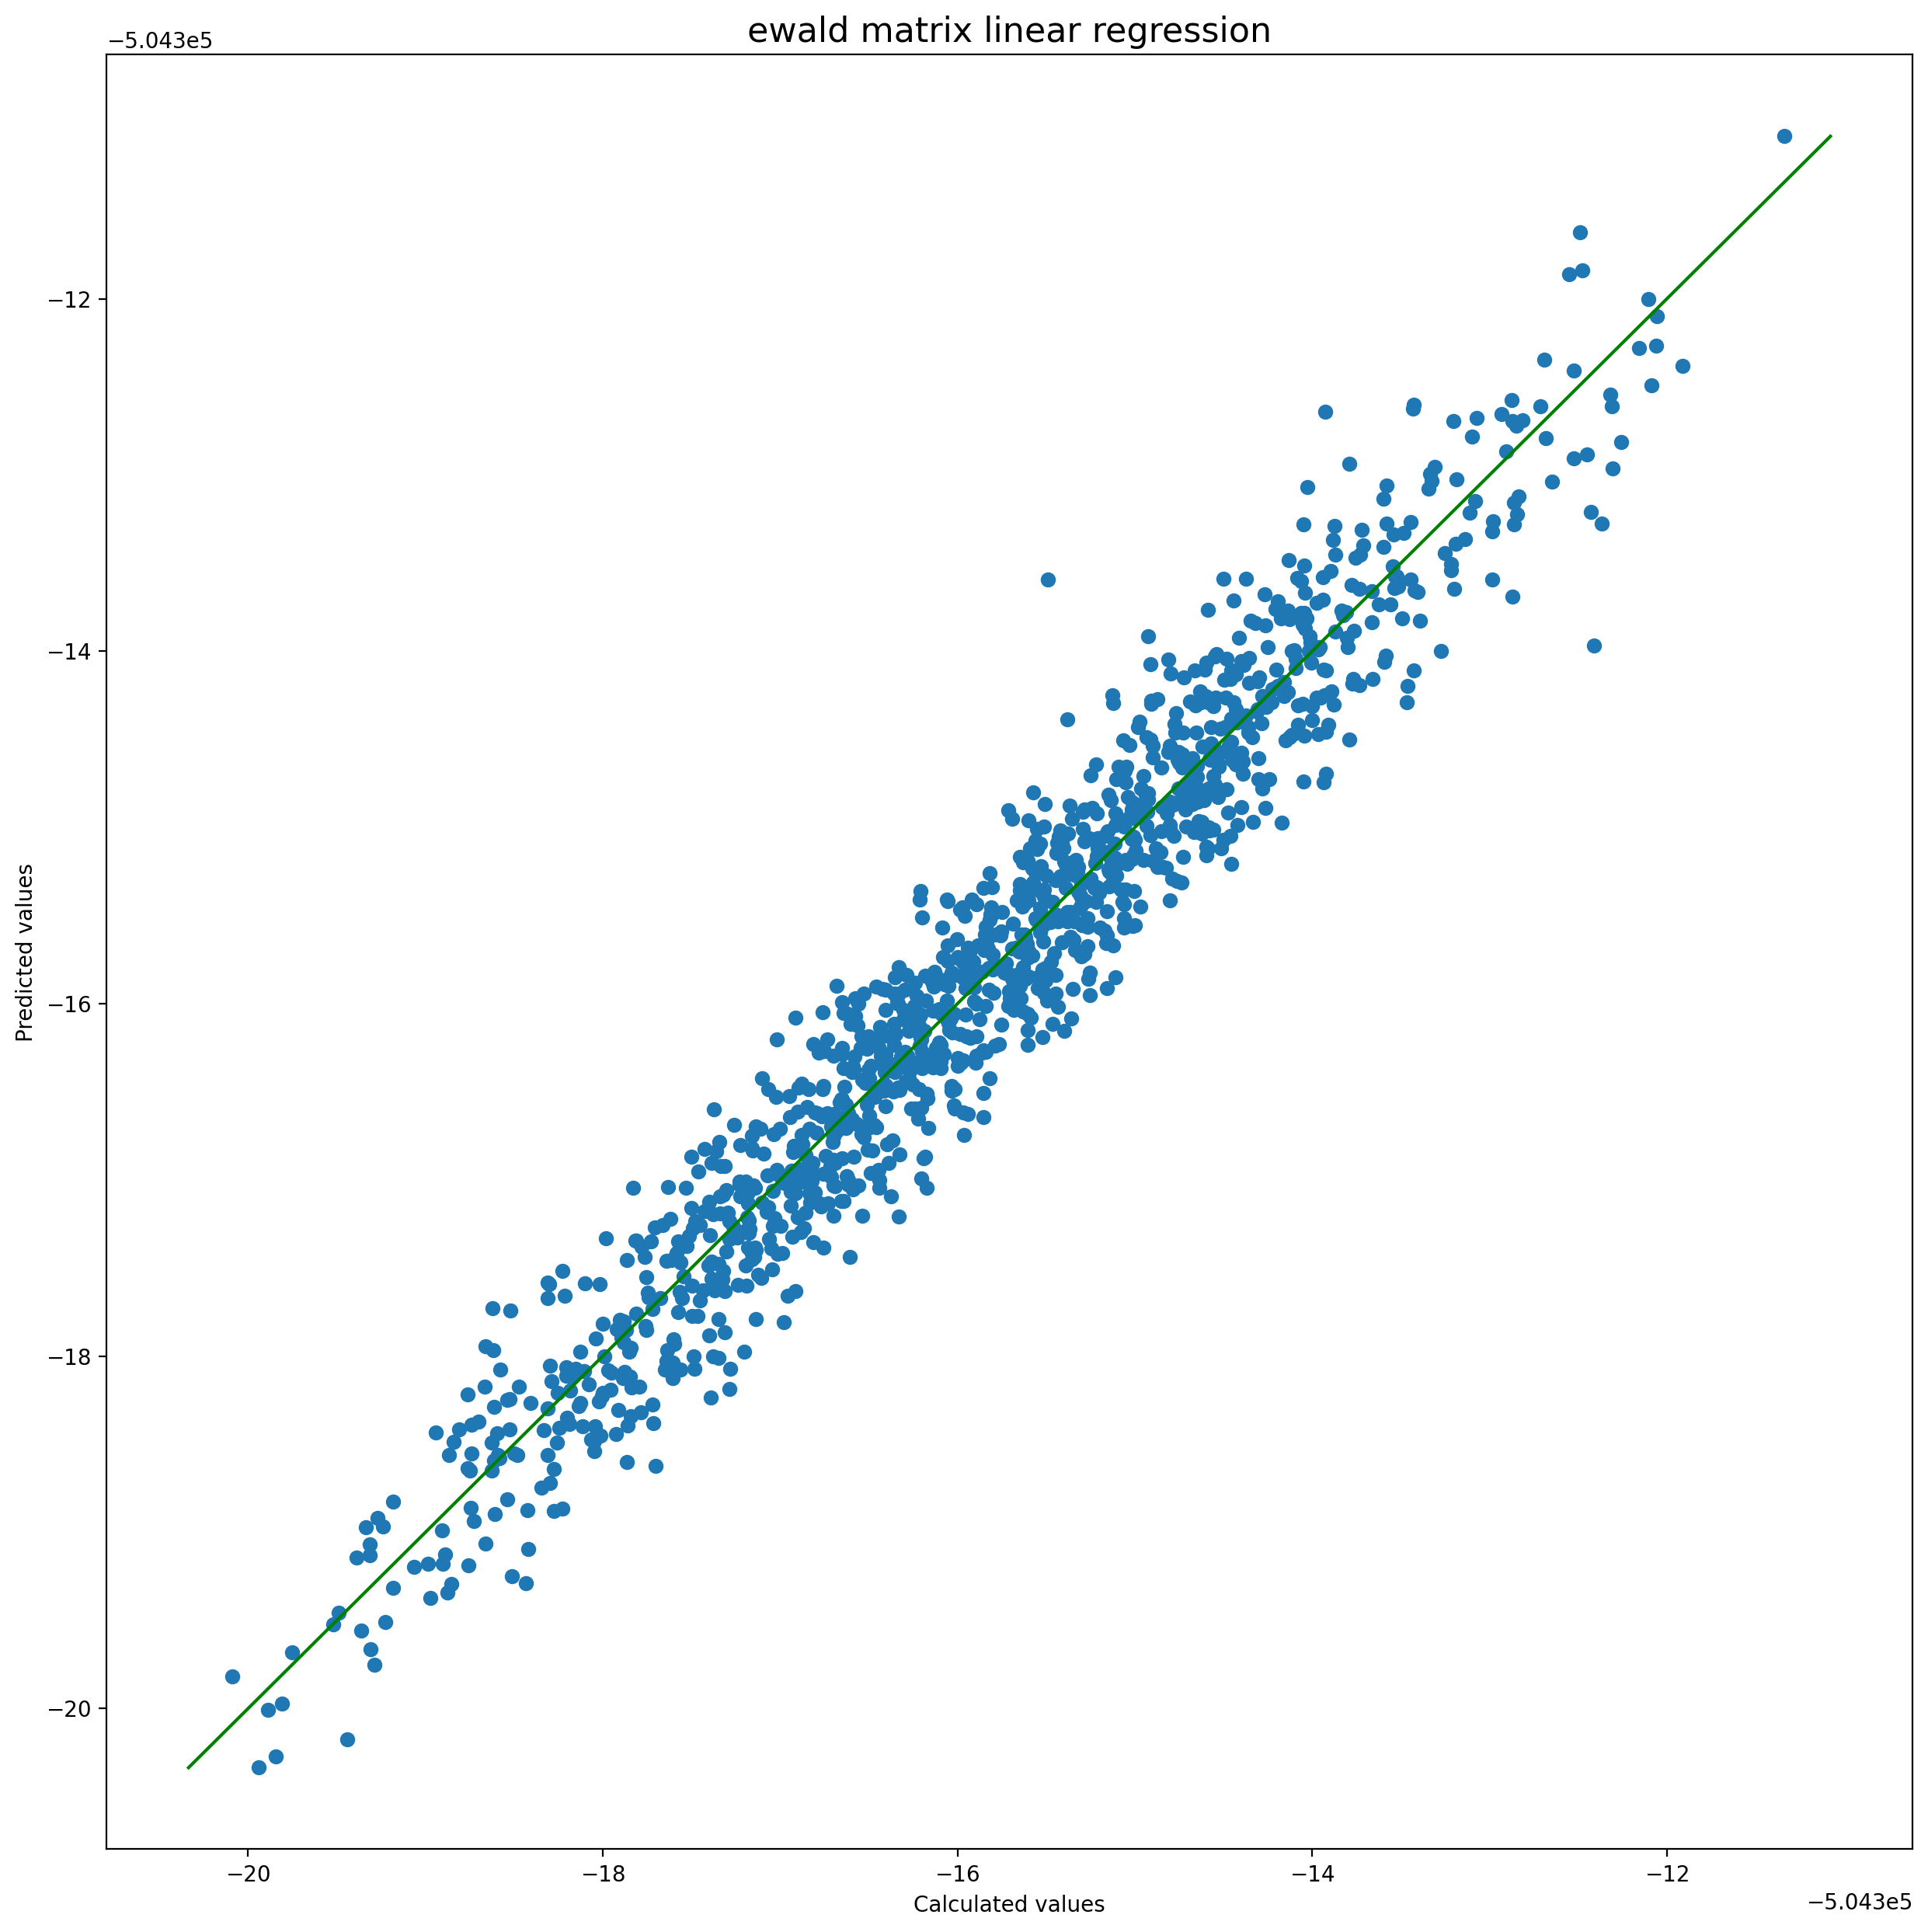

r squared value is 0.9415431640646649
mean absolute error 295.20462970960193
maximum error 1898.2584794866852


In [115]:
descriptor = ewald_dscribe
energies = energies_sp

X_train, X_test, y_train, y_test = train_test_split(descriptor, energies, random_state=1, test_size = 0.3)

scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

model.fit(X_train, y_train)
ypred_LR = model.predict(X_test)

errorgraph(y_test, ypred_LR, 'ewald matrix', 'linear regression')

## MBTR

In [235]:
#Optimal test size for MBTR (Linear Regression)
descriptor = mbtr_dscribe
energies = energies_sp
mbtr_lr = trainsize(descriptor, energies, model)
    #test size : 0.1 is best

In [236]:
mbtr_lr

test size  r^2 value  mean absolute error  maximum error
0        0.1   0.961735           220.889487    1224.388433
1        0.2   0.962733           224.903194    1215.645714
2        0.3   0.957473           232.621759    2943.035670
3        0.4   0.954862           242.727665    2943.035670
4        0.5   0.952196           251.104645    2943.035670
5        0.6   0.951347           253.677751    2943.035670
6        0.7   0.946226           267.056605    3343.330400
7        0.8   0.937534           289.153205    3474.730674
8        0.9   0.917417           334.188324    3474.730674

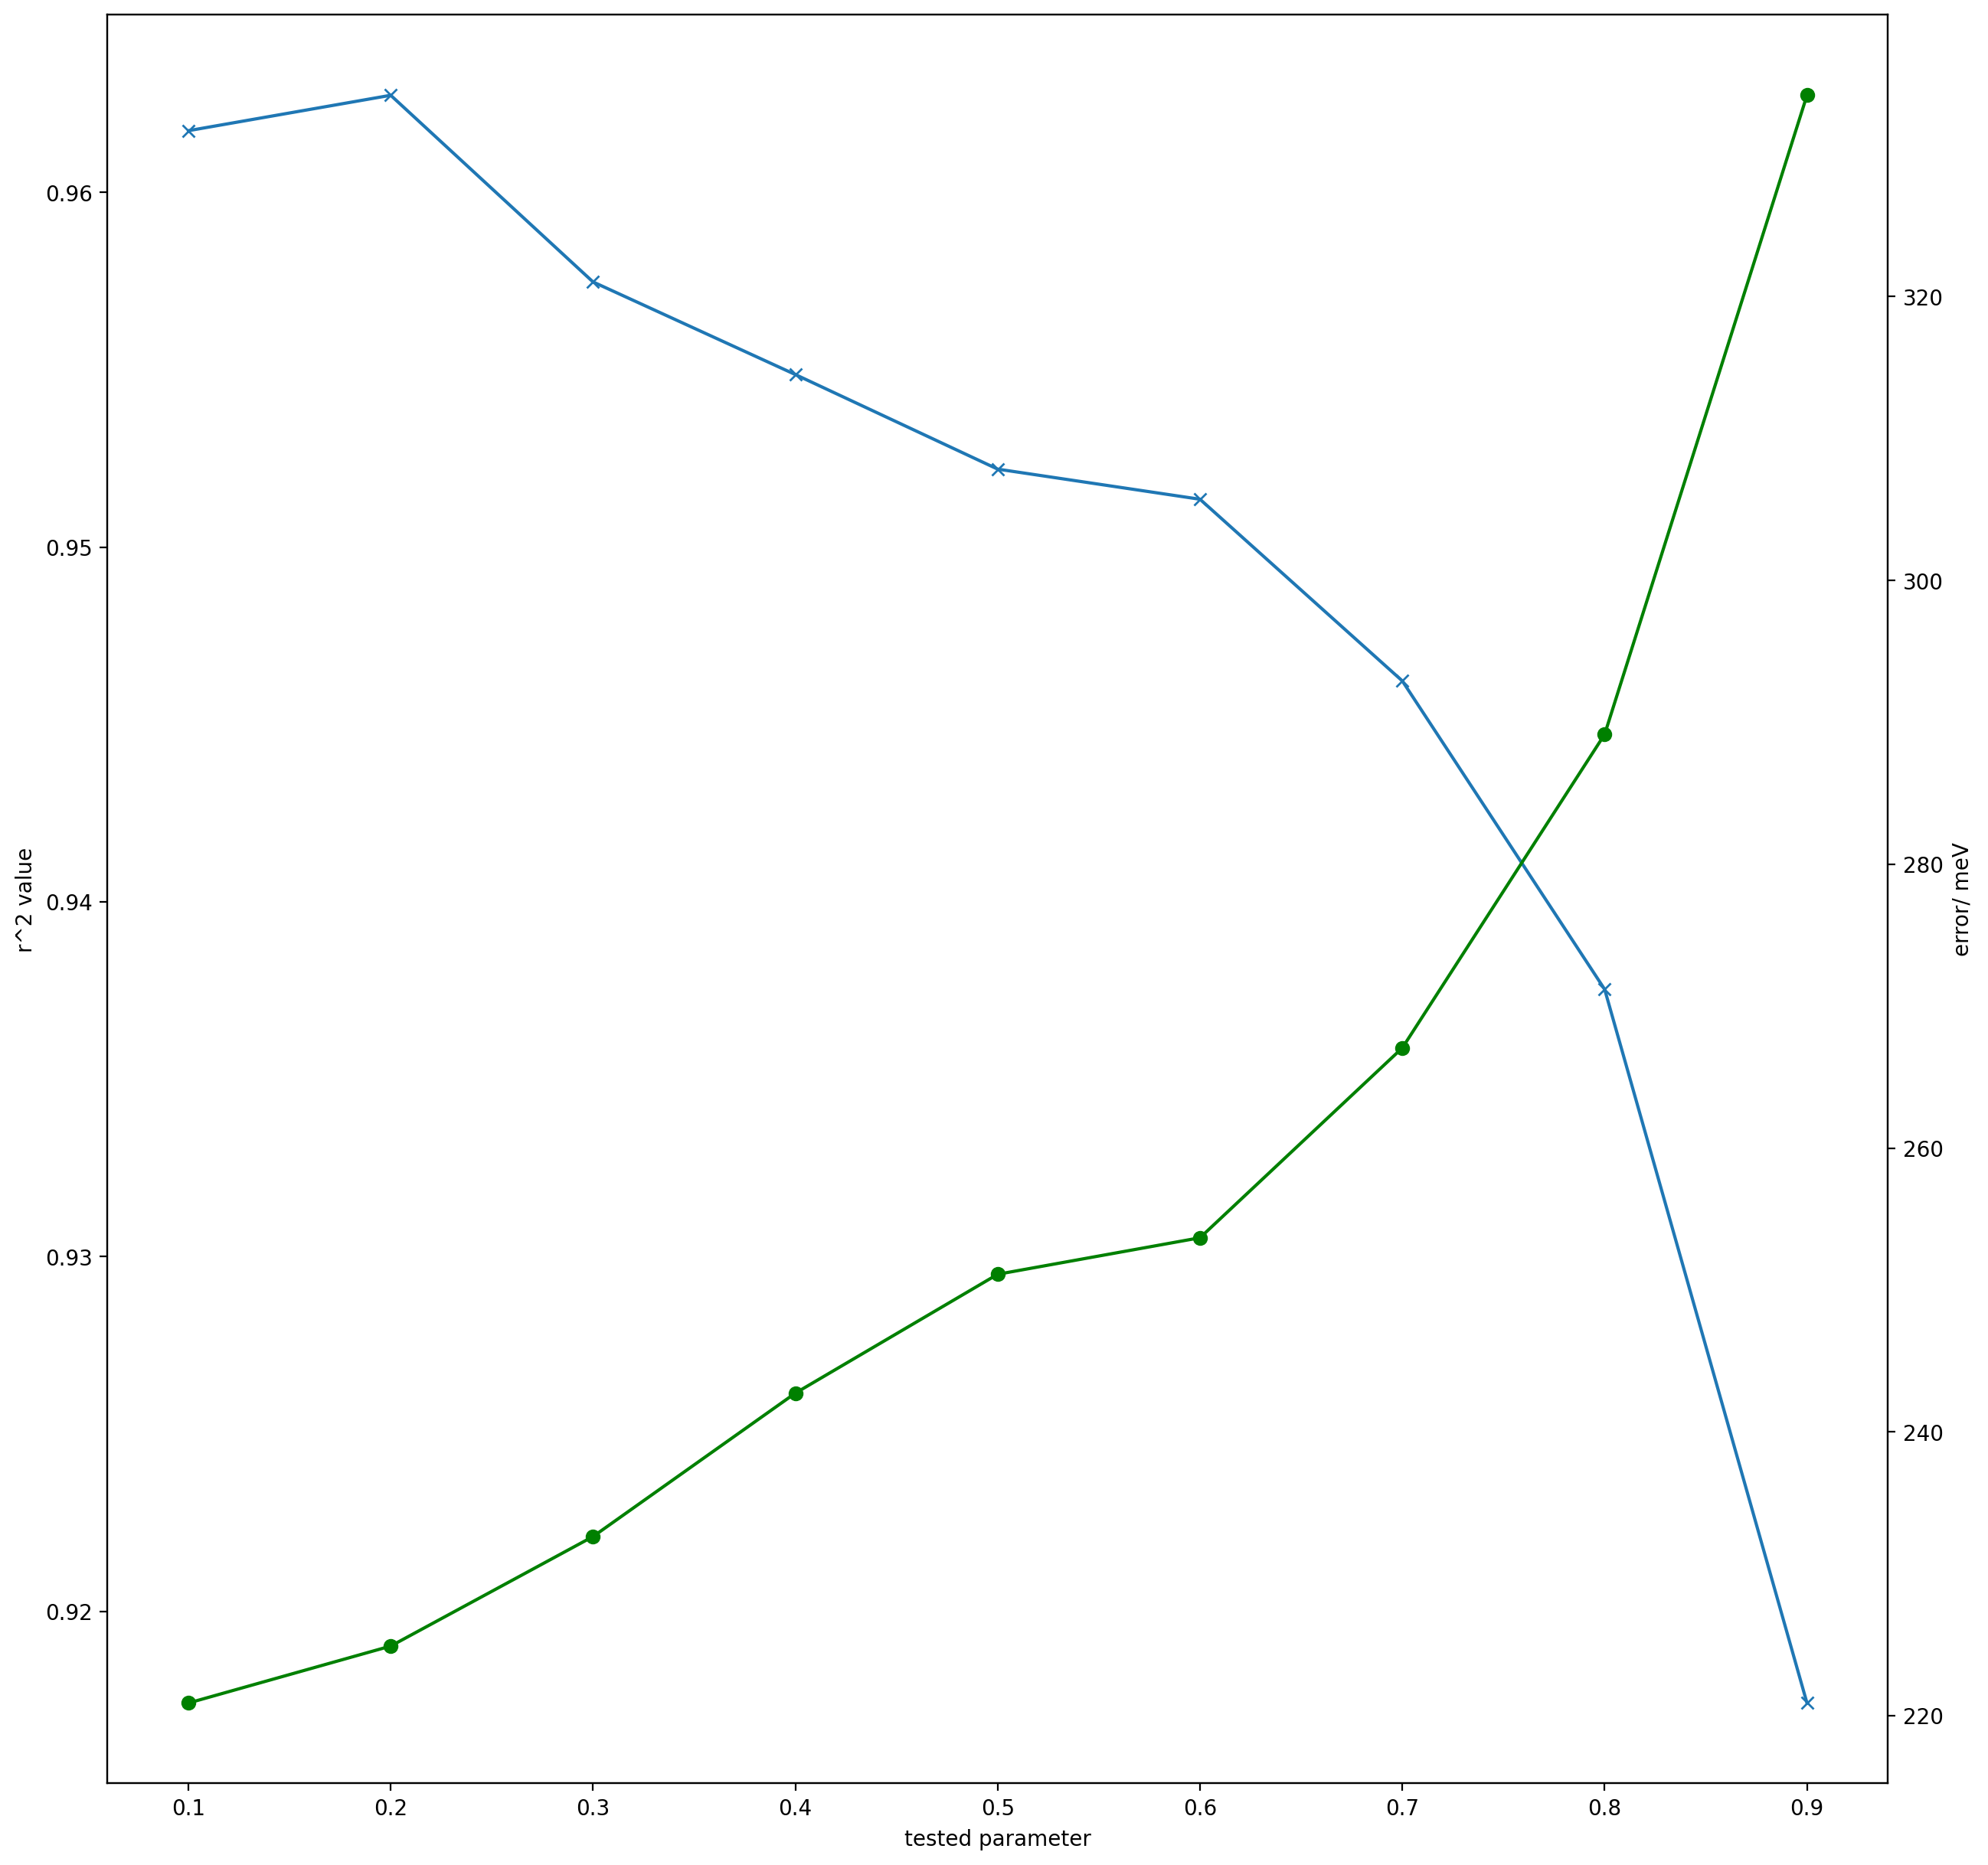

In [237]:
sizeplot(mbtr_lr, mbtr_lr['test size'])

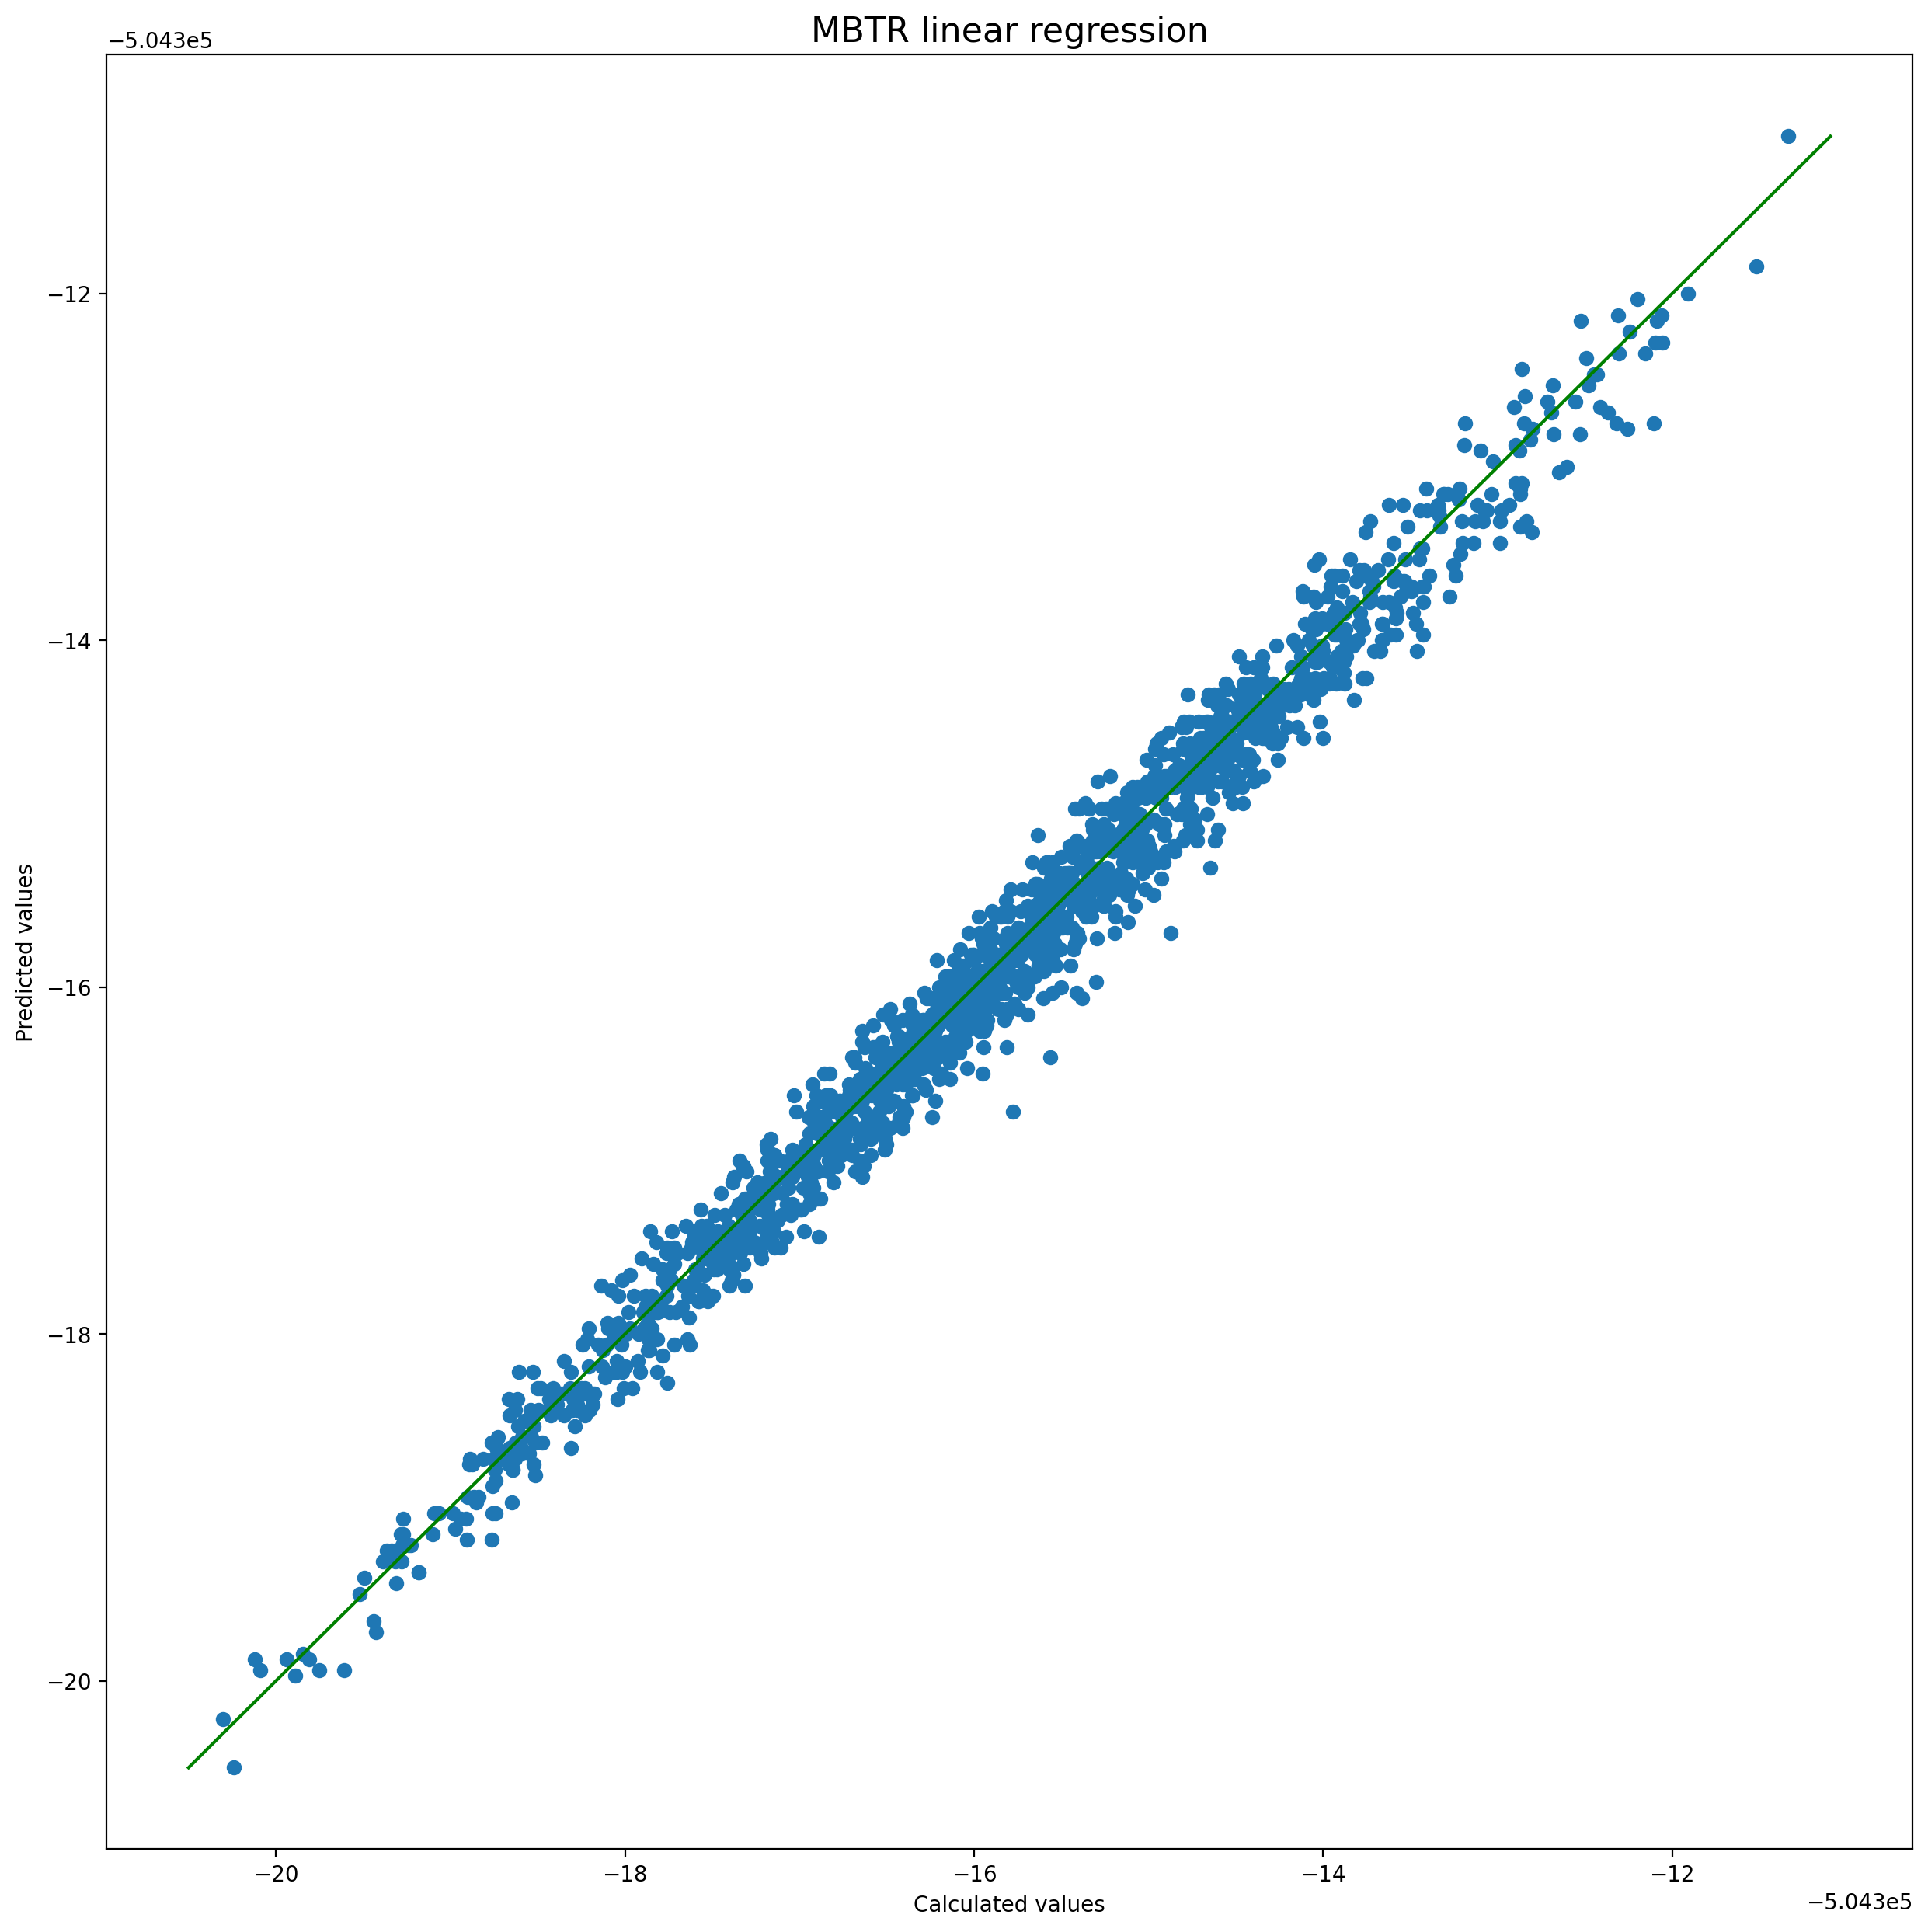

r squared value is 0.9822747154386512
mean absolute error 160.46173028924116
maximum error 941.2984483060427


In [116]:
descriptor = mbtr_dscribe
energies = energies_sp
model = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(descriptor, energies, random_state=1, test_size = 0.4)

scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

model.fit(X_train, y_train)
ypred_LR = model.predict(X_test)

errorgraph(y_test, ypred_LR, 'MBTR', 'linear regression')


In [254]:
np.min(energies_sp)

-504321.8434818838

In [255]:
np.max(energies_sp)

-504309.8595774216

In [258]:
np.argmin(energies_sp)

4022

In [257]:
np.argmax(energies_sp)

0

### <a gbdt='lr'>Gradient Boosting Decision Tree</a>

In [159]:
#setting the parameters for GBDT 
from sklearn.ensemble import GradientBoostingRegressor

params = {
          'n_estimators': 1000, #number of boosting stages to perform, the larger the better
          #'max_depth': 4,  #limitation for the number of nodes in each tree
          #'min_samples_split': 5, #the minimum number of samples required to split a node
          'learning_rate': 0.01,
          'loss': 'absolute_error'} #loss function that is optimised
model = GradientBoostingRegressor(**params)

#there is a trade off between learning rate and n_estimators
    #have tried several values and the default is the best

In [ ]:
#testing the parameters for GBDT
from functions import GBDT_ParaT

## CM

In [166]:
descriptor = cm_dscribe
energies = energies_sp

trainsize(descriptor, energies, model)
    #test set 0.3 is the best

test size  r^2 value  mean absolute error  maximum error
0        0.1   0.712667           621.957707    3151.469430
1        0.2   0.732937           612.243779    3255.815982
2        0.3   0.723360           611.377643    3915.909371
3        0.4   0.726000           612.798618    3983.276161
4        0.5   0.719601           622.756116    4258.228950
5        0.6   0.703583           643.771982    4214.618397
6        0.7   0.683656           667.224641    4568.794953
7        0.8   0.650797           700.807095    5170.518721
8        0.9   0.582763           774.011580    5216.089074

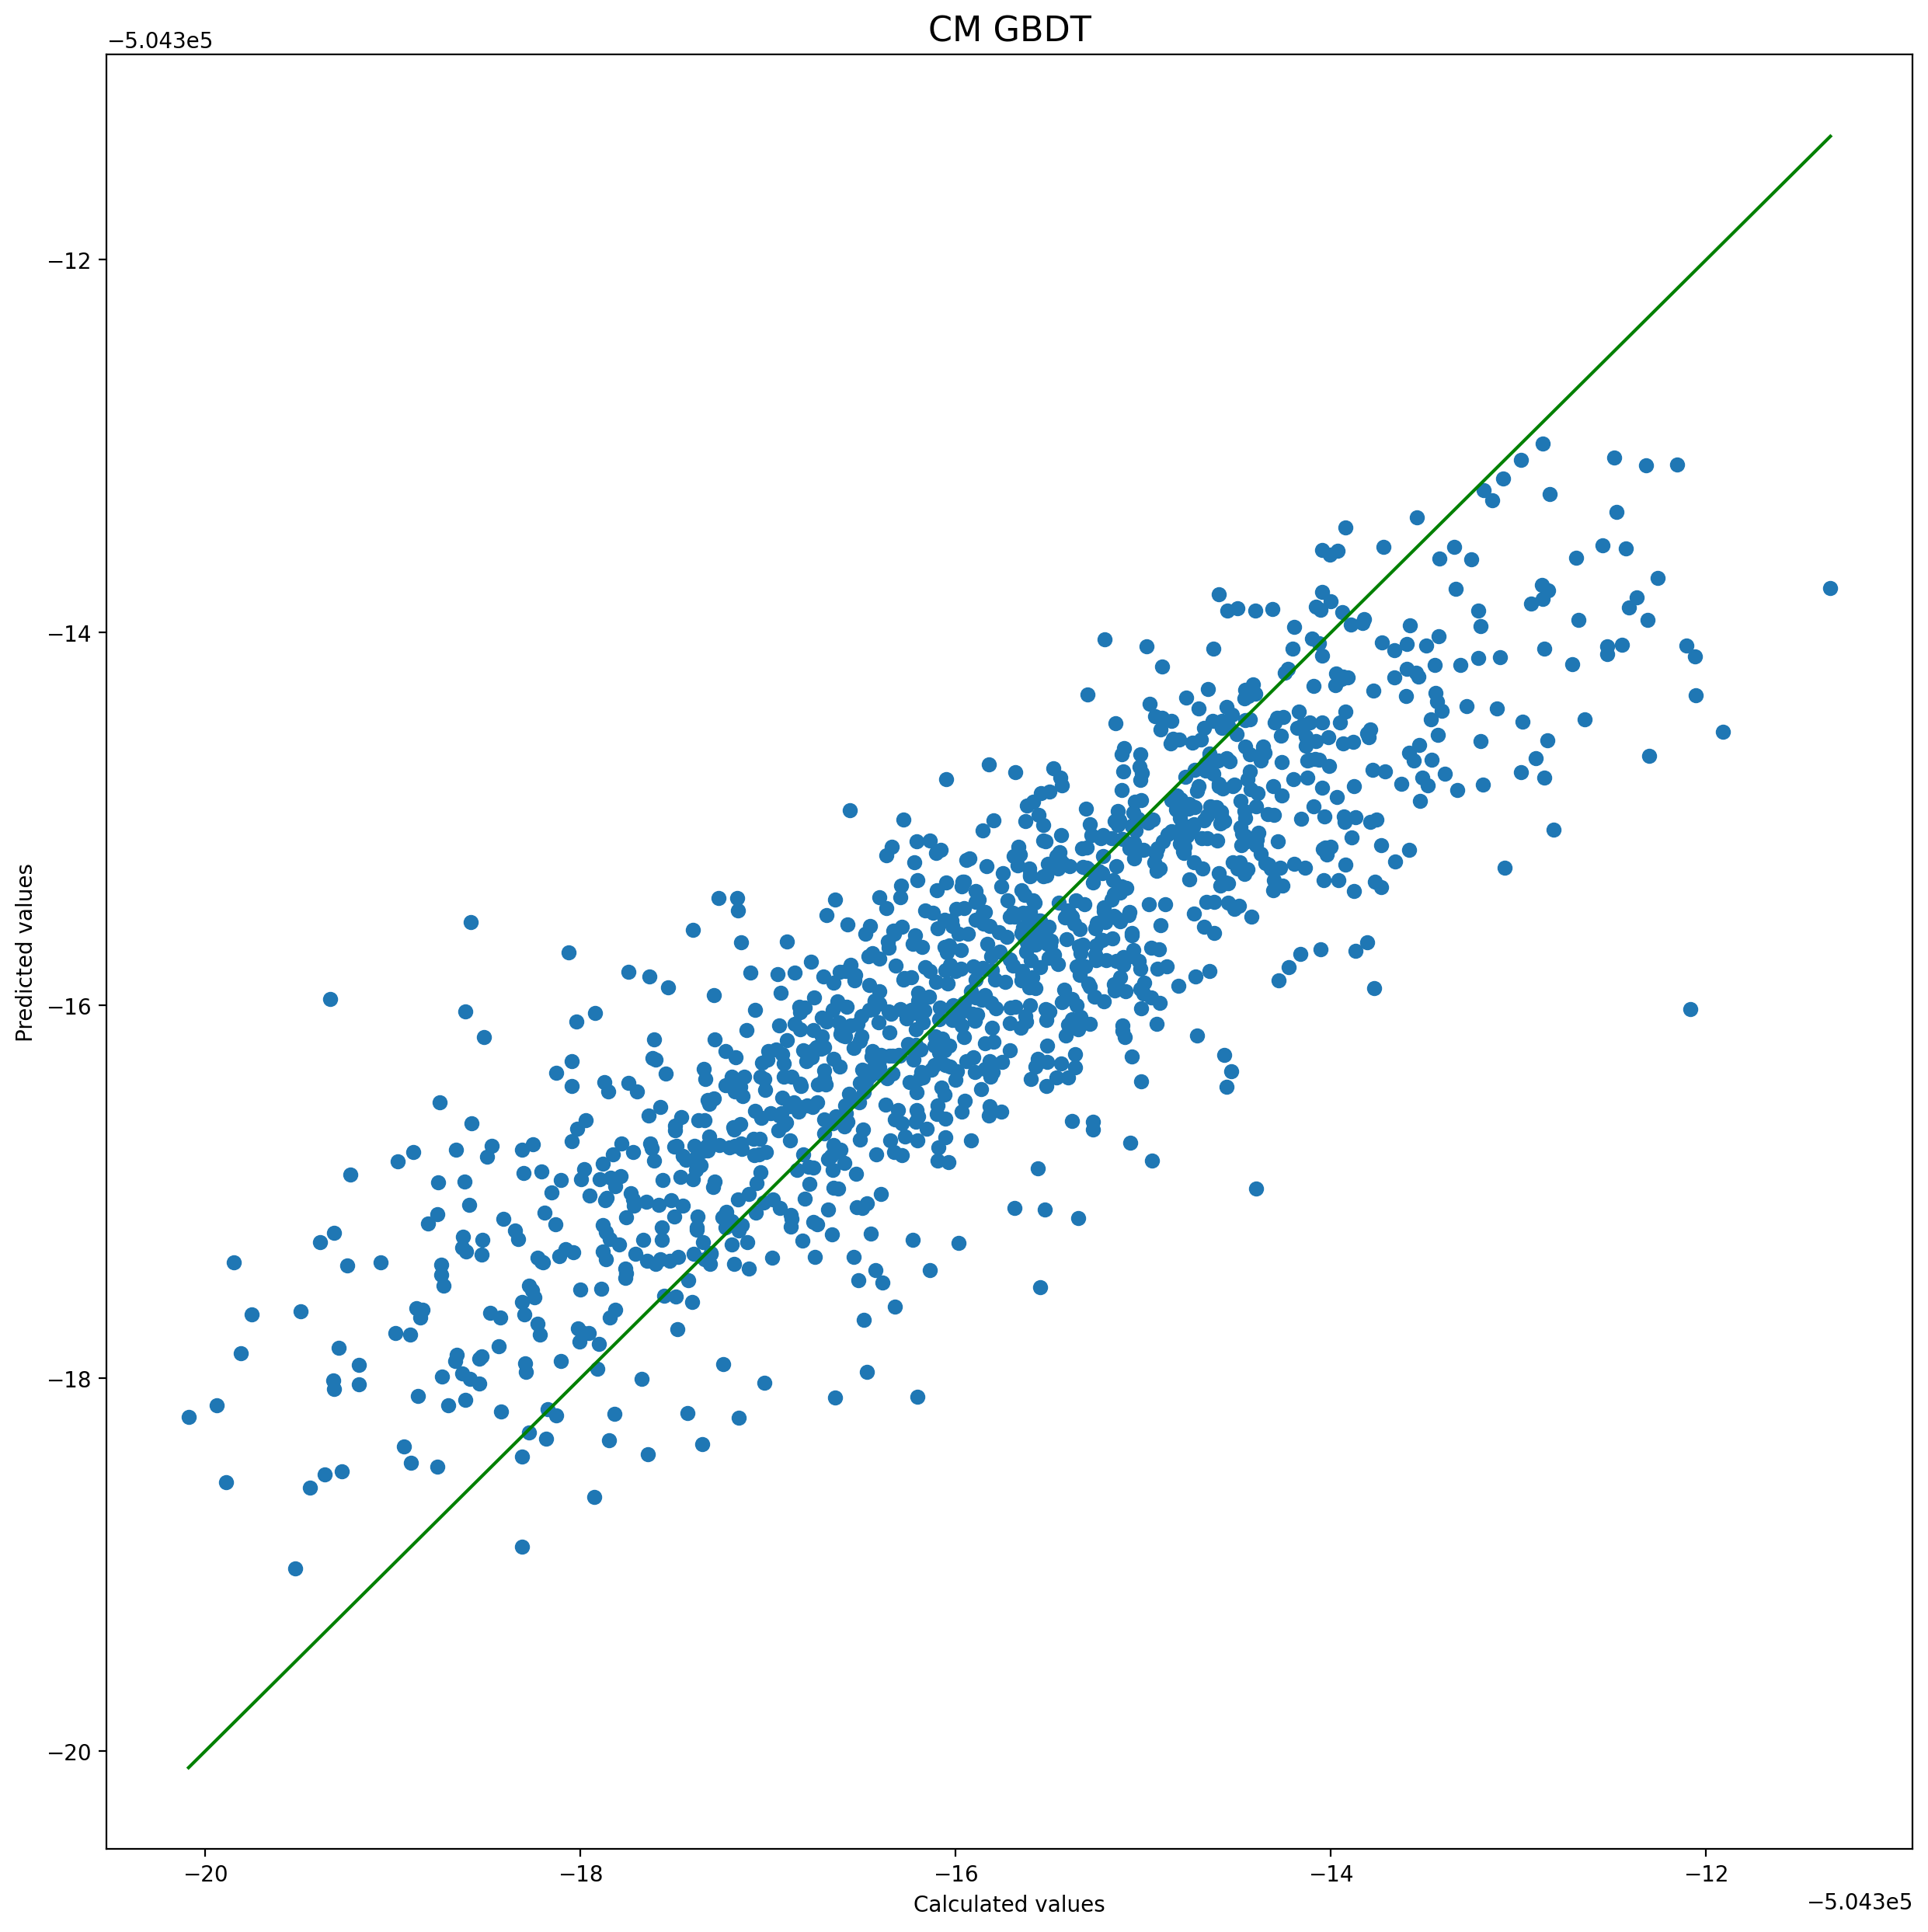

r squared value is 0.7242707532878696
mean absolute error 611.5668869276714
maximum error 3934.878187952563


In [168]:
X_train, X_test, y_train, y_test = train_test_split(descriptor, energies, random_state=1, test_size = 0.3)

scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

model.fit(X_train, y_train)
ypred = model.predict(X_test)

errorgraph(y_test, ypred, 'CM', 'GBDT')

### Sine Matrix

In [169]:
descriptor = sine_dscribe
energies = energies_sp

trainsize(descriptor, energies, model)


test size  r^2 value  mean absolute error  maximum error
0        0.1   0.439675           882.828591    4835.622173
1        0.2   0.420208           911.297095    5070.247221
2        0.3   0.388106           930.434573    4811.193804
3        0.4   0.403364           924.972116    4835.013834
4        0.5   0.386758           943.038181    6429.578888
5        0.6   0.375779           944.128483    5878.181754
6        0.7   0.359636           959.562938    8548.612537
7        0.8   0.330343           976.566081    8032.144650
8        0.9   0.308162           989.956991    8800.459102

In [174]:
descriptor = sine_dscribe
energies = energies_sp

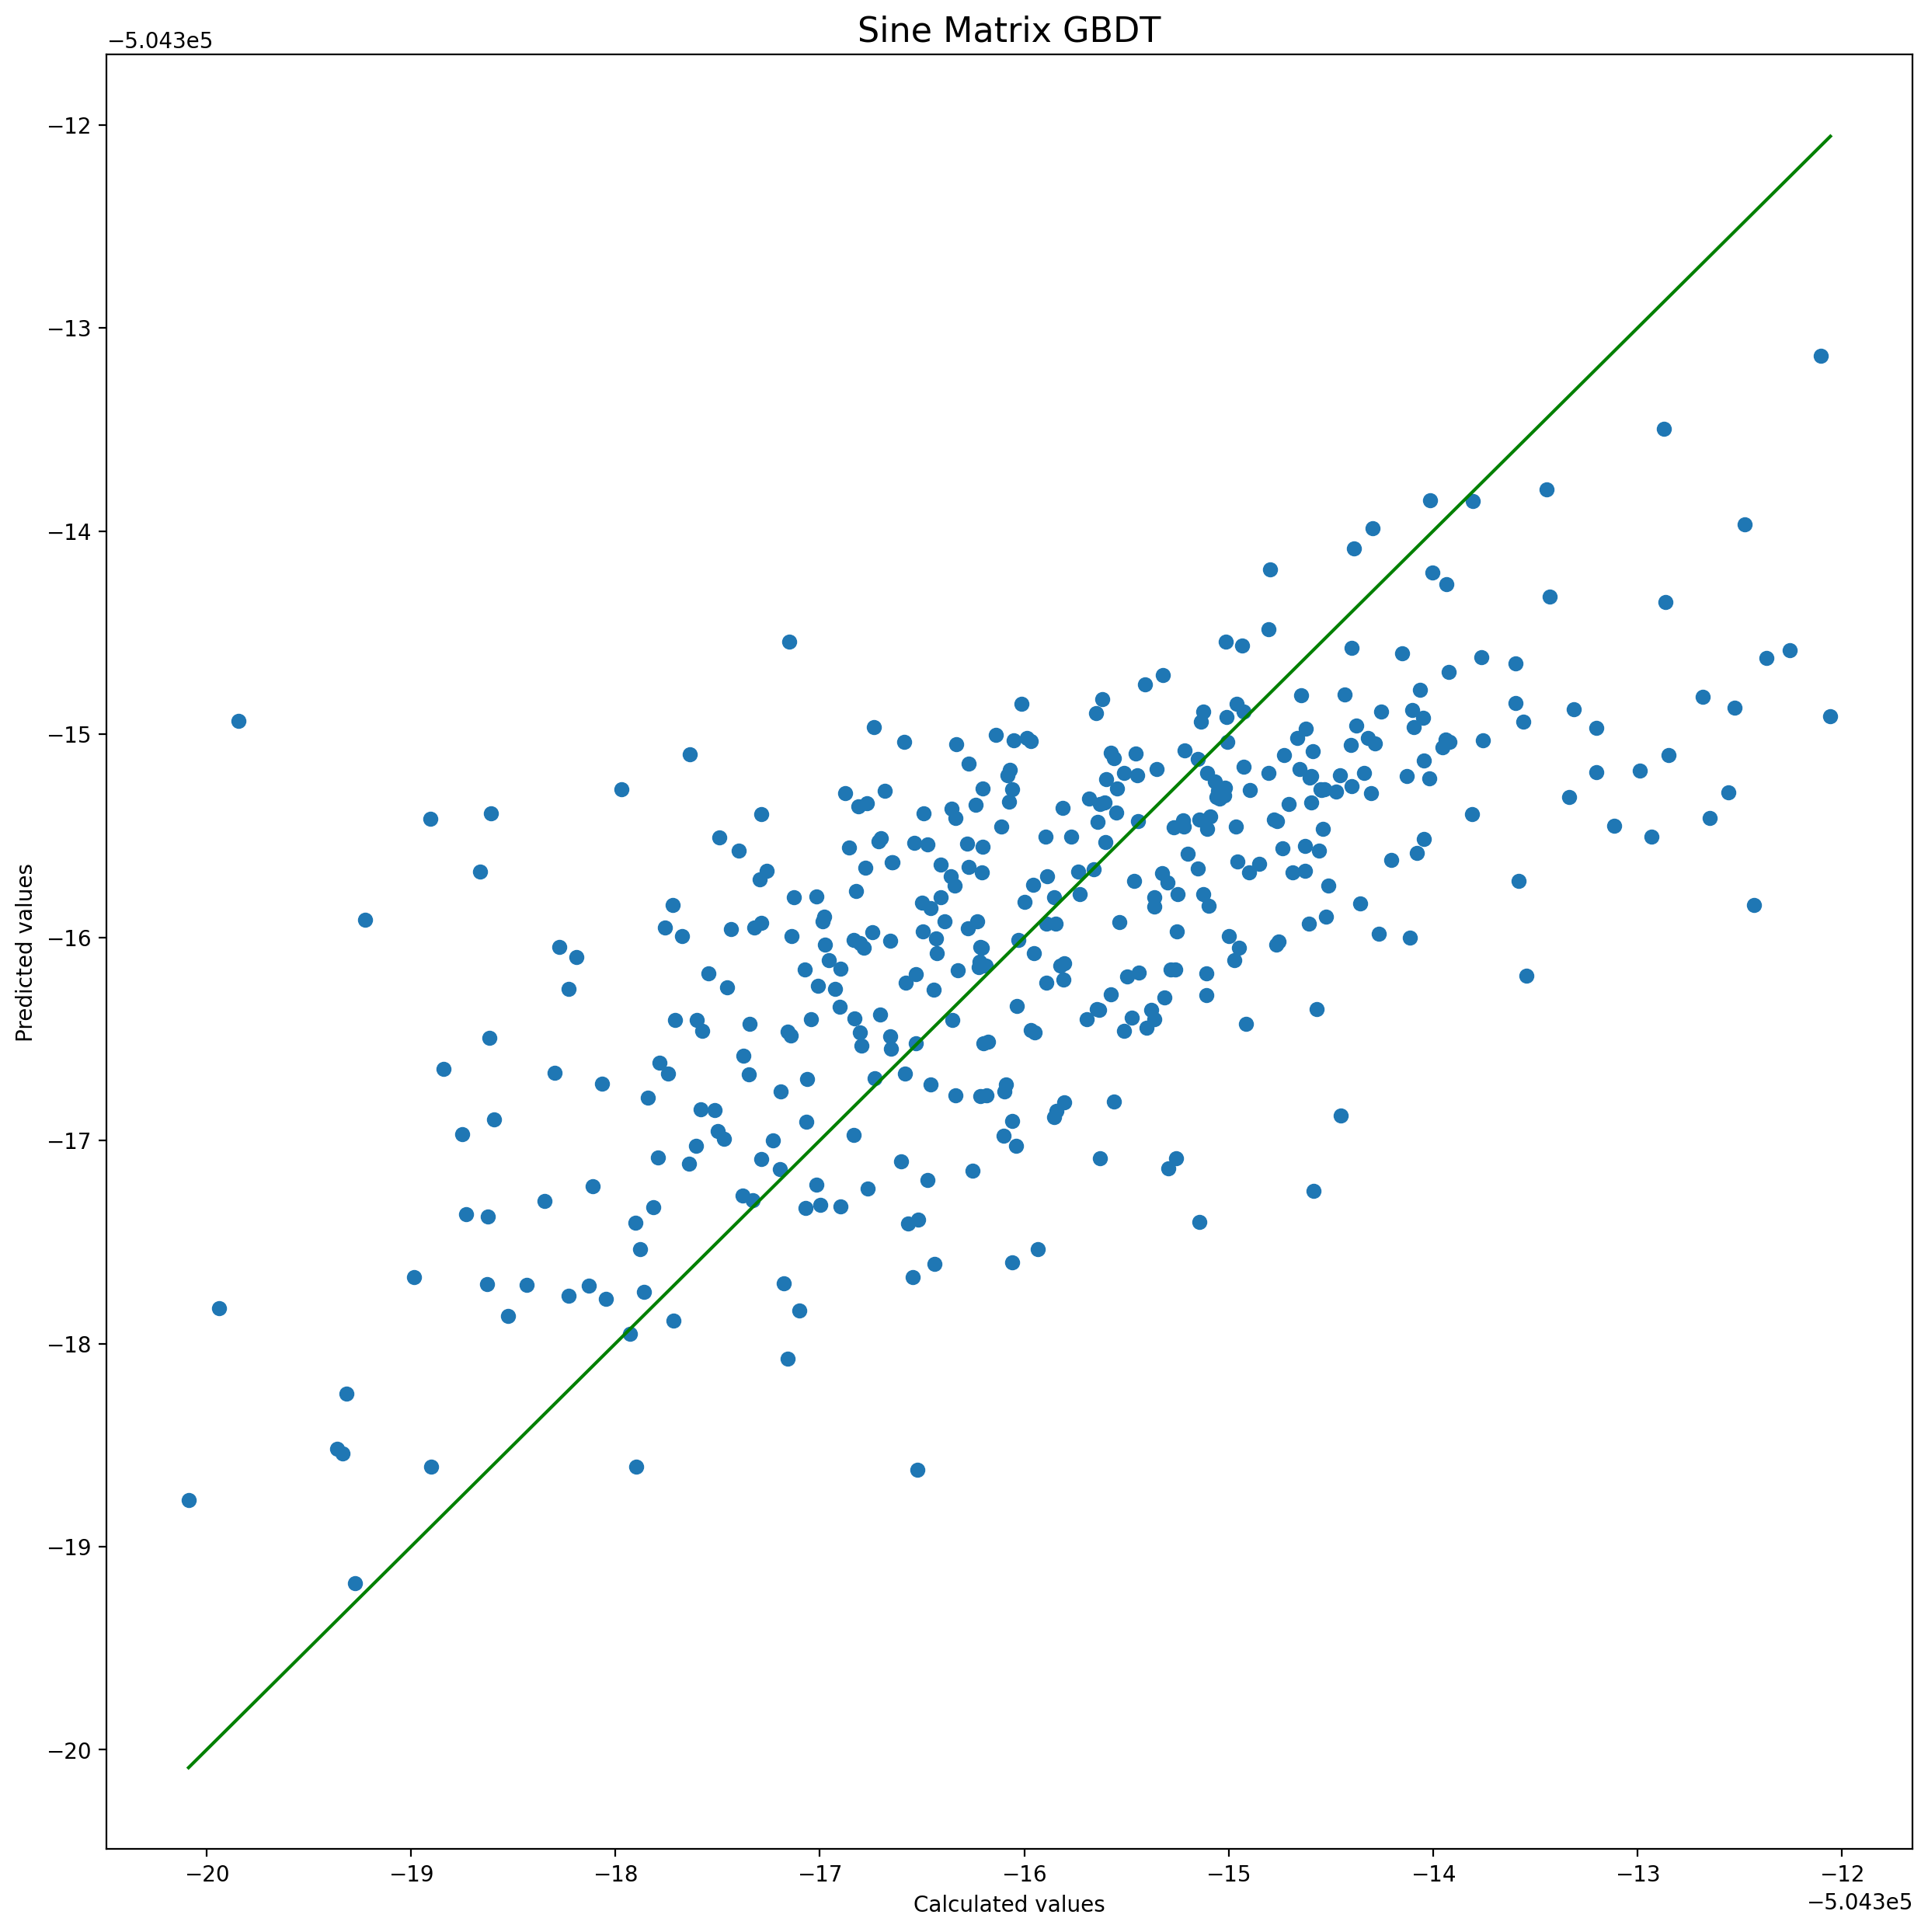

r squared value is 0.443296605758032
mean absolute error 879.532262537179
maximum error 4909.220165165607


In [175]:
X_train, X_test, y_train, y_test = train_test_split(descriptor, energies, random_state=1, test_size = 0.1)

scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

model.fit(X_train, y_train)
ypred = model.predict(X_test)

errorgraph(y_test, ypred, 'Sine Matrix', 'GBDT')

## Ewald Sum

In [176]:
descriptor = ewald_dscribe
energies = energies_sp

trainsize(descriptor, energies, model)

test size  r^2 value  mean absolute error  maximum error
0        0.1   0.725749           565.458491    3001.963236
1        0.2   0.722484           597.523680    3267.505641
2        0.3   0.713822           600.394428    3834.792398
3        0.4   0.707427           610.585553    3855.278872
4        0.5   0.684219           628.826871    6201.418887
5        0.6   0.672109           647.793857    6082.081157
6        0.7   0.640724           681.553661    6477.207629
7        0.8   0.578594           743.994189    6387.363461
8        0.9   0.494942           824.484969    6138.215480

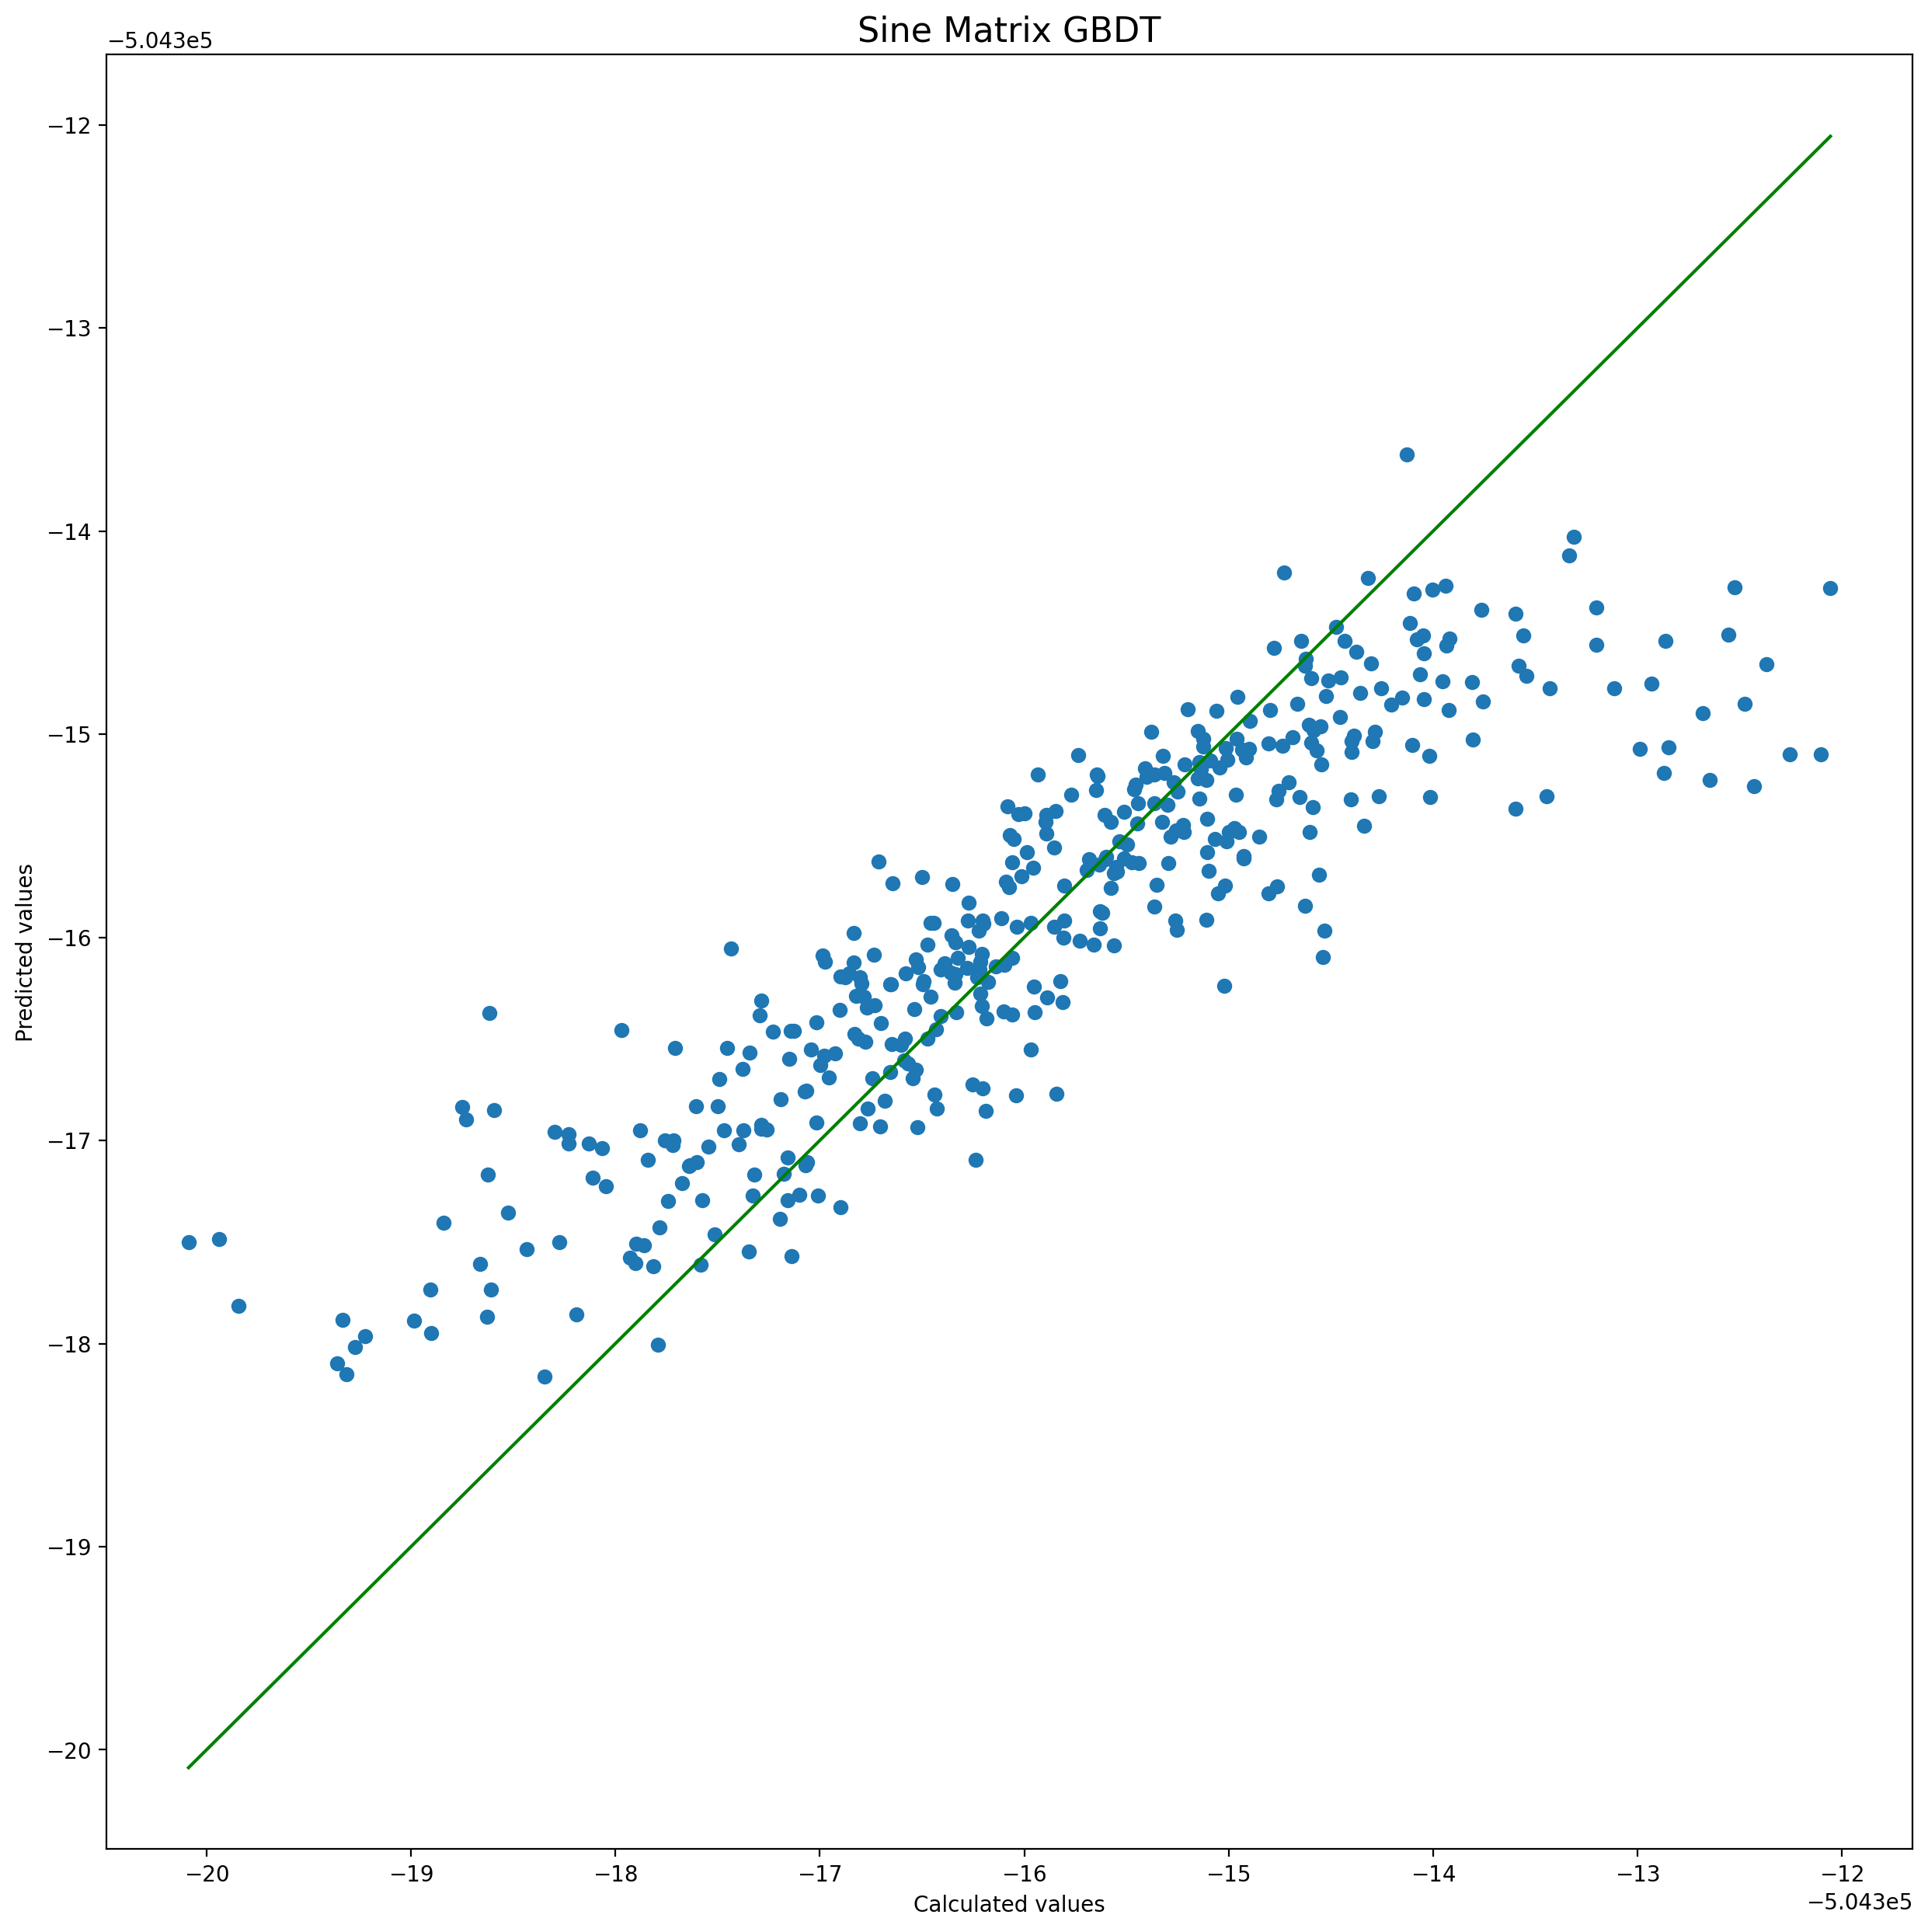

r squared value is 0.7264042760421248
mean absolute error 565.3602150047866
maximum error 2993.092742690351


In [179]:
descriptor = ewald_dscribe
descriptor = X_train, X_test, y_train, y_test = train_test_split(descriptor, energies, random_state=1, test_size = 0.1)

scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

model.fit(X_train, y_train)
ypred = model.predict(X_test)

errorgraph(y_test, ypred, 'Sine Matrix', 'GBDT')

## MBTR

In [182]:
descriptor = mbtr_dscribe
energies = energies_sp

trainsize(descriptor, energies, model)

KeyboardInterrupt: 

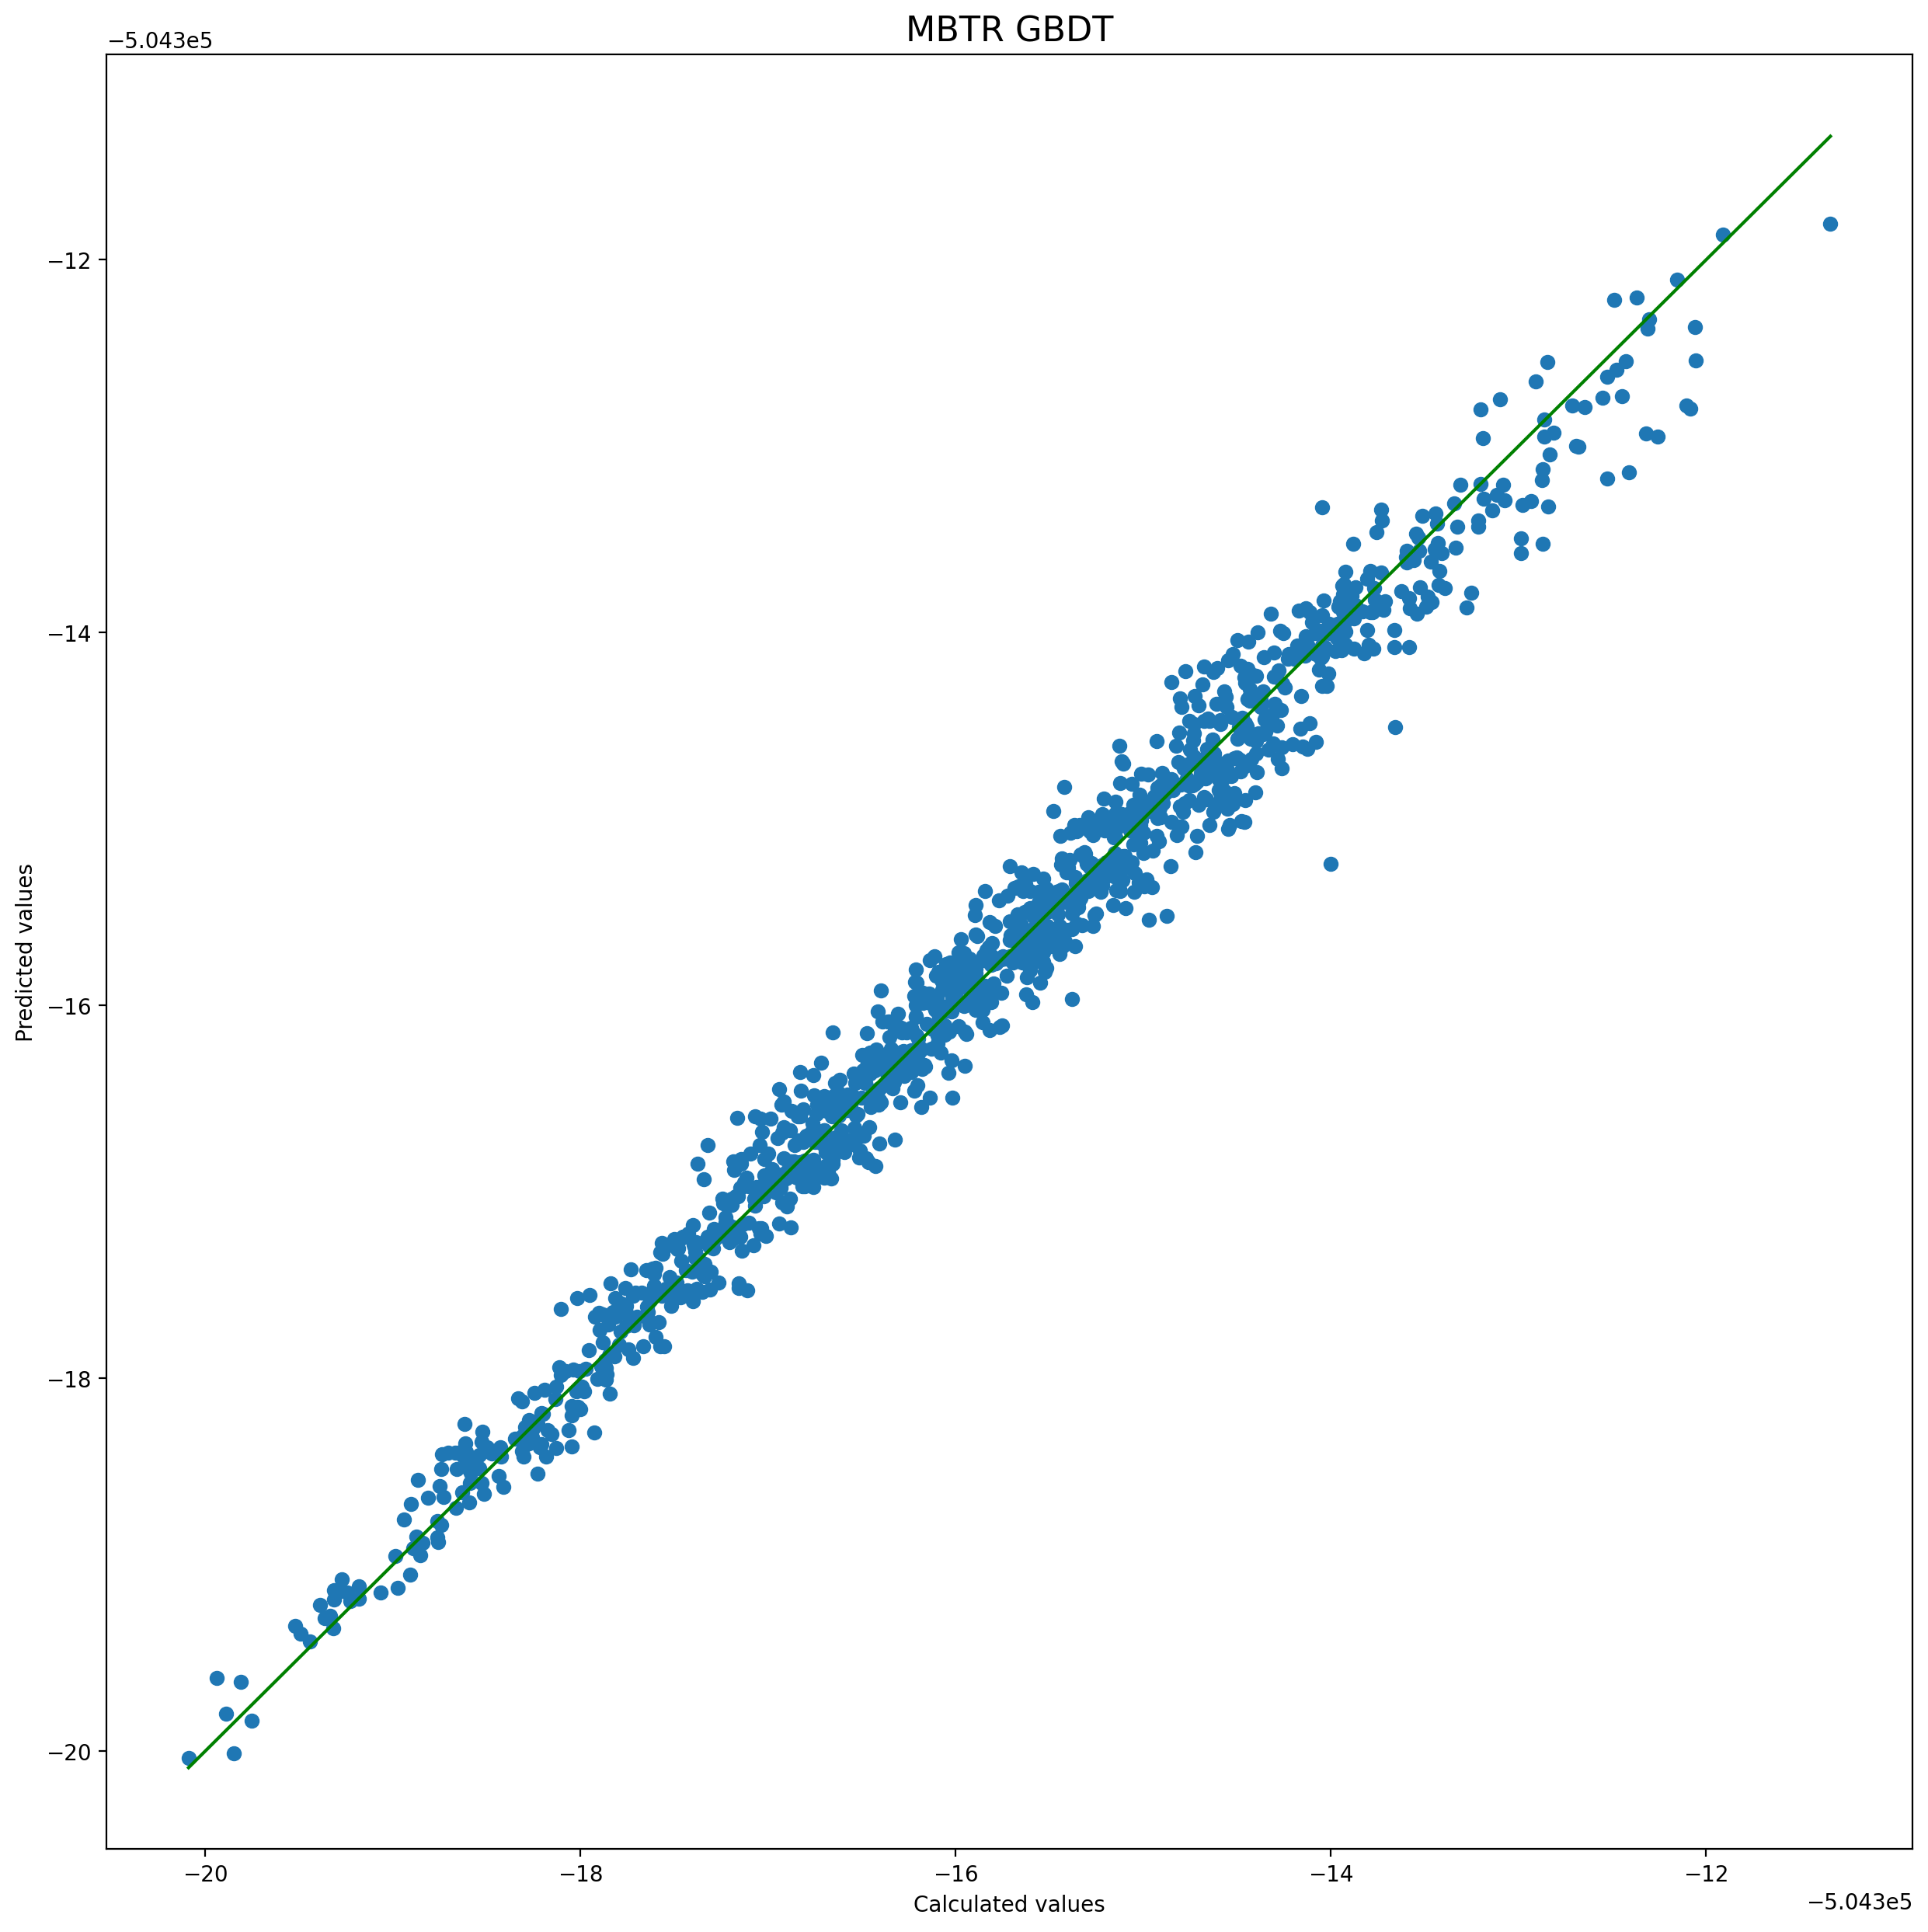

r squared value is 0.9807912356586579
mean absolute error 161.74413536062045
maximum error 1237.658977857791


In [181]:
X_train, X_test, y_train, y_test = train_test_split(descriptor, energies, random_state=1, test_size = 0.3)

scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

model.fit(X_train, y_train)
ypred = model.predict(X_test)

errorgraph(y_test, ypred, 'MBTR', 'GBDT')

## <a id='knr'>K Neighbors Regressor</a>

In [186]:
model = KNeighborsRegressor(n_neighbors=5)

In [192]:
#testing best n_neighbors value:
def para_knr(descriptor,energies,testset):
    nn = np.arange(1,15,1)
    r2_ = []
    mae_ = []
    maxer_ = []
    paratesting = pd.DataFrame()
    paratesting['n_neighbors'] = nn
    
    X_train, X_test, y_train, y_test = train_test_split(descriptor, energies, random_state=1, test_size = testset)
    scaler = StandardScaler()  
    scaler.fit(X_train)  
    X_train = scaler.transform(X_train)  
    X_test = scaler.transform(X_test)
    for i in nn:
        model = KNeighborsRegressor(n_neighbors=i) 
        model.fit(X_train, y_train)
        ypred = model.predict(X_test)

        r2_.append(r2(y_test,ypred))
        mae_.append(mae(y_test, ypred))
        maxer_.append(maxer(y_test,ypred))
            
    paratesting['r^2 value'] = r2_
    paratesting['mean absolute error'] = mae_
    paratesting['maximum error'] = maxer_
    
    return paratesting
        
        
    

### CME

In [194]:
#optimal n_neighbors value tested with CME
descriptor = cm_dscribe
energies = energies_sp
testset = 0.3
para_knr(descriptor,energies,testset)
    #the value 6 gives the best outcome but the default value already gives a good enough outcome

n_neighbors  r^2 value  mean absolute error  maximum error
0             1   0.522041           819.693546    4425.883618
1             2   0.659618           698.014807    3538.387562
2             3   0.720839           632.932620    3202.730954
3             4   0.731171           621.040107    3427.890694
4             5   0.737006           613.856041    3593.068035
5             6   0.739598           606.967615    3930.136529
6             7   0.738967           606.904375    4239.586332
7             8   0.737736           609.162558    4384.541890
8             9   0.737292           608.615872    4480.113477
9            10   0.737577           607.050363    4438.616814
10           11   0.735303           609.862336    4211.685318
11           12   0.731675           618.520753    4049.026325
12           13   0.729680           618.427209    4138.936850
13           14   0.729565           620.757621    4057.670539

In [204]:
#optimal test set for: CME (Kneighbors regression)
descriptor = cm_dscribe
energies = energies_sp
model = KNeighborsRegressor(n_neighbors=6)
trainsize(descriptor, energies, model)
    #test size: 0.1 is best

test size  r^2 value  mean absolute error  maximum error
0        0.1   0.746268           591.679818    2918.044470
1        0.2   0.761092           595.540591    2918.044470
2        0.3   0.739598           606.967615    3930.136529
3        0.4   0.736630           613.856689    3930.136529
4        0.5   0.718416           634.491950    5097.399210
5        0.6   0.692353           665.252156    5186.284868
6        0.7   0.664719           694.282242    5209.633765
7        0.8   0.631653           727.547585    5599.196470
8        0.9   0.521632           832.006483    7152.540336

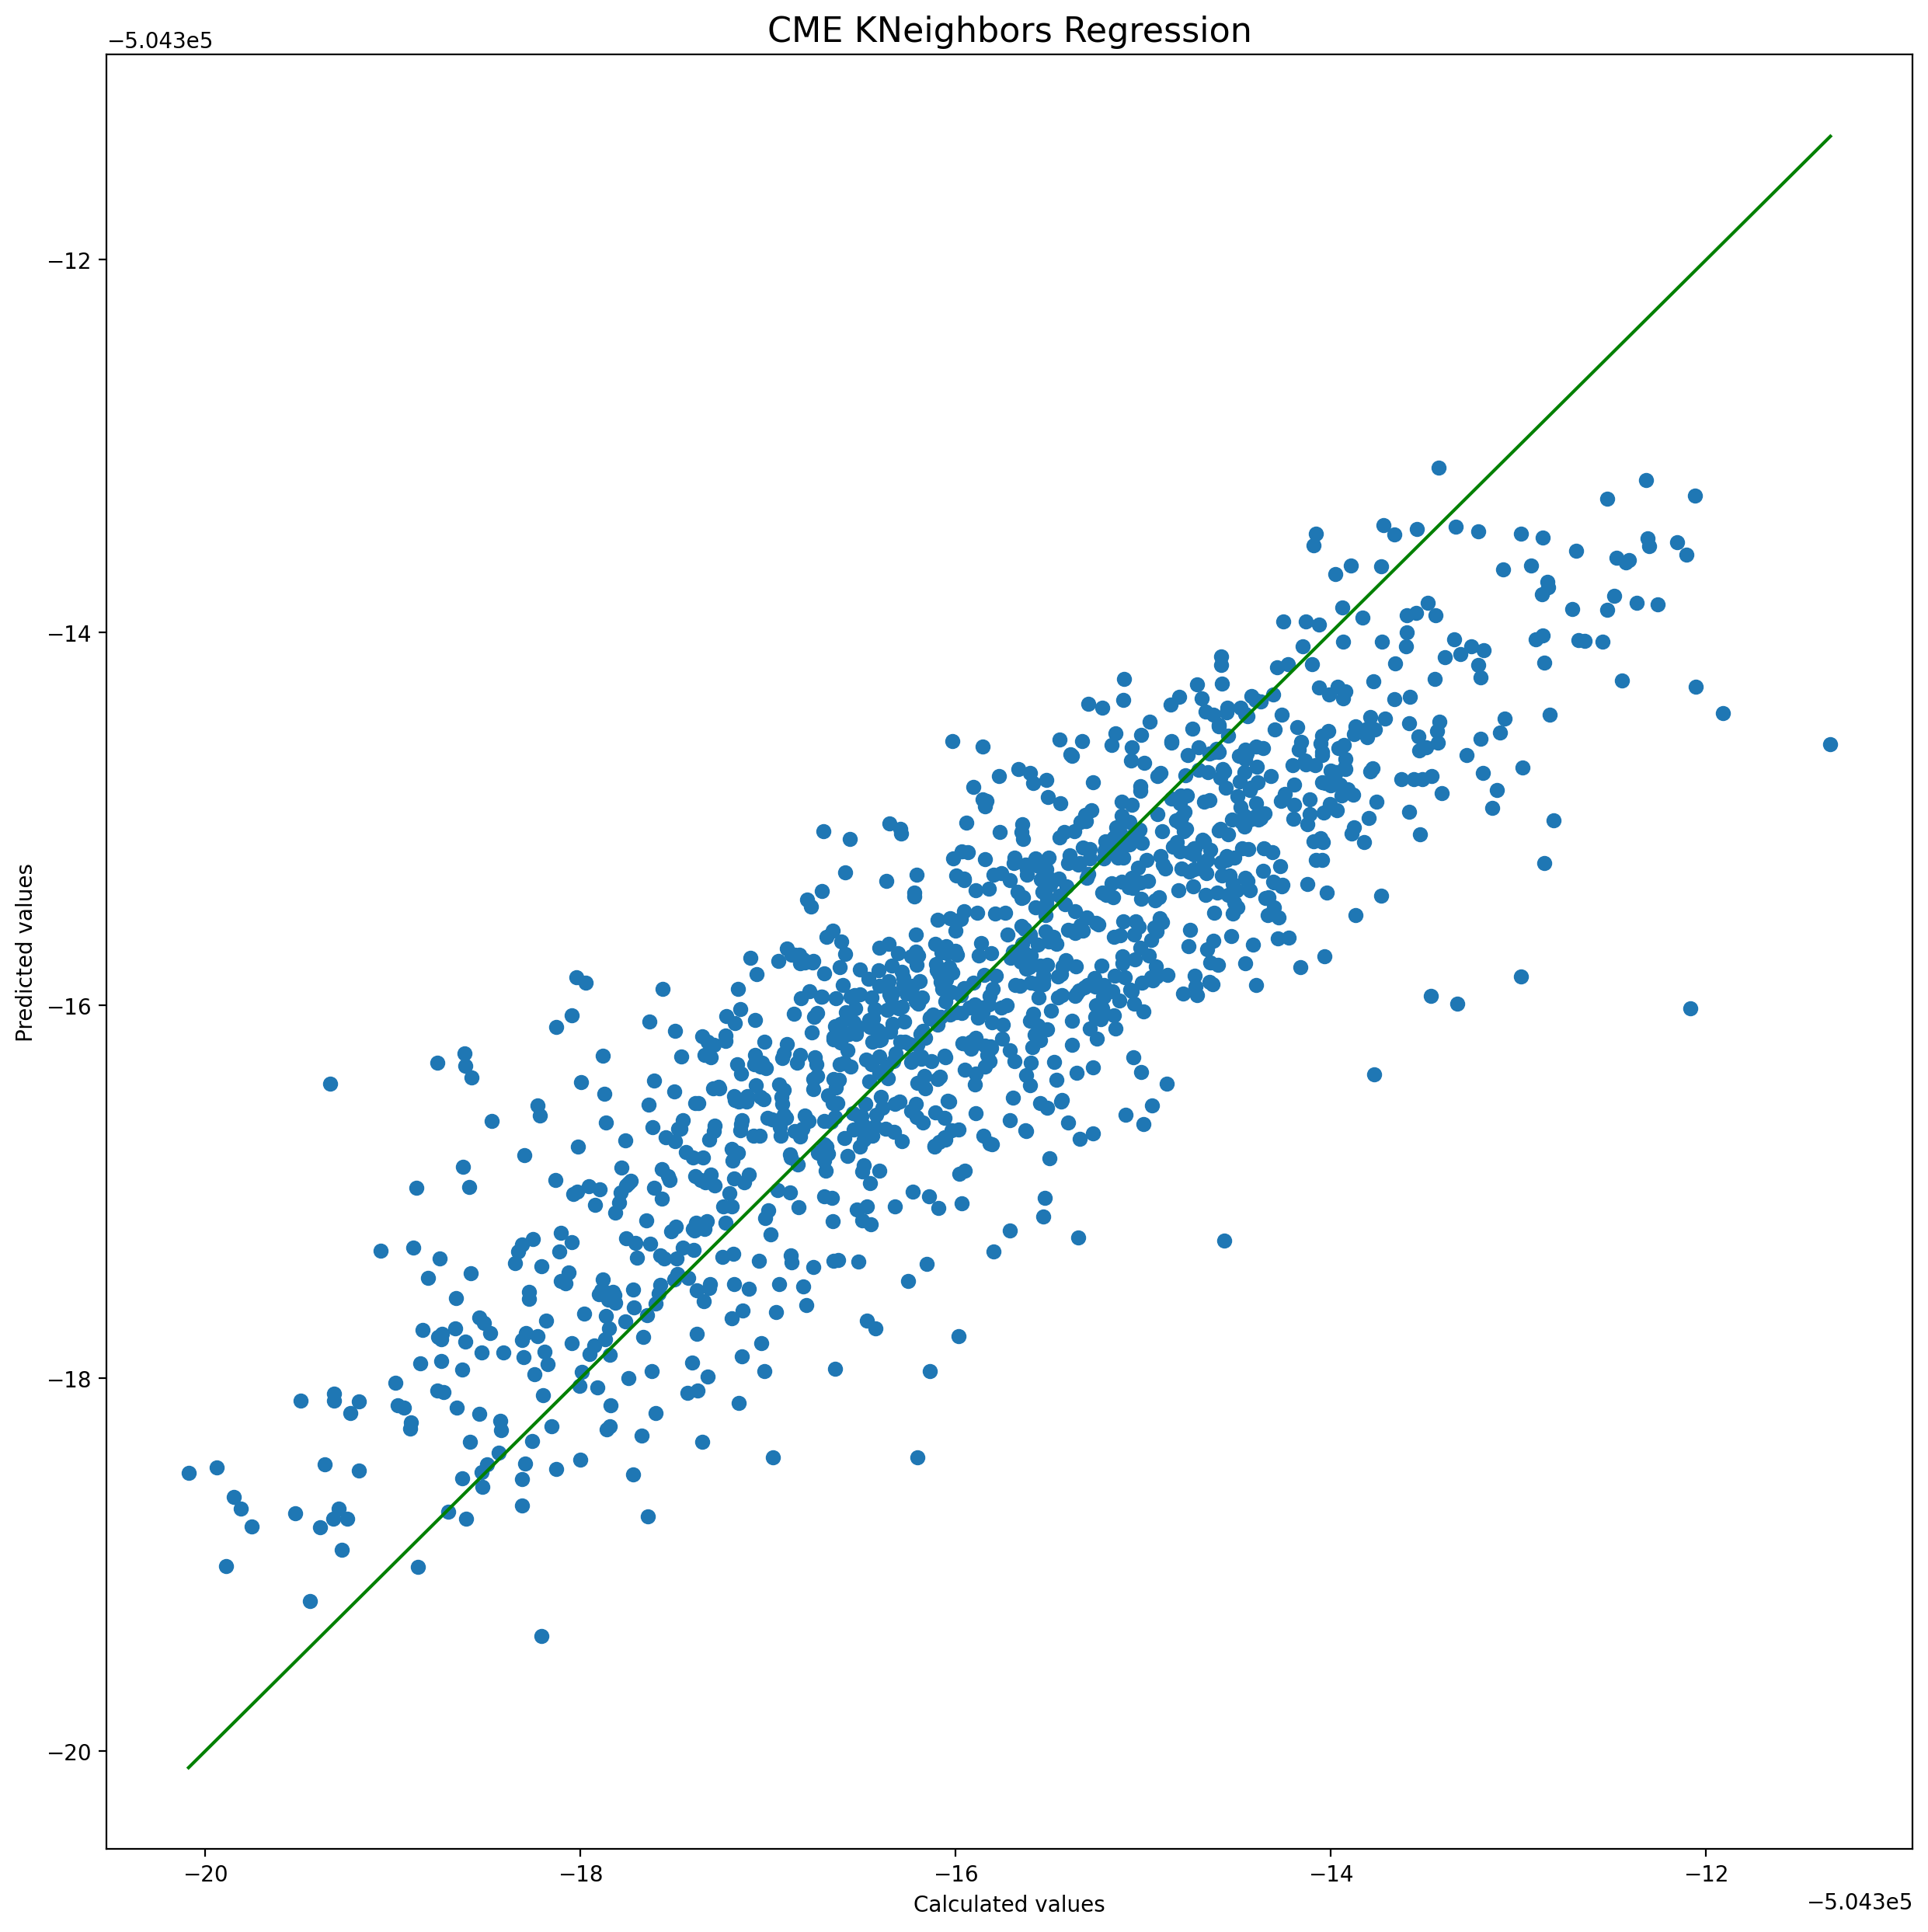

r squared value is 0.7395977965159465
mean absolute error 606.9676148340699
maximum error 3930.1365290302783


In [205]:
X_train, X_test, y_train, y_test = train_test_split(descriptor, energies, random_state=1, test_size = 0.3)

scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

model.fit(X_train, y_train)
ypred = model.predict(X_test)

errorgraph(y_test, ypred, 'CME', 'KNeighbors Regression')

## Sine Matrix

In [206]:
#optimal n_neighbors value tested with Sine Matrix
descriptor = sine_dscribe
energies = energies_sp
testset = 0.3
para_knr(descriptor,energies,testset)
    #n = 7 is best

n_neighbors  r^2 value  mean absolute error  maximum error
0             1  -0.336781          1345.793153    7684.962287
1             2  -0.001597          1163.350947    6324.053309
2             3   0.197769          1054.165447    5412.498677
3             4   0.261486          1007.892320    5732.981182
4             5   0.300120           985.970702    5935.034038
5             6   0.321113           968.309482    5163.882518
6             7   0.333042           959.618372    5542.842288
7             8   0.342525           951.677963    5117.908494
8             9   0.353582           953.306196    5321.045483
9            10   0.353261           955.709621    4805.361828
10           11   0.363835           948.344127    4976.577355
11           12   0.370514           947.889685    4893.244692
12           13   0.377349           942.501893    4621.250464
13           14   0.376242           944.703336    4622.539832

In [207]:
#optimal test set for: Sine (Kneighbors regression)
descriptor = cm_dscribe
energies = energies_sp
model = KNeighborsRegressor(n_neighbors=7)
trainsize(descriptor, energies, model)
    #test size: 0.1 is best

test size  r^2 value  mean absolute error  maximum error
0        0.1   0.748405           591.538034    3409.138008
1        0.2   0.760870           596.478499    3409.138008
2        0.3   0.738967           606.904375    4239.586332
3        0.4   0.735225           614.416859    4239.586332
4        0.5   0.717195           637.536689    5140.518008
5        0.6   0.692562           663.943742    5194.627912
6        0.7   0.664308           695.772900    5408.027160
7        0.8   0.629996           730.071787    5951.709658
8        0.9   0.528356           830.998458    6951.616796

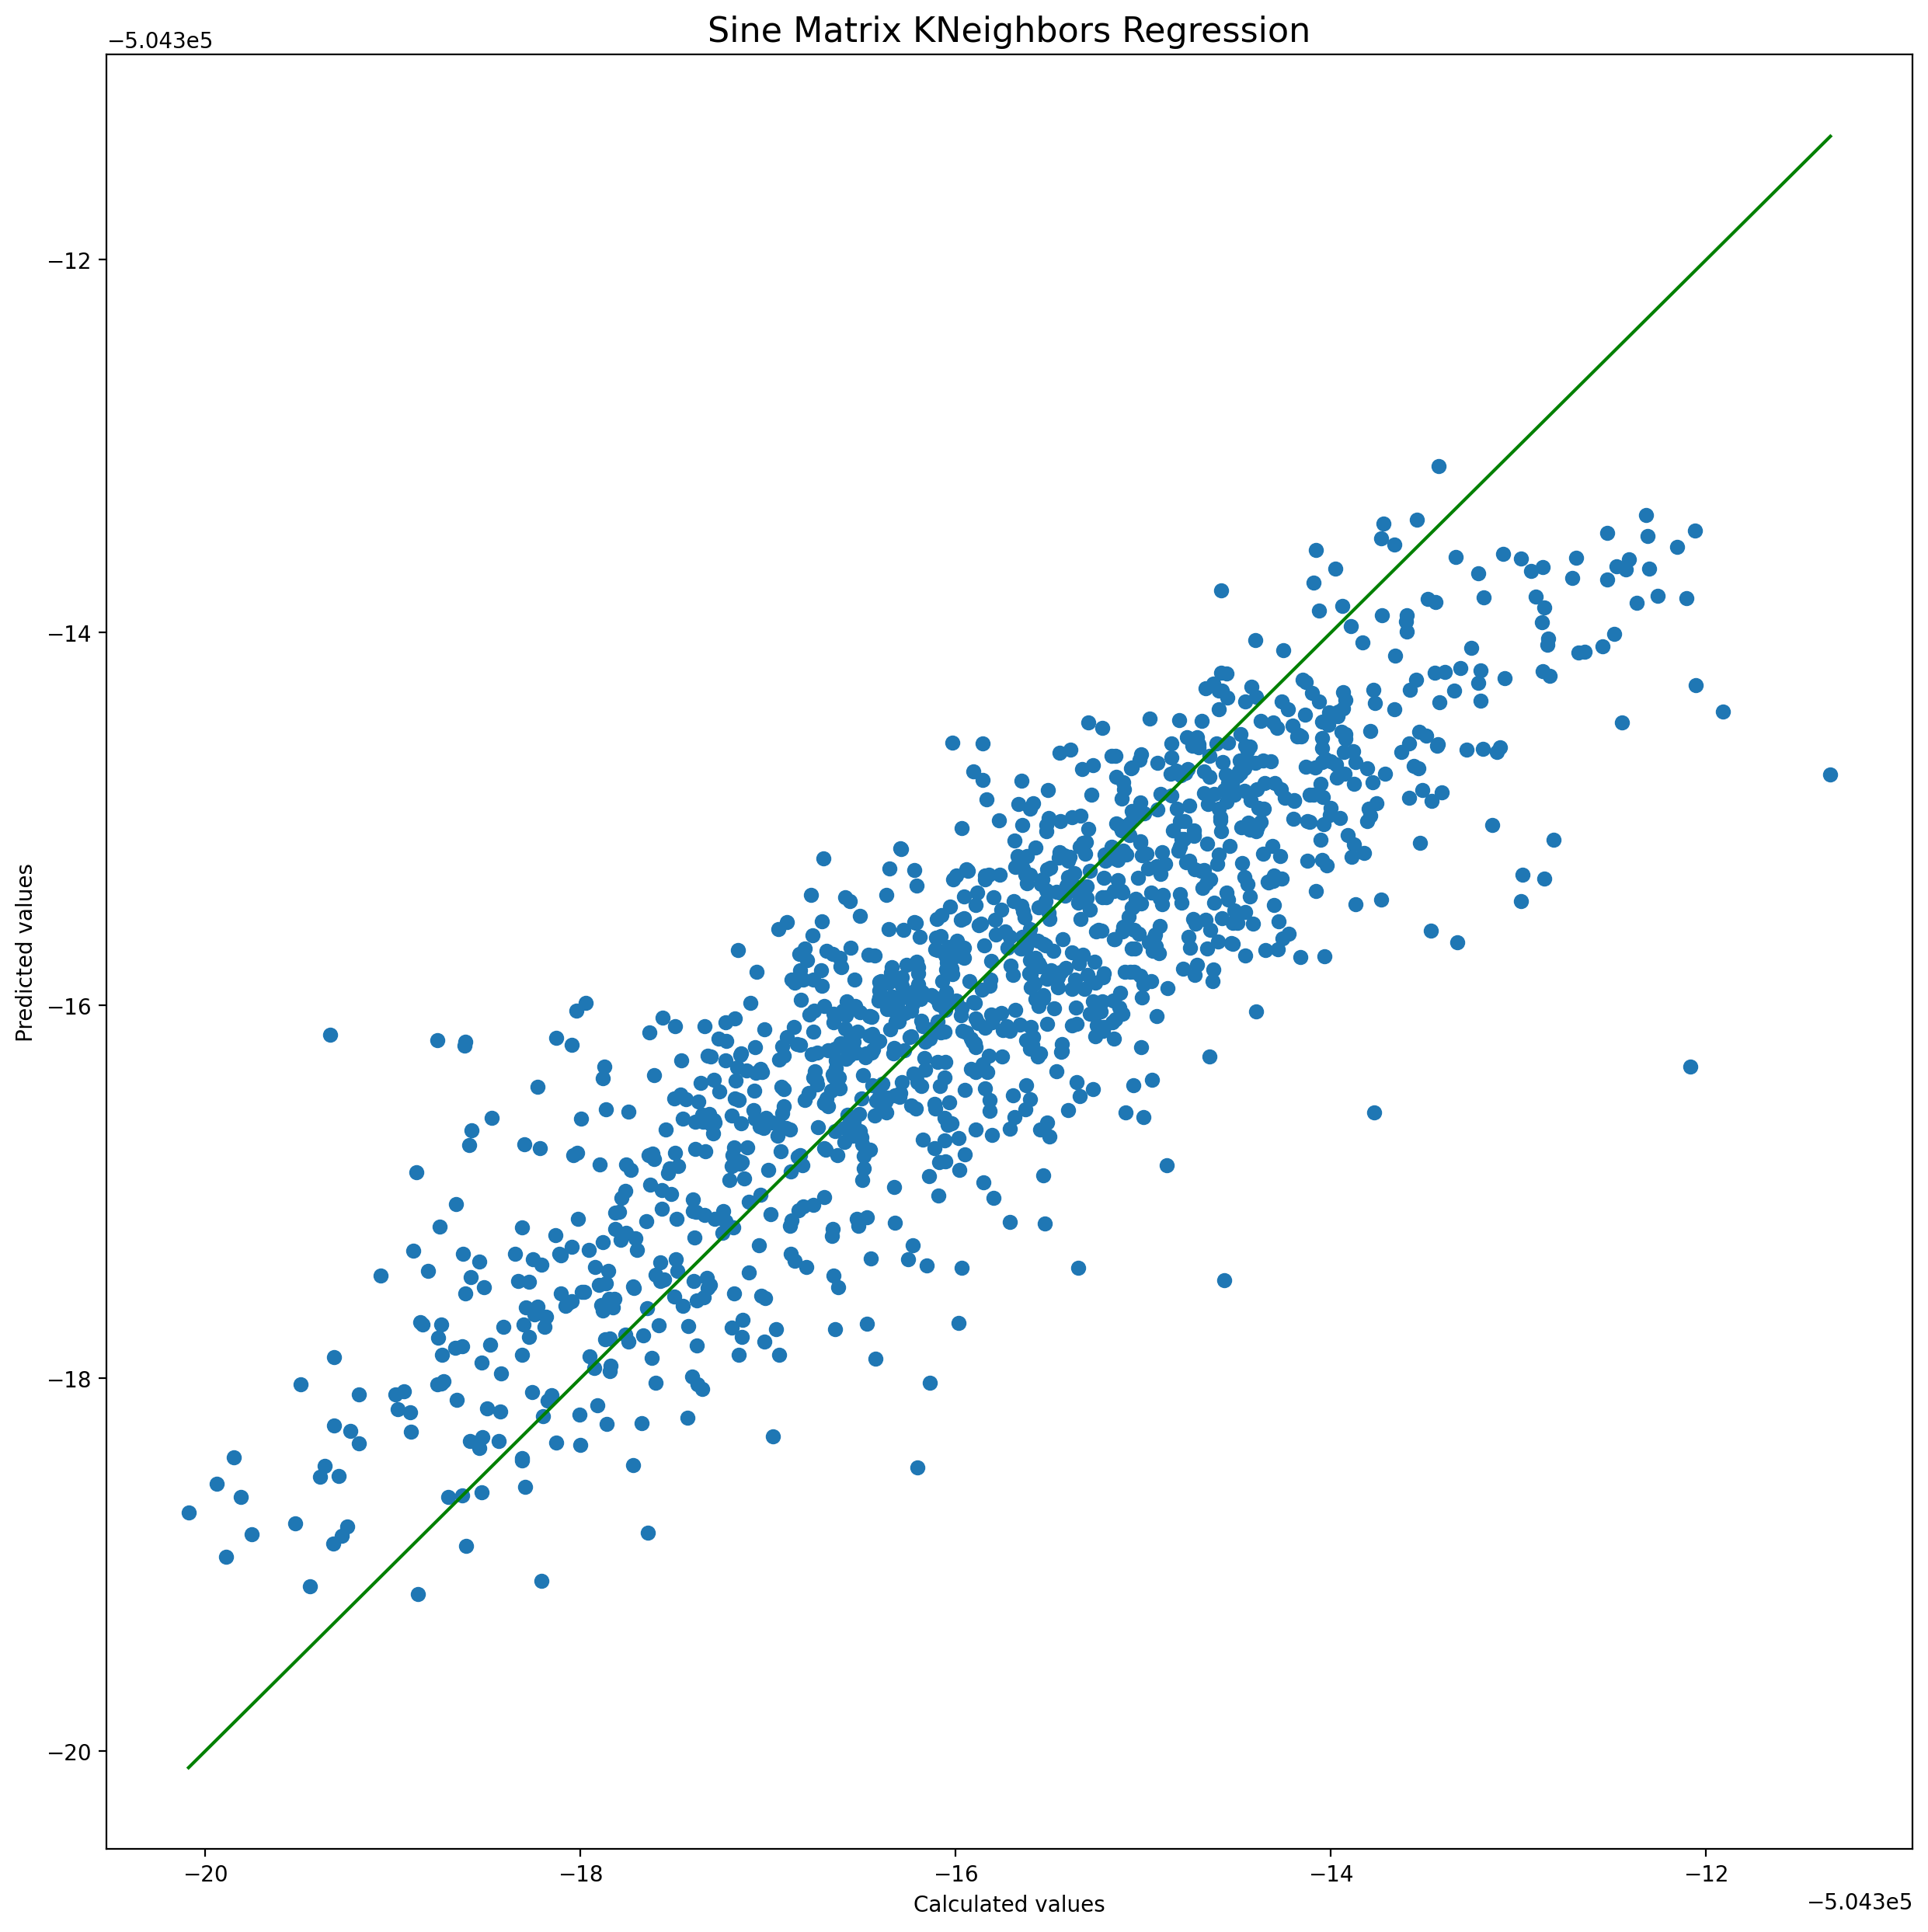

r squared value is 0.7389671958858561
mean absolute error 606.9043746383305
maximum error 4239.586331881583


In [208]:
X_train, X_test, y_train, y_test = train_test_split(descriptor, energies, random_state=1, test_size = 0.3)

scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

model.fit(X_train, y_train)
ypred = model.predict(X_test)

errorgraph(y_test, ypred, 'Sine Matrix', 'KNeighbors Regression')

## Ewald Sum

In [209]:
#optimal n_neighbors value tested with Ewald Matrix
descriptor = ewald_dscribe
energies = energies_sp
testset = 0.3
para_knr(descriptor,energies,testset)
    #n = 1 is best

n_neighbors  r^2 value  mean absolute error  maximum error
0             1   0.683921           527.831663    3983.569202
1             2   0.734068           530.250639    4331.133585
2             3   0.720304           561.274415    3930.027552
3             4   0.725333           573.306268    3265.654260
4             5   0.715982           595.405738    3238.794333
5             6   0.706548           613.463271    3498.167383
6             7   0.693555           632.068752    3332.556110
7             8   0.685425           647.331140    3404.916832
8             9   0.675671           662.222098    3446.234375
9            10   0.663245           675.464852    3329.507655
10           11   0.650463           690.633738    3405.257118
11           12   0.645129           698.222797    3533.876055
12           13   0.634993           709.275528    3579.748594
13           14   0.625559           721.426262    3527.908595

In [215]:
#optimal test set for: CME (Kneighbors regression)
descriptor = ewald_dscribe
energies = energies_sp
model = KNeighborsRegressor(n_neighbors=1)
trainsize(descriptor, energies, model)
    #test size: 0.2 is best

test size  r^2 value  mean absolute error  maximum error
0        0.1   0.770008           437.008939    3189.829990
1        0.2   0.712877           498.512700    3908.736202
2        0.3   0.683921           527.831663    3983.569202
3        0.4   0.632440           579.807369    5663.302741
4        0.5   0.572962           633.110102    6873.574642
5        0.6   0.521926           688.807347    6873.574642
6        0.7   0.470169           747.132226    7225.012470
7        0.8   0.346705           845.834412    7225.012470
8        0.9   0.194915           984.830671    6873.574642

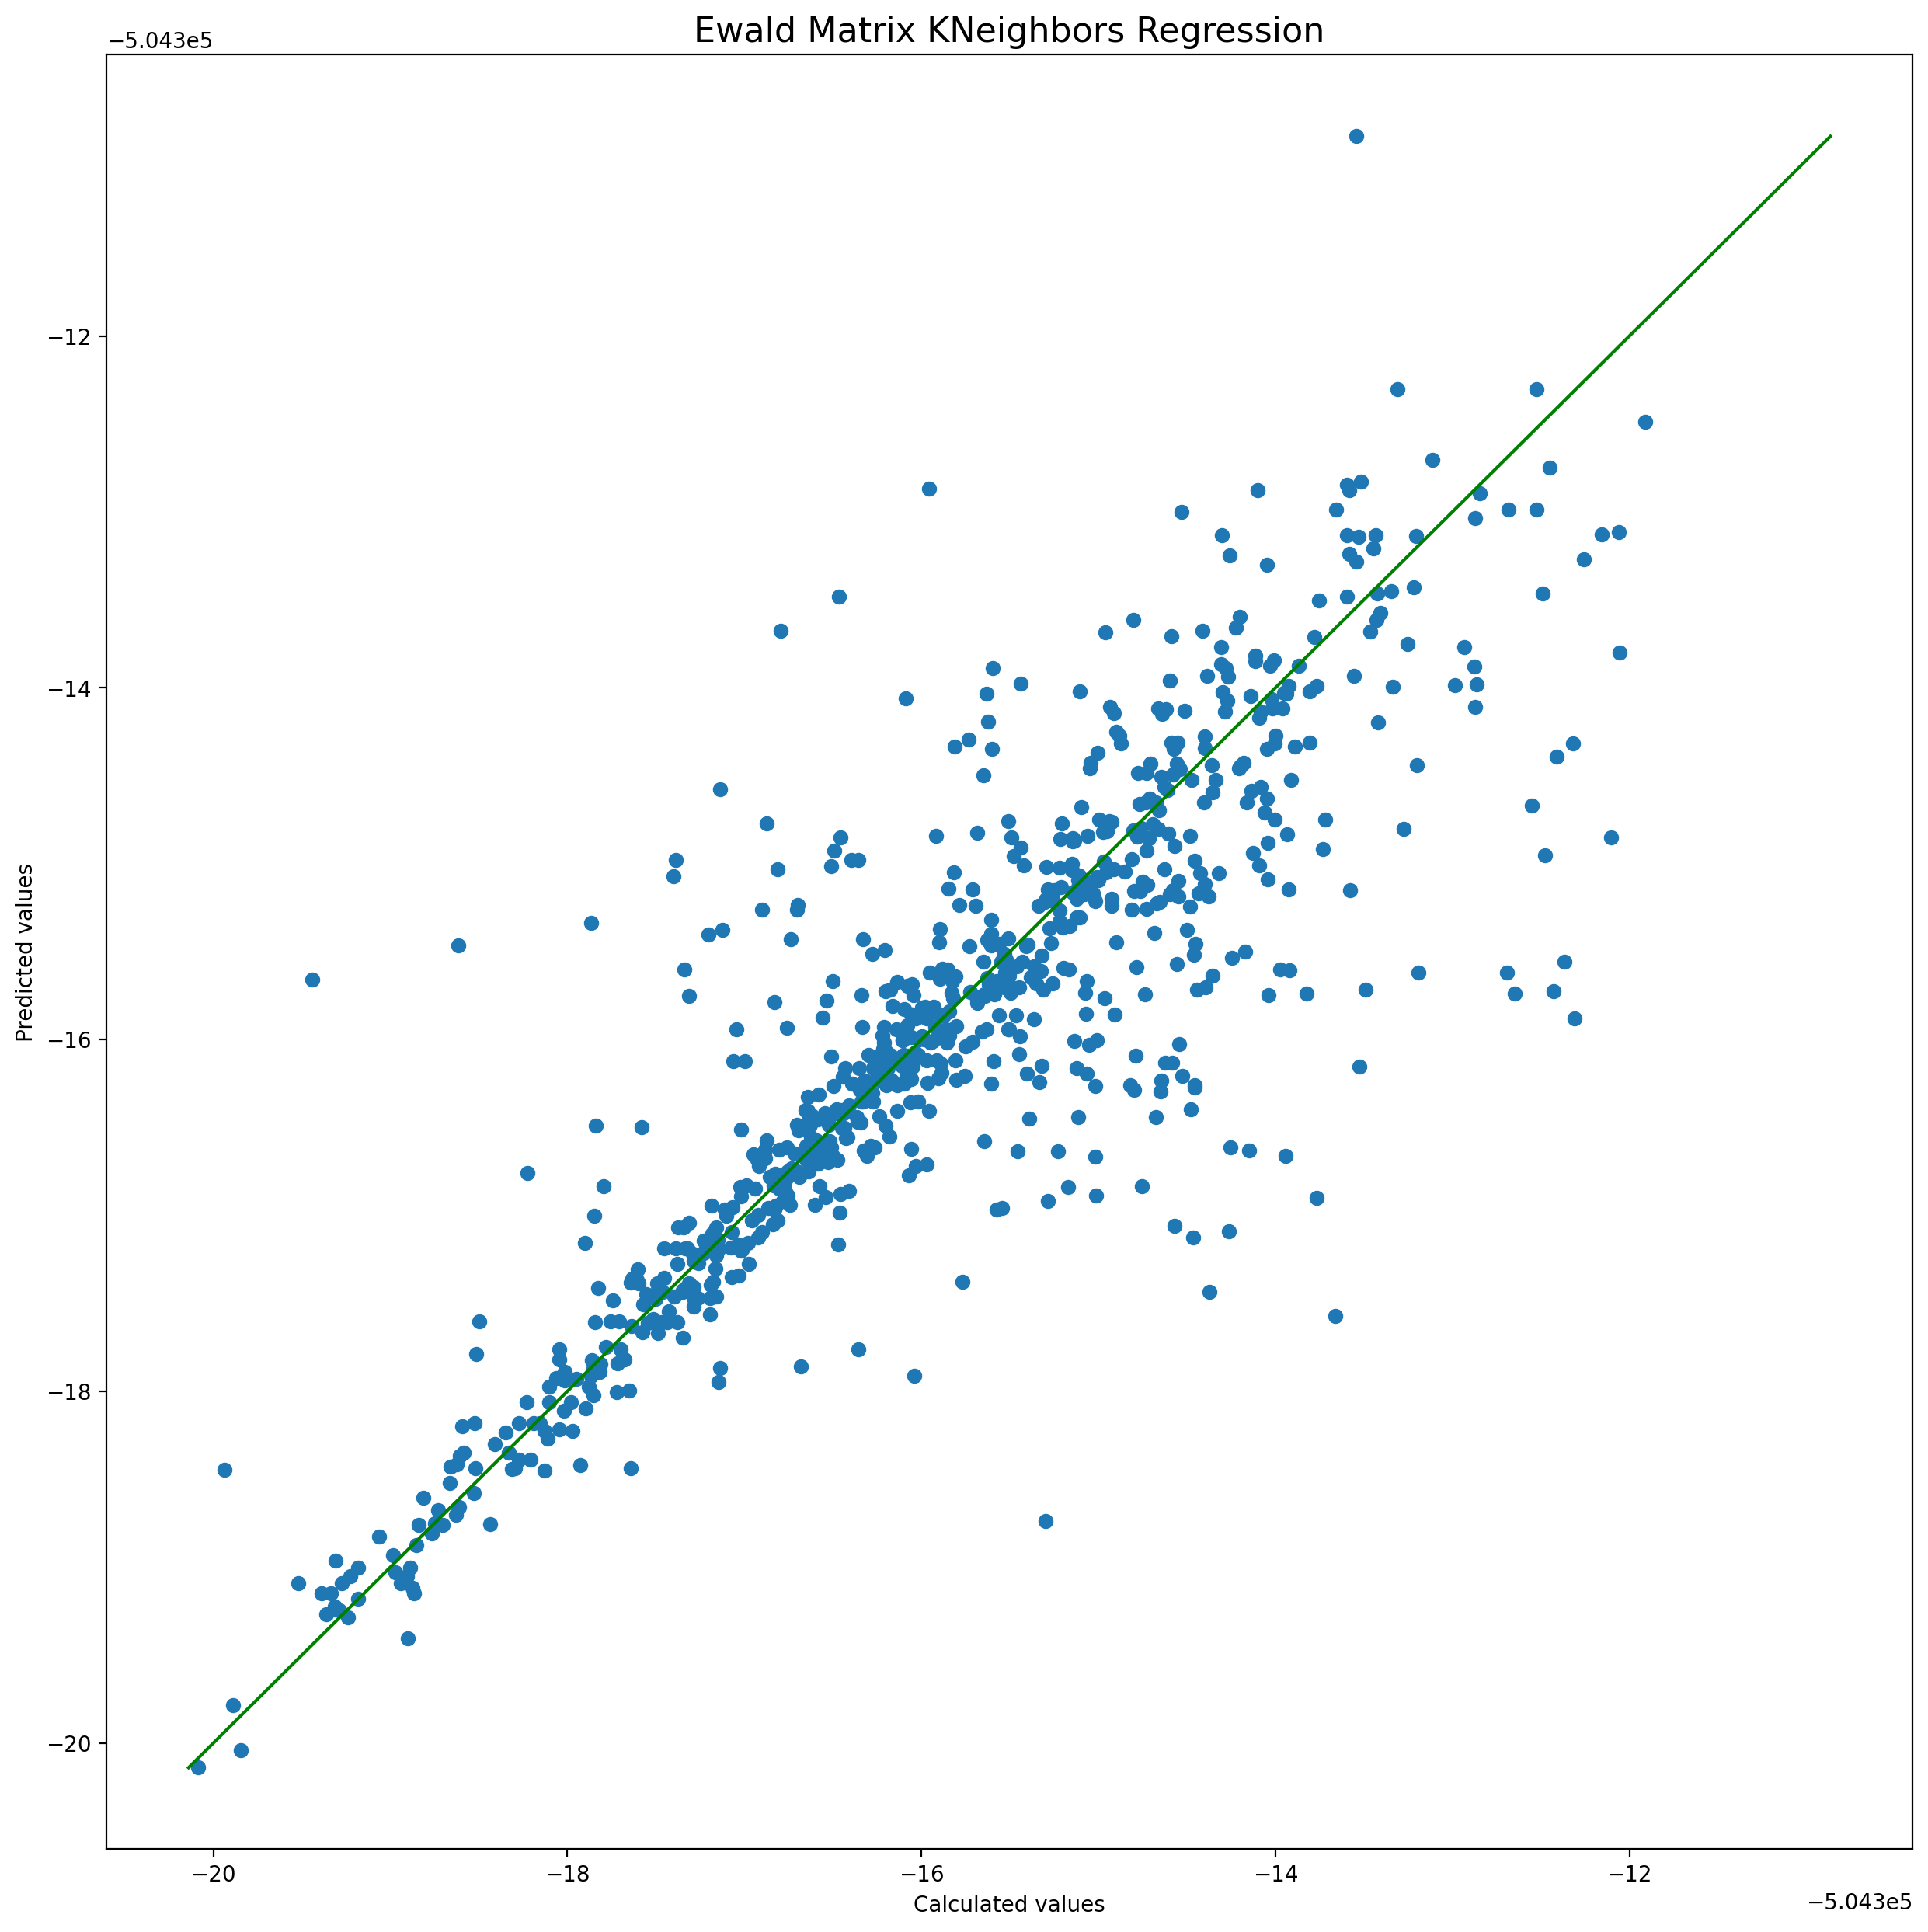

r squared value is 0.7128773018996367
mean absolute error 498.51269973340726
maximum error 3908.7362022837624


In [216]:
X_train, X_test, y_train, y_test = train_test_split(descriptor, energies, random_state=1, test_size = 0.2)

scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

model.fit(X_train, y_train)
ypred = model.predict(X_test)

errorgraph(y_test, ypred, 'Ewald Matrix', 'KNeighbors Regression')

## MBTR

In [200]:
#optimal n_neighbors value tested with MBTR
descriptor = mbtr_dscribe
energies = energies_sp
testset = 0.3
para_knr(descriptor,energies,testset)
    #n = 5 is best (default)

n_neighbors  r^2 value  mean absolute error  maximum error
0             1   0.957473           232.621759    2943.035670
1             2   0.963185           218.666481    2934.048021
2             3   0.964791           216.257954    2677.300492
3             4   0.965738           209.521618    2767.227590
4             5   0.965971           208.686948    2477.285849
5             6   0.966282           206.739811    2501.916368
6             7   0.966148           206.892908    2575.870857
7             8   0.965637           206.781936    2602.054765
8             9   0.964987           208.204424    2626.352885
9            10   0.964796           209.636140    2634.312650
10           11   0.963874           212.854022    2693.020384
11           12   0.963080           215.164007    2723.437032
12           13   0.962534           216.292053    2749.749360
13           14   0.962026           217.483583    2768.019046

In [213]:
#optimal test set for: CME (Kneighbors regression)
descriptor = mbtr_dscribe
energies = energies_sp
model = KNeighborsRegressor(n_neighbors=5)
trainsize(descriptor, energies, model)
    #test size: 0.1 is best

test size  r^2 value  mean absolute error  maximum error
0        0.1   0.972262           189.817678     903.068928
1        0.2   0.971158           199.458184    1130.468894
2        0.3   0.965971           208.686948    2477.285849
3        0.4   0.965342           211.162440    2477.285849
4        0.5   0.962860           217.477703    2770.850496
5        0.6   0.959923           224.384459    3401.056596
6        0.7   0.954593           240.634701    3442.971563
7        0.8   0.947902           259.852982    3683.540032
8        0.9   0.927011           307.919005    4209.484465

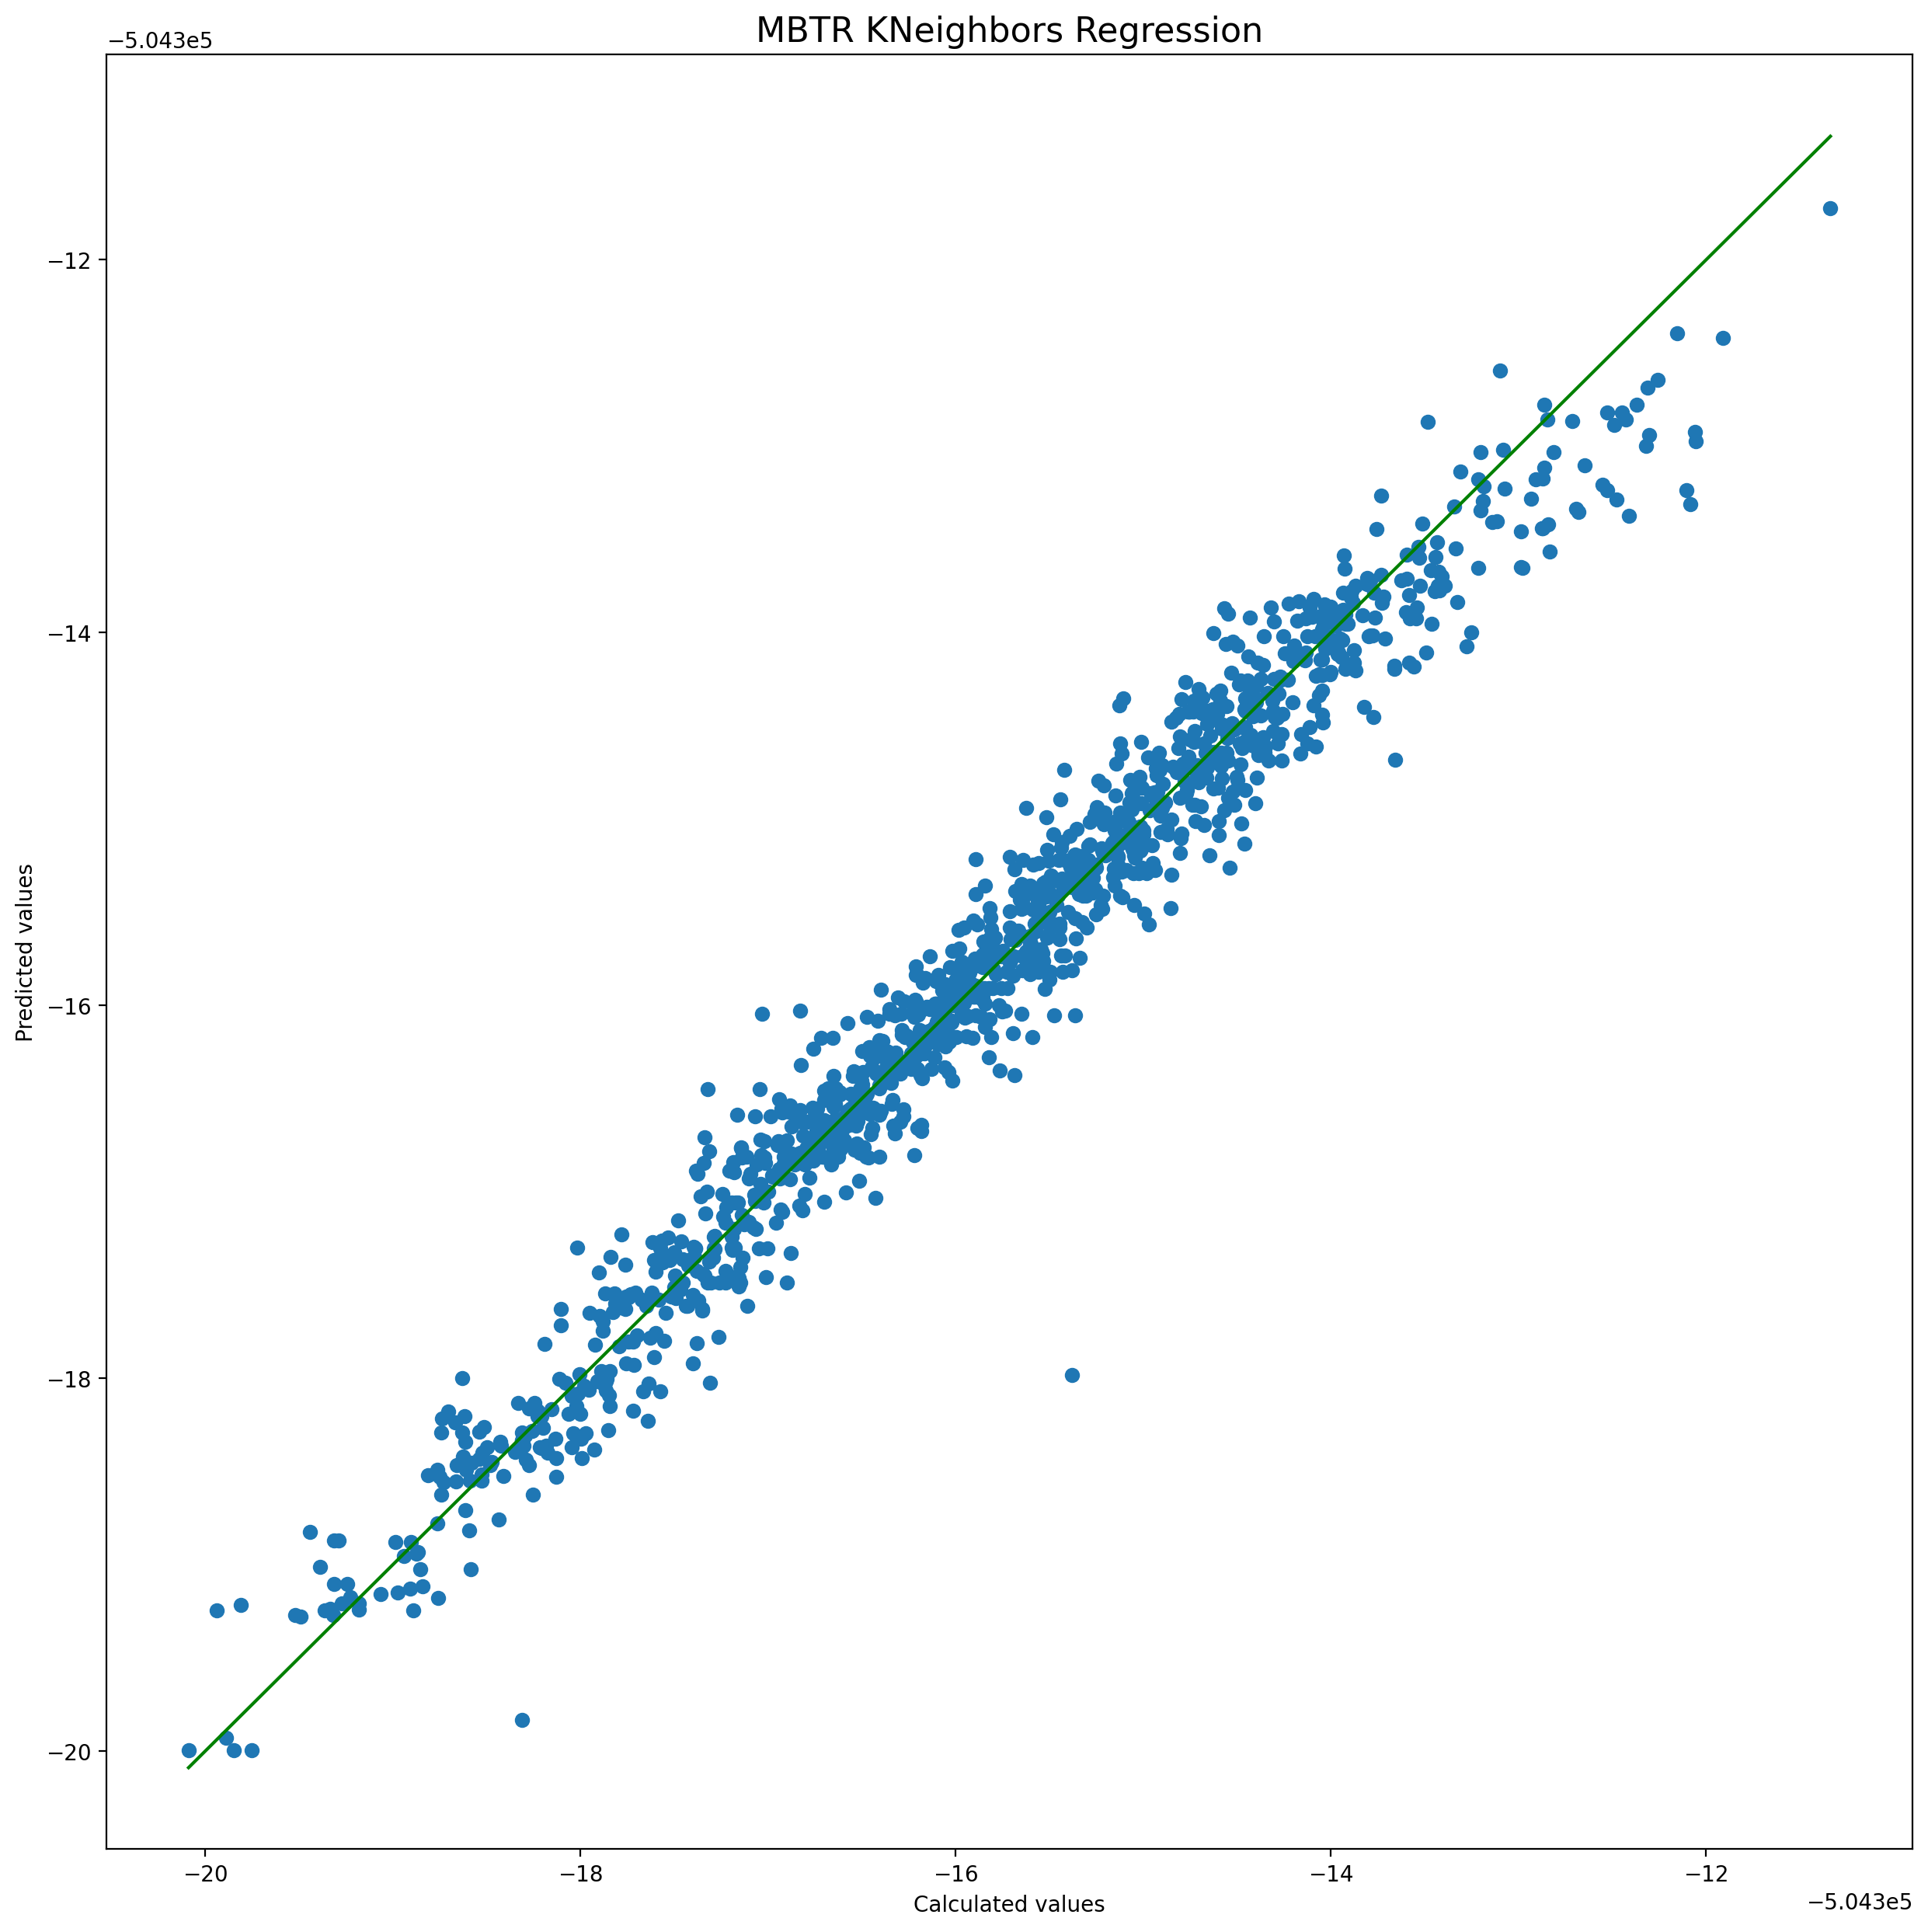

r squared value is 0.9656369029674928
mean absolute error 206.78193580465123
maximum error 2602.0547648658976


In [214]:
model = KNeighborsRegressor(n_neighbors=8)
X_train, X_test, y_train, y_test = train_test_split(descriptor, energies, random_state=1, test_size = 0.3)

scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

model.fit(X_train, y_train)
ypred = model.predict(X_test)

errorgraph(y_test, ypred, 'MBTR', 'KNeighbors Regression')

### <a id='kmeans'>KMeans Clustering</a>

In [130]:
from sklearn.cluster import KMeans

In [131]:
model = KMeans(n_clusters=6, random_state=0, n_init="auto")
descriptor = cm_dscribe
energies = energies_sp

fitting = model.fit(descriptor)
#computing cluster centres and predicting the cluster index for each sample
pred_i = model.fit_predict(descriptor)
#predicting the closest cluster each sample in the data frame belong to

k_means = pd.DataFrame()
k_means['cluster'] = pred_i
k_means['descriptor'] = descriptor
k_means['energies'] = energies

In [132]:
k_means

cluster                                         descriptor  \
0           2  [2679.776194472483, 1133.6757789247476, 913.07...   
1           4  [2598.473819479947, 1125.2892051785288, 913.07...   
2           2  [2658.72603782976, 1076.0749618164243, 898.450...   
3           2  [2653.3486912300223, 1131.823187980145, 879.30...   
4           4  [2549.9089678252053, 1083.0124620485667, 918.9...   
...       ...                                                ...   
4018        5  [2509.7012916262242, 1099.9768046556994, 911.8...   
4019        1  [2540.2183725984933, 1045.4252284272043, 910.9...   
4020        5  [2525.5875504813953, 1069.1627608909764, 897.8...   
4021        1  [2531.0621476703063, 1057.1460032222399, 923.7...   
4022        5  [2507.137967487414, 1070.2881316160983, 933.60...   

           energies  
0    -504309.859577  
1    -504312.104785  
2    -504312.356232  
3    -504312.411568  
4    -504313.530931  
...             ...  
4018 -504318.612011  
4019 -504316.892890  
4020 -504316.890613  
4021 -504317.272705  
4022 -504321.843482  

[4023 rows x 3 columns]

In [90]:
#for i in selected_structures:
    #print(k_means.iloc[i])

#### Plotting of CME descriptor elements of the structures with different symmetry

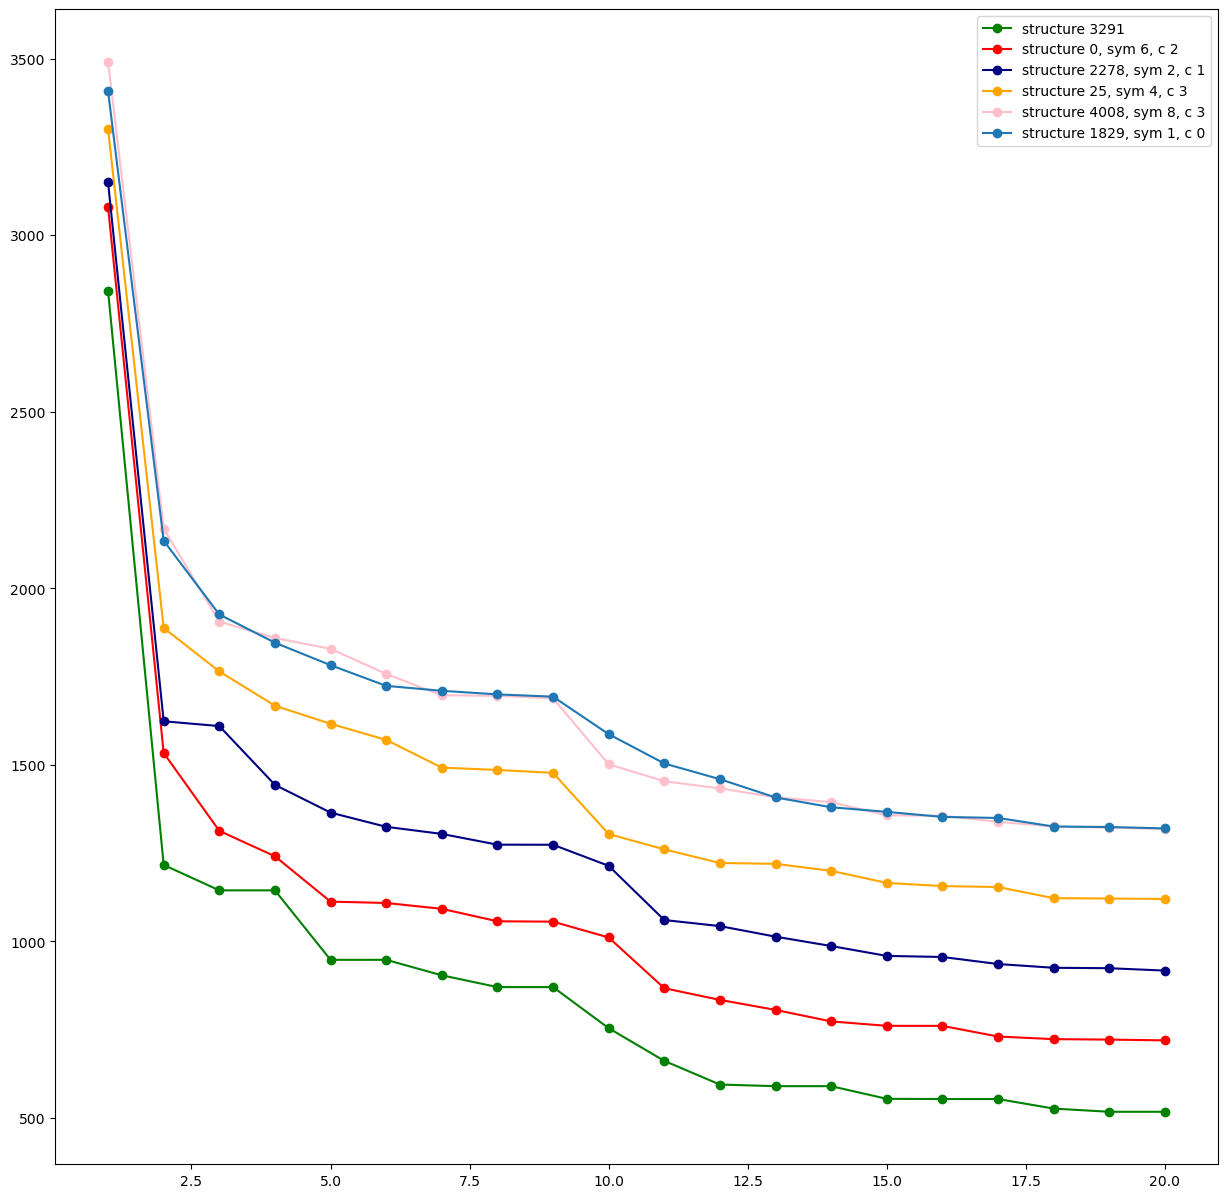

In [133]:
s1829 = k_means.iloc[1829].tolist()
s3291 = k_means.iloc[3291].tolist()
s0= k_means.iloc[0].tolist()
s2278 = k_means.iloc[2278].tolist()
s25 = k_means.iloc[25].tolist()
s4008 = k_means.iloc[4008].tolist()

index = np.arange(1,21,1)

#graph with the each structures descriptor +200 to be able to see them individually
plt.plot(index, [i+200 for i in s3291[1][:20]], marker='o', label='structure 3291', color='green')
plt.plot(index, [i+400 for i in s0[1][:20]], marker='o', label='structure 0, sym 6, c 2', color='red')
plt.plot(index, [i+600 for i in s2278[1][:20]], marker='o', label='structure 2278, sym 2, c 1', color='navy')
plt.plot(index, [i+800 for i in s25[1][:20]], marker='o', label='structure 25, sym 4, c 3', color='orange')
plt.plot(index, [i+1000 for i in s4008[1][:20]], marker='o', label='structure 4008, sym 8, c 3', color='pink')
plt.plot(index, [i+1000 for i in s1829[1][:20]], marker='o', label='structure 1829, sym 1, c 0')
plt.plot()
plt.legend()

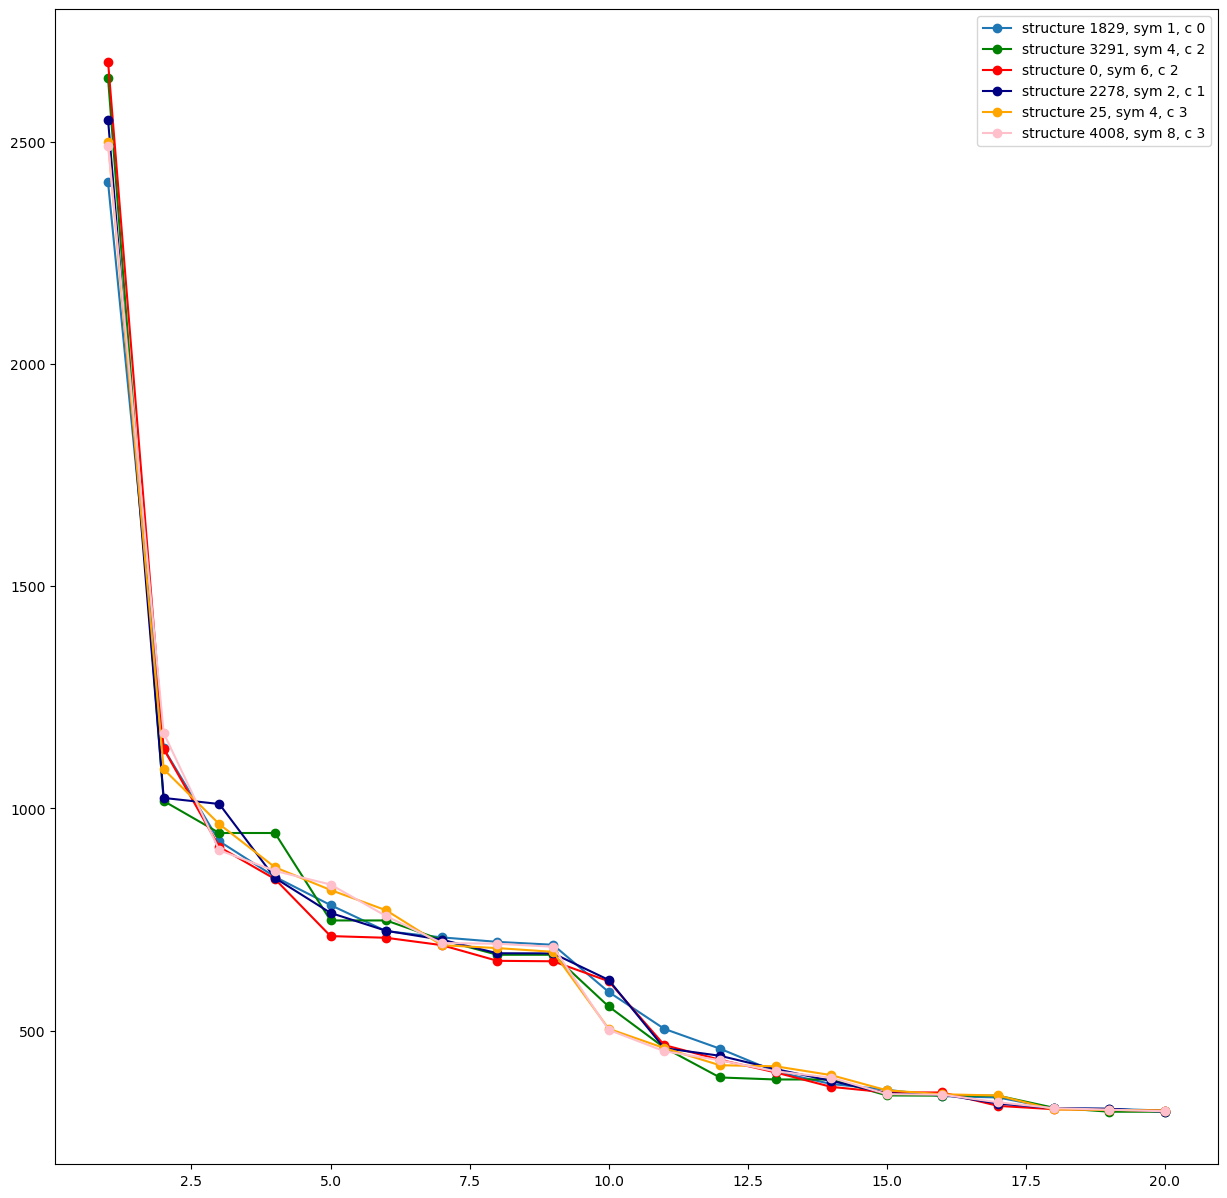

In [96]:
#CME
#graph with the each structures, together
plt.plot(index, s1829[1][:20], marker='o', label='structure 1829, sym 1, c 0')
plt.plot(index, s3291[1][:20], marker='o', label='structure 3291, sym 4, c 2', color='green')
plt.plot(index, s0[1][:20], marker='o', label='structure 0, sym 6, c 2', color='red')
plt.plot(index, s2278[1][:20], marker='o', label='structure 2278, sym 2, c 1', color='navy')
plt.plot(index, s25[1][:20], marker='o', label='structure 25, sym 4, c 3', color='orange')
plt.plot(index, s4008[1][:20], marker='o', label='structure 4008, sym 8, c 3', color='pink')
plt.plot()
plt.legend()

In [145]:
from functions import import_packages

ImportError: cannot import name 'import_packages' from 'functions' (/Users/alexandria/uclproject/ml_sol_sol/functions.py)

In [139]:
cluster_0 = pd.DataFrame()
cluster_1 = pd.DataFrame()
cluster_2 = pd.DataFrame()
cluster_3 = pd.DataFrame()
cluster_4 = pd.DataFrame()
cluster_5 = pd.DataFrame()

ind = []
des = []
en = []

ind_1 = []
des_1 = []
en_1 = []

ind_2 = []
des_2 = []
en_2 = []

ind_3 = []
des_3 = []
en_3 = []

ind_4 = []
des_4 = []
en_4 = []

ind_5 = []
des_5 = []
en_5 = []
for i in range(len(descriptor)): 
    if pred_i[i] == 0:
        en.append(energies[i])
        ind.append(str(i))
        des.append(descriptor[i])
    elif pred_i[i] == 1:
        en_1.append(energies[i])
        ind_1.append(str(i))
        des_1.append(descriptor[i])
    elif pred_i[i] == 2:
        en_2.append(energies[i])
        ind_2.append(str(i))
        des_2.append(descriptor[i])
    elif pred_i[i] == 3:
        en_3.append(energies[i])
        ind_3.append(str(i))
        des_3.append(descriptor[i])
    elif pred_i[i] == 4:
        en_4.append(energies[i])
        ind_4.append(str(i))
        des_4.append(descriptor[i])
    elif pred_i[i] == 5:
        en_5.append(energies[i])
        ind_5.append(str(i))
        des_5.append(descriptor[i])
    
        
cluster_0['index'] = ind
cluster_0['descriptor'] = des
cluster_0['energies'] = en

cluster_1['index'] = ind_1
cluster_1['descriptor'] = des_1
cluster_1['energies'] = en_1

cluster_2['index'] = ind_2
cluster_2['descriptor'] = des_2
cluster_2['energies'] = en_2

cluster_3['index'] = ind_3
cluster_3['descriptor'] = des_3
cluster_3['energies'] = en_3
cluster_4['index'] = ind_4
cluster_4['descriptor'] = des_4
cluster_4['energies'] = en_4

cluster_5['index'] = ind_5
cluster_5['descriptor'] = des_5
cluster_5['energies'] = en_5
    


In [140]:
[int(x) for x in cluster_0['index'].tolist()]

list_ = []
for x in cluster_0['index']:
    list_.append(int(x))


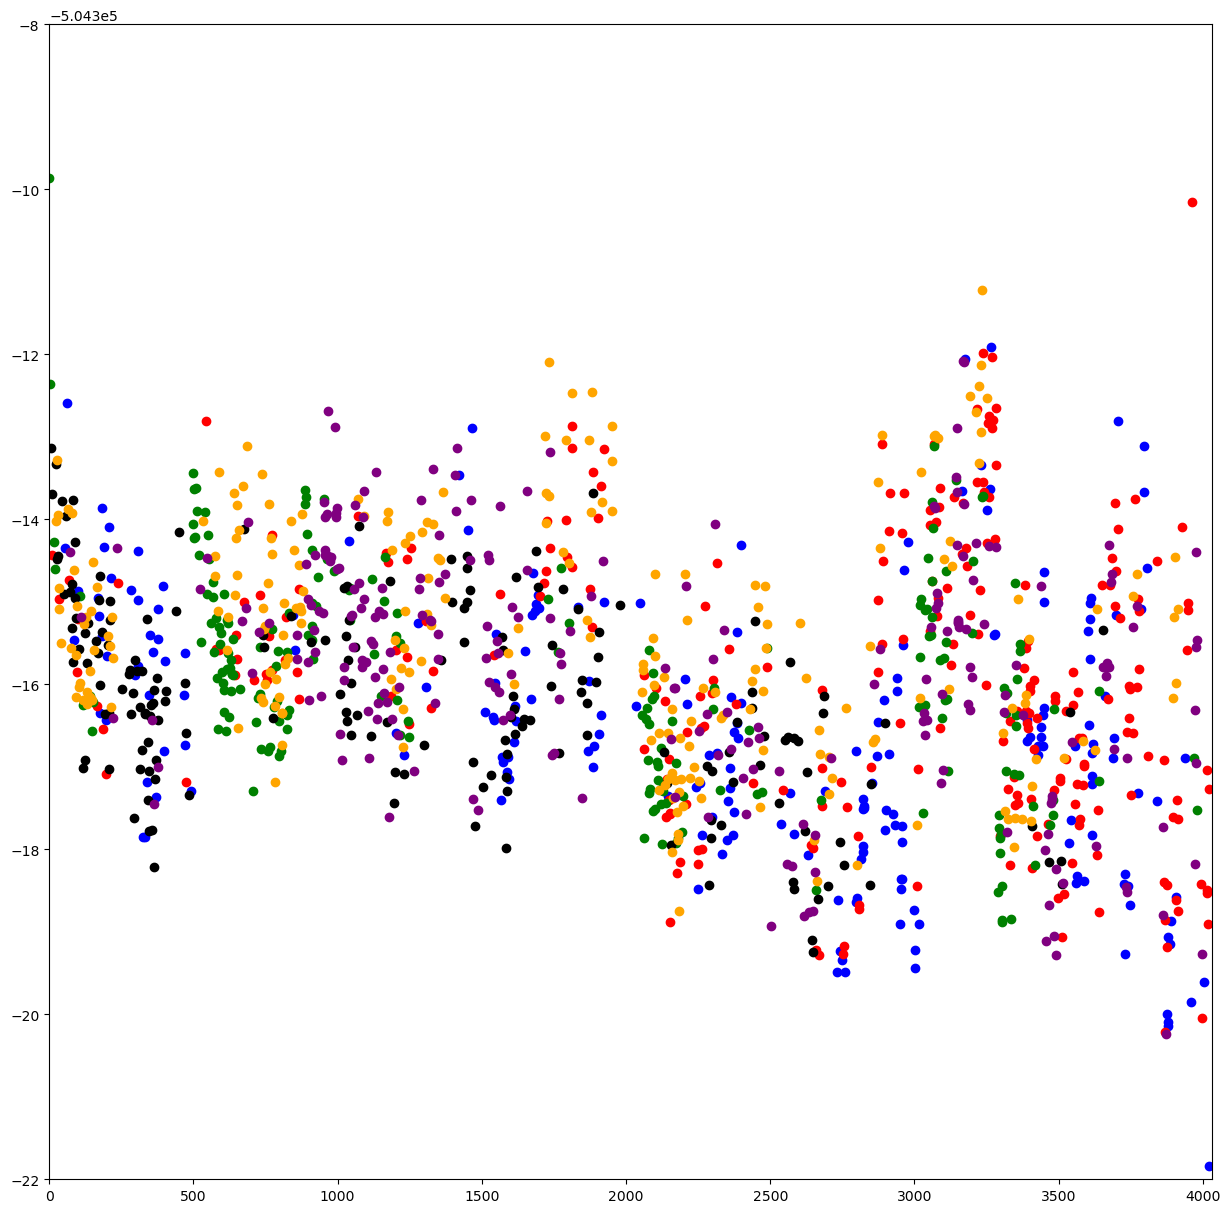

In [181]:
plt.scatter([int(x) for x in cluster_0['index'].tolist()],cluster_0['energies'],marker='o',color='blue', label='cluster 0')
plt.scatter([int(x) for x in cluster_1['index'].tolist()],cluster_1['energies'],marker='o',color='red')
plt.scatter([int(x) for x in cluster_2['index'].tolist()],cluster_2['energies'],marker='o',color='green')
plt.scatter([int(x) for x in cluster_3['index'].tolist()],cluster_3['energies'],marker='o',color='black')
plt.scatter([int(x) for x in cluster_4['index'].tolist()],cluster_4['energies'],marker='o',color='orange')
plt.scatter([int(x) for x in cluster_5['index'].tolist()],cluster_5['energies'],marker='o',color='purple')
plt.xlim(0, 4030)
plt.ylim(-504322, -504308)
ax.legend()

# <a id='protocol'>Protocol</a>

# <a id='symmetry'>Symmetry analysis</a>

Selected structures:
- 8 - 4008
- 6 - 0
- 4 - 25
- 3 - 3291
- 2 - 2278
- 1 - 1829

In [55]:
selected_structures = [4008, 0, 25, 3291, 2278, 1829]
sym_opt = [8, 6, 4, 3, 2, 1]

In [166]:
#the energies for the symmetry files
energies_sym = []
gap_sym = []
for i in selected_structures:
    crystal_output = Crystal_output().read_cry_output('./data/crystal/lts/symmetry/LTS_data/lts_sp_%s.out'%str(i))
    if crystal_output.get_final_energy() != None:
        energies_sym.append(crystal_output.get_final_energy())
        gap_sym.append(crystal_output.get_band_gap())

In [167]:
sym_an = pd.DataFrame()
sym_an['structures'] = selected_structures
sym_an['symmetry operators'] = sym_opt
sym_an['energies'] = energies_sym
sym_an['bandgap'] = gap_sym

In [169]:
sym_an

structures  symmetry operators       energies bandgap
0        4008                   8 -504312.086480   False
1           0                   6 -504309.859577   False
2          25                   4 -504313.334308  0.2389
3        3291                   3 -504318.514650  0.0819
4        2278                   2 -504314.295809   False
5        1829                   1 -504314.020513   False

In [182]:
Enr_Des[:4007]

Energies    Egap
0    -504309.859577  0.0000
1    -504312.104785  0.0000
2    -504312.356232  0.0068
3    -504312.411568  0.0000
4    -504313.530931  0.0000
...             ...     ...
4002 -504318.312855  0.1773
4003 -504312.123602  0.0000
4004 -504319.607493  0.3884
4005 -504316.697600  0.3908
4006 -504311.179013  0.0000

[4007 rows x 2 columns]

# EXTRA

## Coulomb Matrix from Matminer

In [52]:
cm_mm.fit(structures)


CoulombMatrix()

In [80]:
cm_mm = sf.CoulombMatrix(flatten=True)
matminer_matrix = cm_mm.fit(structures)
cm_matminer_1 = matminer_matrix.featurize(structures[0])


In [18]:
#CM using Matminer, this uses Pymatgen structures

#matminer descriptors
from matminer.featurizers import structure as sf

cm_matminer=[]
cm_mm = sf.CoulombMatrix(flatten=True)
start = datetime.now()
matminer_matrix = cm_mm.fit(structures)
for i,struct in enumerate(structures):
    
    #featurized_structure = matminer_matrix.featurize(struct)
    #cm_matminer.append(featurized_structure)
    now = datetime.now()
    #if len(cm_matminer)%200 == 0: 
        #print("matrices read:", len(cm_matminer),", time:", (now - start))
    
print('Number of matrices read: ', len(cm_matminer))
print("--- %s time taken ---" % ((datetime.now() - start)))

Number of matrices read:  0
--- 0:00:00.076173 time taken ---


In [81]:
print(cm_matminer_1)
print(cm_matminer_1.shape)

[1971.17128361  594.85348769  812.40237535  812.40237535  400.29414904
  702.13917465  702.13917465  366.01493461  812.40237535  812.40237535
  389.74361918  389.74361918    9.62967336  812.40237535  812.40237535
  371.27587096  371.27587096  389.74361918  389.74361918  318.20798292
  389.74361918  371.27587096  318.20798292  318.5145681   318.5145681
  318.5145681   389.74361918  371.27587096  371.27587096  371.27587096
  318.5145681   318.40672195    6.46328633    4.53258333    4.53258333
    4.53258333    4.53258333    5.11735365    5.11735365    5.11735365
    5.11735365    5.11735365    5.11735365    6.45907173    6.45907173
    6.45907173    6.45907173    6.45907173    6.45907173  318.40672195
  318.40672195  318.40672195  318.40672195  318.40672195]
(54,)


In [88]:
cm_ds = CoulombMatrix(n_atoms_max=54,permutation='eigenspectrum')
cm_1 = cm_ds.create(ase_structures[0])
print(cm_1)
print(cm_1.shape)

[2679.77619447 1133.67577892  913.07374493  841.08011951  712.6289803
  708.830714    692.25295309  656.98047438  655.93789699  611.12050477
  467.43255314  434.36093126  405.95650918  373.37691024  360.90885612
  360.73370676  330.59963438  323.17143181  321.91922861  319.70671666
  317.12026943  310.00661992  304.11487923  301.61723033  299.21583906
  298.12478161  296.60093965  292.83209275  292.52858515  292.14396424
  291.40954568  283.9316412   283.8511157   283.12161825  282.57751345
  280.79923438   12.8666636     7.39275912    7.03464999    5.57408163
    5.28041001    4.54978872    4.52989384    4.34655433    4.22686951
    4.14798147    3.80471049    3.74741204    3.72709043    3.52626779
    3.47022584    3.37089434    3.33626234    3.28758742]
(54,)


# <a id='f'>Functions</a>

### Error analysis

In [112]:
def r2(real,pred):
    r2 = r2_score(real, pred)
    return r2

def mae(real,pred):
    mae = mean_absolute_error(real, pred)*1000
    return mae

#maximum error
def maxer(real,pred):
    maxer = max_error(real, pred)*1000
    return maxer

def errorgraph(real,pred, descriptor, model):
    mae(real, pred)
    r2(real, pred)
    maxer(real,pred)
    
    plt.figure(dpi=200)
    plt.scatter(real, pred, marker='o')
    plt.ylabel("Predicted values")
    plt.xlabel("Calculated values")
    
    vmin=min(min(real),min(pred))
    vmax=max(max(real),max(pred))
    line=np.linspace(vmin,vmax)
    plt.plot(line,line,color='green')
    
    
    plt.title('%s %s' %(descriptor, model), fontsize=16)
    
    plt.show()
    plt.close()
    print('r squared value is', r2(real,pred))
    print('mean absolute error', mae(real,pred))
    print('maximum error', maxer(real,pred))

#### Finding the best training size

In [230]:
def trainsize(descriptor, energies, model): 
    test_para = np.arange(0.1,1,0.1)
    r2_ = []
    mae_ = []
    maxer_ = []
    paratesting = pd.DataFrame()
    paratesting['test size'] = test_para
    for i in test_para:
        X_train, X_test, y_train, y_test = train_test_split(descriptor, energies, random_state=1, test_size = i)
        scaler = StandardScaler()  
        scaler.fit(X_train)  
        X_train = scaler.transform(X_train)  
        X_test = scaler.transform(X_test)
            
        model.fit(X_train, y_train)
        ypred_LR = model.predict(X_test)

        r2_.append(r2(y_test,ypred_LR))
        mae_.append(mae(y_test, ypred_LR))
        maxer_.append(maxer(y_test,ypred_LR))
            
    paratesting['r^2 value'] = r2_
    paratesting['mean absolute error'] = mae_
    paratesting['maximum error'] = maxer_
    
    return paratesting

def sizeplot(parafile, parameter):
    r2_ = parafile['r^2 value'].tolist()
    mae_ = parafile['mean absolute error'].tolist()
    maxer_ = parafile['maximum error'].tolist()
    nn = parameter.tolist()
    
    
    fig, ax1 = plt.subplots(dpi=200)
    ax2 = ax1.twinx()
    
    ax1.plot(nn, r2_, marker='x', label='r^2 value')
    ax2.plot(nn, mae_, marker='o',color='green',label='mean absolute error')
    #ax2.plot(nn, maxer_, marker='o',color='red', label='maximum error')
    
    ax1.set_xlabel('tested parameter')
    ax1.set_ylabel('r^2 value')
    ax2.set_ylabel('error/ meV')
    
    
    plt.show()
    plt.close()
    
    
            
        